Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!

  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 63

In [1]:
num_days_R_prediction=63

In [2]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [3]:
%%R
max_days_prediction<-num_days_R_prediction

In [4]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=27 # =(6/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
#
drop_n_dataset_days=175
#

### Load Data from Github - John Hopkins Institute 

In [5]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [6]:
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
242                           NaN                Thailand  15.870032   
243                           NaN             Timor-Leste  -8.874217   
244                           NaN                    Togo   8.619500   
245                           NaN     Trinidad and Tobago  10.691800   
246                           NaN                 Tunisia  33.886917   
247                           NaN                  Turkey  38.963700   
248                           NaN           United States  40.000000   
249                           NaN                  Uganda   1.373333   
250                           NaN                 Ukraine  48.379400   
251                           NaN    United Arab Emirates  23.424076   
252                      Anguilla          United Kingdom  18.220600   
253                       Bermuda          United Kingdom  32.307800   
254        British Virgin Islands          United Kingdom  18.420700   
255                Cayman Islands          United Kingdom  19.313300   
256               Channel Islands          United Kingdom  49.372300   
257   Falkland Islands (Malvinas)          United Kingdom -51.796300   
258                     Gibraltar          United Kingdom  36.140800   
259                   Isle of Man          United Kingdom  54.236100   
260                    Montserrat          United Kingdom  16.742498   
261      Turks and Caicos Islands          United Kingdom  21.694000   
262                           NaN          United Kingdom  55.378100   
263                           NaN                 Uruguay -32.522800   
264                           NaN              Uzbekistan  41.377491   
265                           NaN                 Vanuatu -

## Get Population

In [7]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [8]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
248                           NaN                Thailand  15.870032   
249                           NaN             Timor-Leste  -8.874217   
250                           NaN                    Togo   8.619500   
251                           NaN     Trinidad and Tobago  10.691800   
252                           NaN                 Tunisia  33.886917   
253                           NaN                  Turkey  38.963700   
254                           NaN           United States  40.000000   
255                           NaN                  Uganda   1.373333   
256                           NaN                 Ukraine  48.379400   
257                           NaN    United Arab Emirates  23.424076   
258                      Anguilla          United Kingdom  18.220600   
259                       Bermuda          United Kingdom  32.307800   
260        British Virgin Islands          United Kingdom  18.420700   
261                Cayman Islands          United Kingdom  19.313300   
262               Channel Islands          United Kingdom  49.372300   
263   Falkland Islands (Malvinas)          United Kingdom -51.796300   
264                     Gibraltar          United Kingdom  36.140800   
265                   Isle of Man          United Kingdom  54.236100   
266                    Montserrat          United Kingdom  16.742498   
267      Turks and Caicos Islands          United Kingdom  21.694000   
268                           NaN          United Kingdom  55.378100   
269                           NaN                 Uruguay -32.522800   
270                           NaN              Uzbekistan  41.377491   
271                           NaN                 Vanuatu -

In [9]:
# merge region death
death.iloc[185:195,:]

Province/State Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN     Mauritania  21.007900  -10.940800        0        0   
186            NaN      Mauritius -20.348404   57.552152        0        0   
187            NaN         Mexico  23.634500 -102.552800        0        0   
188            NaN        Moldova  47.411600   28.369900        0        0   
189            NaN         Monaco  43.733300    7.416700        0        0   
190            NaN       Mongolia  46.862500  103.846700        0        0   
191            NaN     Montenegro  42.708678   19.374390        0        0   
192            NaN        Morocco  31.791700   -7.092600        0        0   
193            NaN     Mozambique -18.665695   35.529562        0        0   
194            NaN        Namibia -22.957600   18.490400        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  12/28/20  12/29/20  12/30/20  \
185        0        0        0        0  ...       330       334       339   
186        0        0        0        0  ...        10        10        10   
187        0        0        0        0  ...    122855    123845    124897   
188        0        0        0        0  ...      2909      2934      2960   
189        0        0        0        0  ...         3         3         3   
190        0        0        0        0  ...         0         1         1   
191        0        0        0        0  ...       675       677       681   
192        0        0        0        0  ...      7272      7314      7355   
193        0        0        0        0  ...       162       162       165   
194        0        0        0        0  ...       193       195       196   

     12/31/20  1/1/21  1/2/21  1/3/21  1/4/21   Population           region  
185       347     349     353     358     360     4,649,658  Mauritania_nan  
186        10      10      10      10      10           NaN   Mauritius_nan  
187    125807  126507  126851  127213  127757   128,640,794      Mexico_nan  
188      2985    3004    3020    3037    3054     4,035,942     Moldova_nan  
189         3       3       3       3       3        39,183      Monaco_nan  
190         1       1       1       1       1           NaN    Mongolia_nan  
191       682     684     684     689     692       622 500  Montenegro_nan  
192      7388    7425    7452    7485    7538    36,817,128     Morocco_nan  
193       166     167     168     169     171    31,542,919  Mozambique_nan  
194       205     208     213     215     218     2,540,905     Namibia_nan  

[10 rows x 355 columns]

In [10]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region      Lat      Long  \
175                               NaN        Morocco  31.7917   -7.0926   
176                               NaN     Mozambique -18.6657   35.5296   
177                               NaN        Namibia -22.9576   18.4904   
178                               NaN          Nepal  28.1667   84.2500   
179                             Aruba    Netherlands  12.5211  -69.9683   
180  Bonaire, Sint Eustatius and Saba    Netherlands  12.1784  -68.2385   
181                           Curacao    Netherlands  12.1696  -68.9900   
182                      Sint Maarten    Netherlands  18.0425  -63.0548   
183                               NaN    Netherlands  52.1326    5.2913   
184                               NaN    New Zealand -40.9006  174.8860   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  12/28/20  \
175        0        0        0        0        0        0  ...    399575   
176        0        0        0        0        0        0  ...     16178   
177        0        0        0        0        0        0  ...     18277   
178        0        0        0        0        0        0  ...    250581   
179        0        0        0        0        0        0  ...      5110   
180        0        0        0        0        0        0  ...       174   
181        0        0        0        0        0        0  ...      2568   
182        0        0        0        0        0        0  ...      1298   
183        0        0        0        0        0        0  ...         0   
184        0        0        0        0        0        0  ...      2077   

     12/29/20  12/30/20  12/31/20  1/1/21  1/2/21  1/3/21  1/4/21  \
175    401429    405251    407504  409638  412168  413393  414972   
176     16439     16589     16663   16680   16684   16765   16828   
177     18743     19655     20076   20727   20931   21055   21167   
178    251312    251912    252359  253107  253857  254494  255088   
179      5118      5132      5149    5179    5209    5209    5218   
180       174       178       180     180     180     180     180   
181      2657      2759      2925    2950    2950    3170    3280   
182      1308      1320      1331    1342    1355    1360    1370   
183         0         0         0       0       0       0       0   
184      2077      2082      2082    2082    2084    2084    2100   

      Population                                         region  
175    36,817,128                                   Morocco_nan  
176    31,542,919                                Mozambique_nan  
177     2,540,905                                   Namibia_nan  
178    29,300,000                                     Nepal_nan  
179       116,600                             Netherlands_Aruba  
180           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  
181       158,665                           Netherlands_Curacao  
182           NaN                      Netherlands_Sint Maarten  
183    17,180,000                               Netherlands_nan  
184     4,813,844                               New Zealand_nan  

[10 rows x 355 columns]

In [11]:
confirmed.iloc[185:195,:]

Province/State Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN     Mauritania  21.007900  -10.940800        0        0   
186            NaN      Mauritius -20.348404   57.552152        0        0   
187            NaN         Mexico  23.634500 -102.552800        0        0   
188            NaN        Moldova  47.411600   28.369900        0        0   
189            NaN         Monaco  43.733300    7.416700        0        0   
190            NaN       Mongolia  46.862500  103.846700        0        0   
191            NaN     Montenegro  42.708678   19.374390        0        0   
192            NaN        Morocco  31.791700   -7.092600        0        0   
193            NaN     Mozambique -18.665695   35.529562        0        0   
194            NaN        Namibia -22.957600   18.490400        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  12/28/20  12/29/20  12/30/20  \
185        0        0        0        0  ...     13778     13989     14191   
186        0        0        0        0  ...       527       527       527   
187        0        0        0        0  ...   1389430   1401529   1413935   
188        0        0        0        0  ...    141924    142851    143841   
189        0        0        0        0  ...       801       827       853   
190        0        0        0        0  ...      1175      1195      1215   
191        0        0        0        0  ...     46969     47404     47782   
192        0        0        0        0  ...    433029    435189    437332   
193        0        0        0        0  ...     18310     18372     18485   
194        0        0        0        0  ...     22287     22851     23333   

     12/31/20   1/1/21   1/2/21   1/3/21   1/4/21   Population   \
185     14364    14581    14677    14794    14875     4,649,658   
186       527      527      527      527      531           NaN   
187   1426094  1437185  1443544  1448755  1455219   128,640,794   
188    144818   145258   145694   145873   146309     4,035,942   
189       875      885      901      907      917        39,183   
190      1220     1242     1263     1286     1308           NaN   
191     48247    48589    48856    49195    49630       622 500   
192    439193   440970   442141   443146   443802    36,817,128   
193     18642    18794    18968    19309    19463    31,542,919   
194     23941    24545    24654    25116    25386     2,540,905   

             region  
185  Mauritania_nan  
186   Mauritius_nan  
187      Mexico_nan  
188     Moldova_nan  
189      Monaco_nan  
190    Mongolia_nan  
191  Montenegro_nan  
192     Morocco_nan  
193  Mozambique_nan  
194     Namibia_nan  

[10 rows x 355 columns]

In [12]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
221            NaN                       Saint Lucia  13.909400  -60.978900   
222            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
223            NaN                             Samoa -13.759000 -172.104600   
224            NaN                        San Marino  43.942400   12.457800   
225            NaN             Sao Tome and Principe   0.186400    6.613100   
226            NaN                      Saudi Arabia  23.885942   45.079162   
227            NaN                           Senegal  14.497400  -14.452400   
228            NaN                            Serbia  44.016500   21.005900   
229            NaN                        Seychelles  -4.679600   55.492000   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  12/28/20  \
220        0        0        0        0        0        0  ...        32   
221        0        0        0        0        0        0  ...       331   
222        0        0        0        0        0        0  ...       109   
223        0        0        0        0        0        0  ...         2   
224        0        0        0        0        0        0  ...      2275   
225        0        0        0        0        0        0  ...      1014   
226        0        0        0        0        0        0  ...    362339   
227        0        0        0        0        0        0  ...     18728   
228        0        0        0        0        0        0  ...    328619   
229        0        0        0        0        0        0  ...       217   

     12/29/20  12/30/20  12/31/20  1/1/21  1/2/21  1/3/21  1/4/21  \
220        32        32        32      32      33      33      33   
221       331       340       353     353     353     353     360   
222       113       115       121     121     122     124     124   
223         2         2         2       2       2       2       2   
224      2333      2384      2428    2428    2428    2428    2493   
225      1014      1014      1014    1022    1024    1024    1024   
226    362488    362601    362741  362878  362979  363061  363155   
227     18806     18945     19140   19364   19511   19697   19803   
228    331755    334991    337923  339997  341904  343870  346585   
229       217       256       275     275     285     297     313   

      Population                                 region  
220           NaN             Saint Kitts and Nevis_nan  
221           NaN                       Saint Lucia_nan  
222           NaN  Saint Vincent and the Grenadines_nan  
223           NaN                             Samoa_nan  
224        33,916                        San Marino_nan  
225           NaN             Sao Tome and Principe_nan  
226    34,695,447                      Saudi Arabia_nan  
227    16,743,927                           Senegal_nan  
228     8,744,671                            Serbia_nan  
229           NaN                        Seychelles_nan  

[10 rows x 355 columns]

## Create Time Series + Plots

In [13]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [14]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [15]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

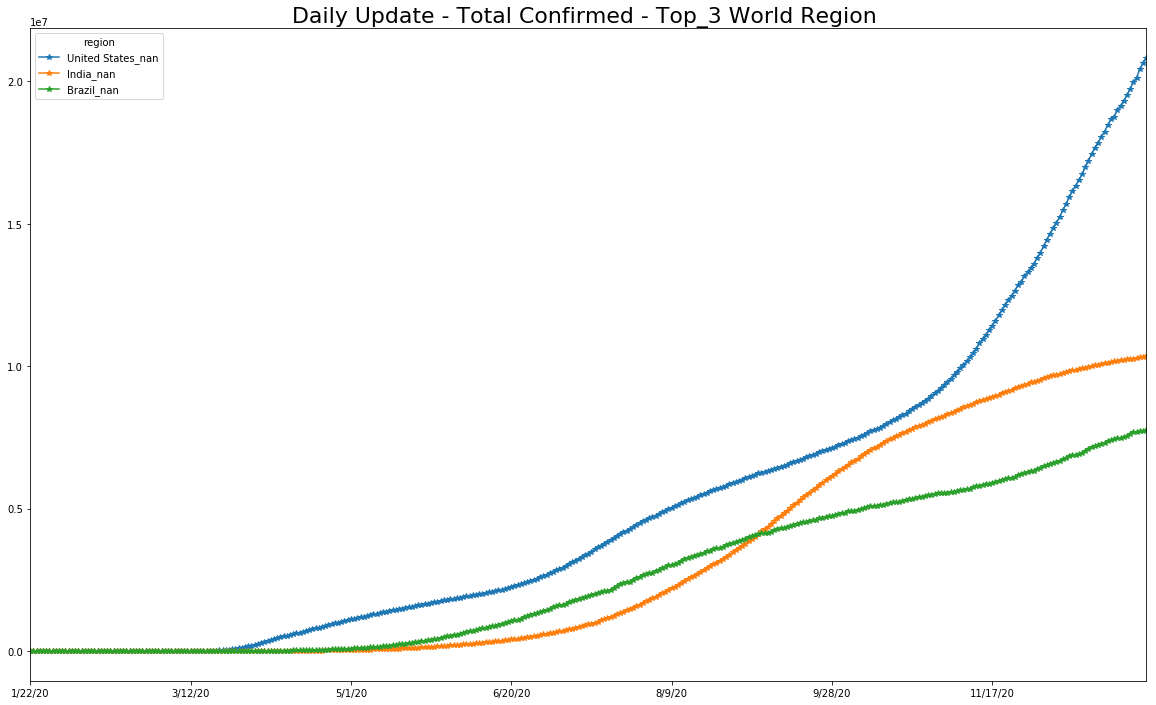

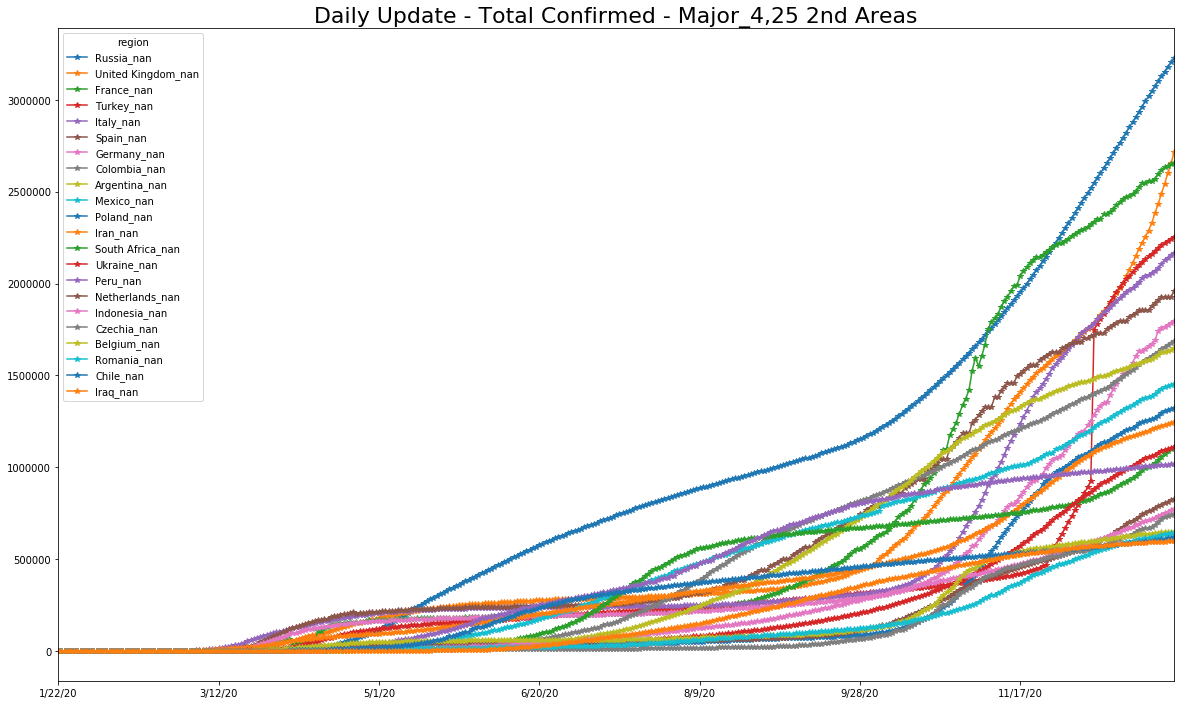

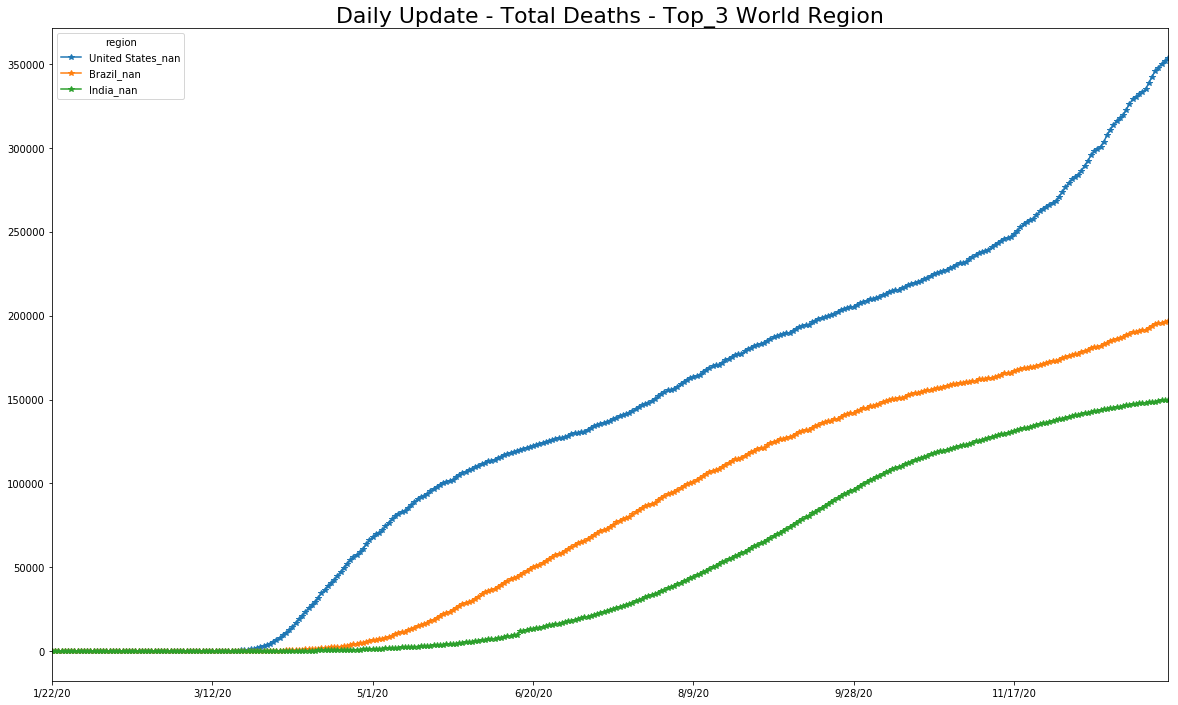

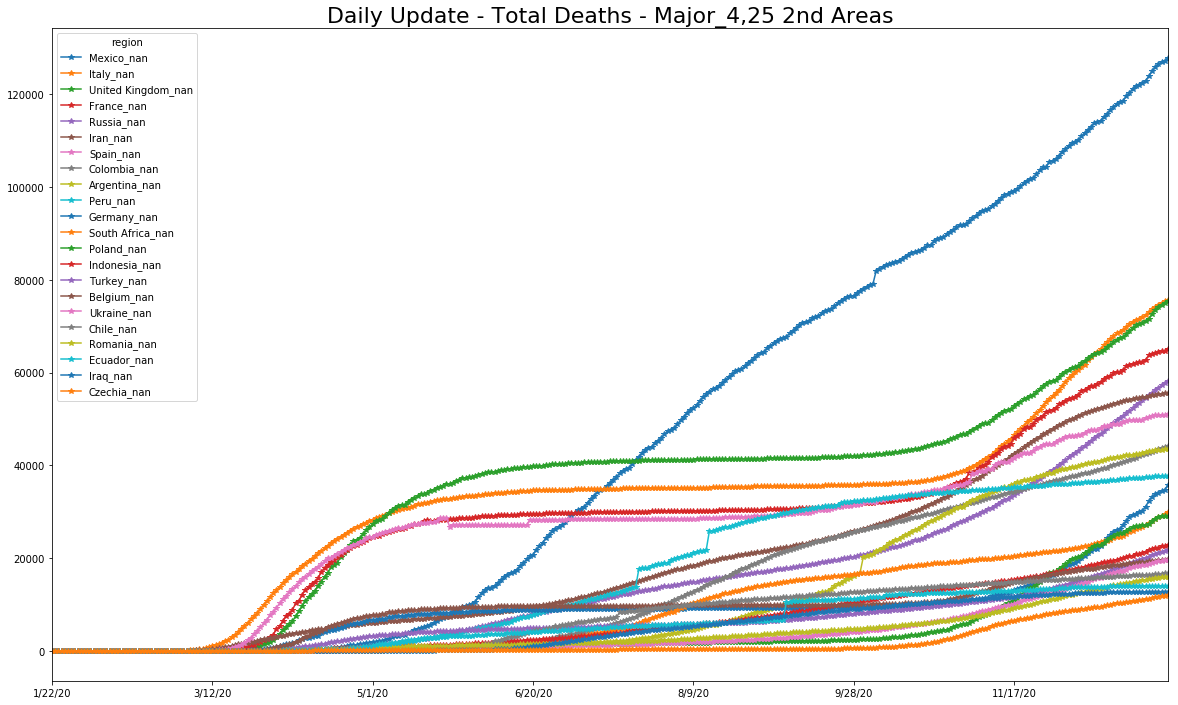

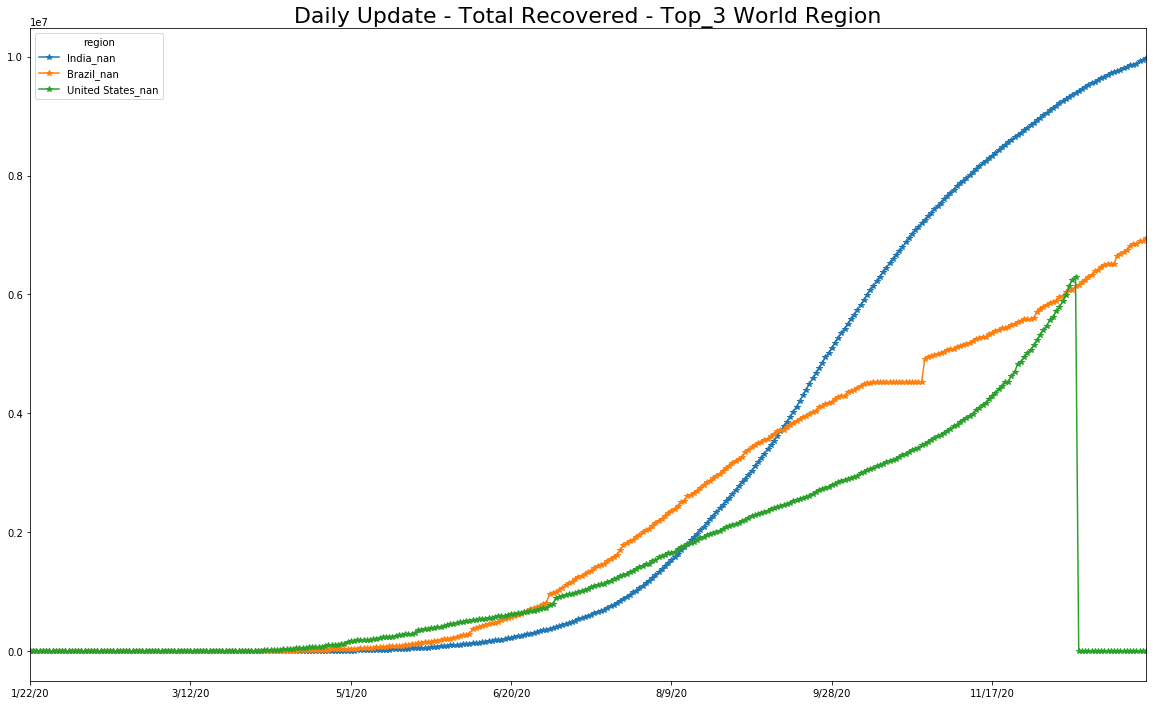

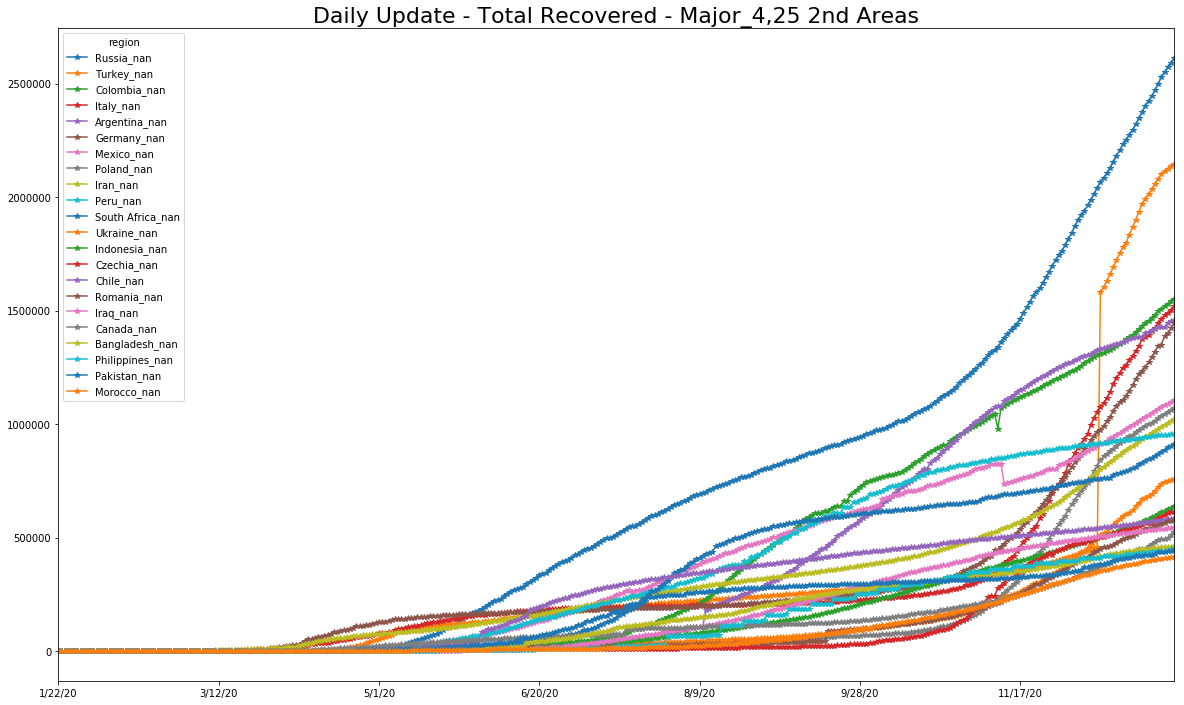

In [16]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [17]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [18]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [19]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2021/01/05


In [20]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [21]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [22]:
# Joao - FIX - Improve Performance 
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [23]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
7/15/20            34984         3752        20770          862         576   
7/16/20            35060         3851        21355          877         607   
7/17/20            35219         3906        21948          880         638   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
7/15/20                       74         111146        33005   
7/16/20                       74         114783        33559   
7/17/20                       76         119301        34001   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
7/15/20                                     113                       3527   
7/16/20                                     113                       3535   
7/17/20                                     113                       3550   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
7/15/20  ...            3495012         1009           14581            0   
7/16/20  ...            3571721         1026           15066            0   
7/17/20  ...            3643660         1037           15607            0   

region   Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
7/15/20          10428          381                    7064       1526   
7/16/20          10854          381                    7412       1552   
7/17/20          11191          382                    7764       1576   

region   Zambia_nan  Zimbabwe_nan  
7/15/20        1895          1089  
7/16/20        1895          1362  
7/17/20        2810          1420  

[3 rows x 272 columns]

In [24]:
ts[-4:]

region  Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
1/1/21            51526        58316        99897         8117       17568   
1/2/21            51526        58991       100159         8166       17608   
1/3/21            51526        59438       100408         8192       17642   
1/4/21            53011        59623       100645         8249       17684   

region  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
1/1/21                      159        1629594       159738   
1/2/21                      159        1634834       159798   
1/3/21                      160        1640718       160027   
1/4/21                      160        1648940       160220   

region  Australia_Australian Capital Territory  Australia_New South Wales  \
1/1/21                                     118                       4947   
1/2/21                                     118                       4958   
1/3/21                                     118                       4965   
1/4/21                                     118                       4973   

region  ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
1/1/21  ...           20128693        19753           77182            1   
1/2/21  ...           20426184        20275           77182            1   
1/3/21  ...           20636663        20823           77258            1   
1/4/21  ...           20817140        21426           77258            1   

region  Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
1/1/21         113884         1474                  139223       2101   
1/2/21         114083         1482                  140287       2101   
1/3/21         114230         1494                  141219       2101   
1/4/21         114407         1497                  142228       2101   

region  Zambia_nan  Zimbabwe_nan  
1/1/21       20997         14084  
1/2/21       21230         14491  
1/3/21       21582         15265  
1/4/21       21993         15829  

[4 rows x 272 columns]

In [25]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [26]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [27]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [28]:
p=%R pred_all

In [29]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [30]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [31]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [32]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [33]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [34]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [35]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [36]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2020-07-16  Afghanistan_nan      35060             0             0   
2     2020-07-17  Afghanistan_nan      35219            76             0   
3     2020-07-18  Afghanistan_nan      35279           159             0   
4     2020-07-19  Afghanistan_nan      35453            60           295   
5     2020-07-20  Afghanistan_nan      35493           174           393   
6     2020-07-21  Afghanistan_nan      35605            40           274   
7     2020-07-22  Afghanistan_nan      35717           112           326   
8     2020-07-23  Afghanistan_nan      35918           112           264   
9     2020-07-24  Afghanistan_nan      35978           201           425   
10    2020-07-25  Afghanistan_nan      36026            60           373   
11    2020-07-26  Afghanistan_nan      36147            48           309   
12    2020-07-27  Afghanistan_nan      36253           121           229   
13    2020-07-28  Afghanistan_nan      36358           106           275   
14    2020-07-29  Afghanistan_nan      36463           105           332   
15    2020-07-30  Afghanistan_nan      36532           105           316   
16    2020-07-31  Afghanistan_nan      36665            69           279   
17    2020-08-01  Afghanistan_nan      36700           133           307   
18    2020-08-02  Afghanistan_nan      36701            35           237   
19    2020-08-03  Afghanistan_nan      36737             1           169   
20    2020-08-04  Afghanistan_nan      36773            36            72   
21    2020-08-05  Afghanistan_nan      36820            36            73   
22    2020-08-06  Afghanistan_nan      36928            47           119   
23    2020-08-07  Afghanistan_nan      37006           108           191   
24    2020-08-08  Afghanistan_nan      37046            78           233   
25    2020-08-09  Afghanistan_nan      37083            40           226   
26    2020-08-10  Afghanistan_nan      37153            37           155   
27    2020-08-11  Afghanistan_nan      37260            70           147   
28    2020-08-12  Afghanistan_nan      37336           107           214   
29    2020-08-13  Afghanistan_nan      37422            76           253   
30    2020-08-14  Afghanistan_nan      37497            86           269   
...          ...              ...        ...           ...           ...   
48620 2020-12-07     Zimbabwe_nan      10839           101           294   
48621 2020-12-08     Zimbabwe_nan      10912           121           292   
48622 2020-12-09     Zimbabwe_nan      11007            73           295   
48623 2020-12-10     Zimbabwe_nan      11081            95           289   
48624 2020-12-11     Zimbabwe_nan      11162            74           242   
48625 2020-12-12     Zimbabwe_nan      11219            81           250   
48626 2020-12-13     Zimbabwe_nan      11246            57           212   
48627 2020-12-14     Zimbabwe_nan      11358            27           165   
48628 2020-12-15     Zimbabwe_nan      11522           112           196   
48629 2020-12-16     Zimbabwe_nan      11749           164           303   
48630 2020-12-17     Zimbabwe_nan      11866           227           503   
48631 2020-12-18     Zimbabwe_nan      12047           117           508   
48632 2020-12-19     Zimbabwe_nan      12151           181           525   
48633 2020-12-20     Zimbabwe_nan      12325           104           402   
48634 2020-12-21     Zimbabwe_nan      12422           174           459   
48635 2020-12-22     Zimbabwe_nan      12544            97           375   
48636 2020-12-23     Zimbabwe_nan      12656           122           393   
48637 2020-12-24     Zimbabwe_nan      12786           112           331   
48638 2020-12-25     Zimbabwe_nan      12880           130           364   
48639 2020-12-26     Zimbabwe_nan      12963            94           336   
48640 2020-12-27     Zimbabwe_nan      13077            83  

In [37]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [38]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
48649 2021-01-05  Zimbabwe_nan          0           564          1745   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
48649          2681         103.694792         112.390017          120.39101   

       last_day  kalman_prediction  population  infected_rate  min  max  
48649     15829            15944.0    14862924       0.000011  NaN  NaN

In [39]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
48649 2021-01-05  Zimbabwe_nan          0           564          1745   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
48649          2681         103.694792         112.390017          120.39101   

       last_day  kalman_prediction  population  infected_rate  min  max  
48649     15829            15944.0    14862924       0.000011  NaN  NaN

In [40]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=ratiod['infected_rate']*1000
ratiod['delta : new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : new_cases per 1M hab']=ratiod['delta : new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
47597  2021-01-03  Zimbabwe_nan      15265           407           866   
47598  2021-01-04  Zimbabwe_nan      15829           774          1398   
47599  2021-01-05  Zimbabwe_nan          0           564          1745   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
47597          1528         102.889875         106.356037         111.787472   
47598          2188         105.341315         110.081561         116.731743   
47599          2681         103.694792         112.390017         120.391010   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
47597                14491  ...    14862924       0.000010  NaN  NaN   
47598                15265  ...    14862924       0.000010  NaN  NaN   
47599                15829  ...    14862924       0.000011  NaN  NaN   

       population_percentage : infected_rate confirmed  \
47597                                         0.000975   
47598                                         0.001027   
47599                                         0.001065   

       population_percentage : factor 9/10 infected_rate confirmed  \
47597                                           0.009750             
47598                                           0.010271             
47599                                           0.010651             

       delta : new_cases  delta : new_cases per 1M hab  \
47597               81.0                      5.449802   
47598              -26.0                     -1.749319   
47599              115.0                      7.737374   

       delta : roling 7day AVG  \
47597               218.285714   
47598               312.571429   
47599               383.000000   

       delta : aprox 14-day case notification rate per 100k hab  
47597                                          20.561230         
47598                                          29.442390         
47599                                          36.076347         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
262  United States_nan  2.546276e+12  1.595705e+06  142638.672414


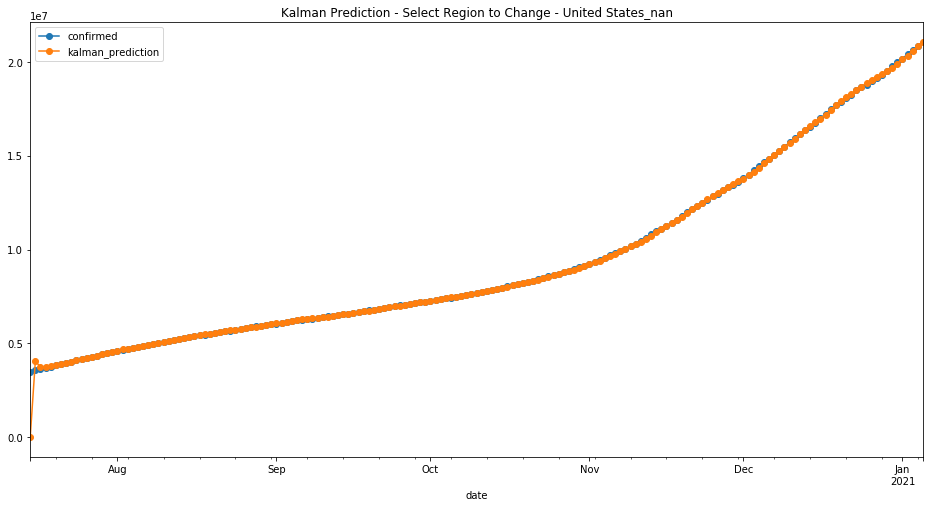

In [41]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse           mae
212  Russia_nan  6.096629e+10  246913.536372  20884.787356


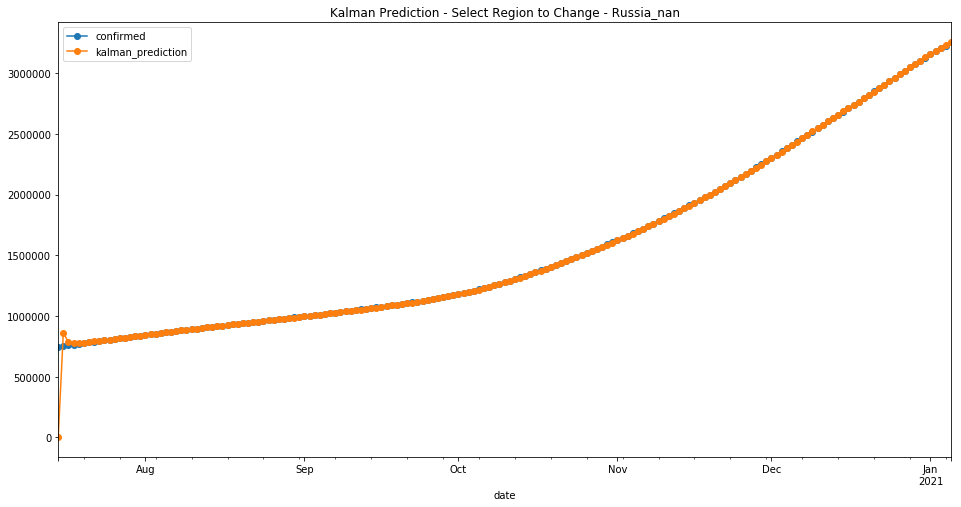

In [42]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse           mae
30  Brazil_nan  3.503393e+11  591894.65015  62703.149425


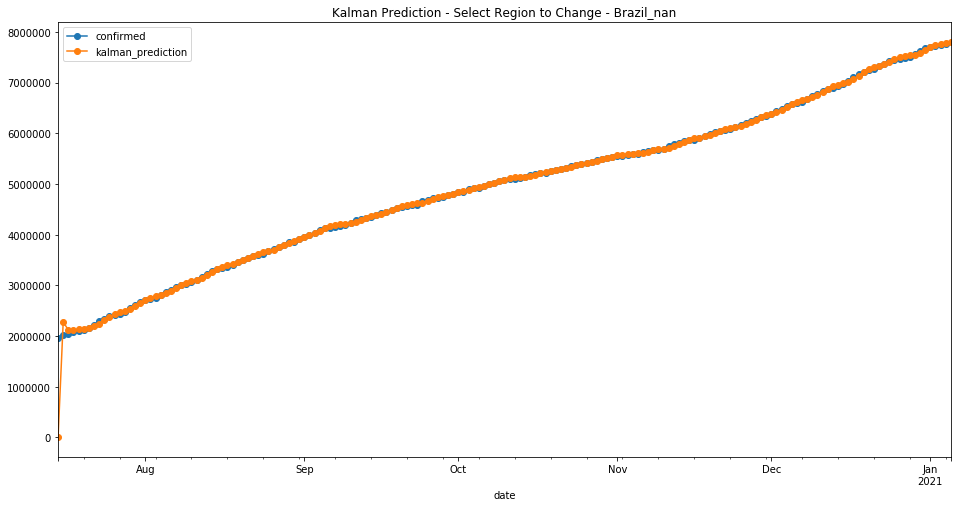

In [43]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse           rmse           mae
261  United Kingdom_nan  4.391220e+10  209552.386151  19773.270115


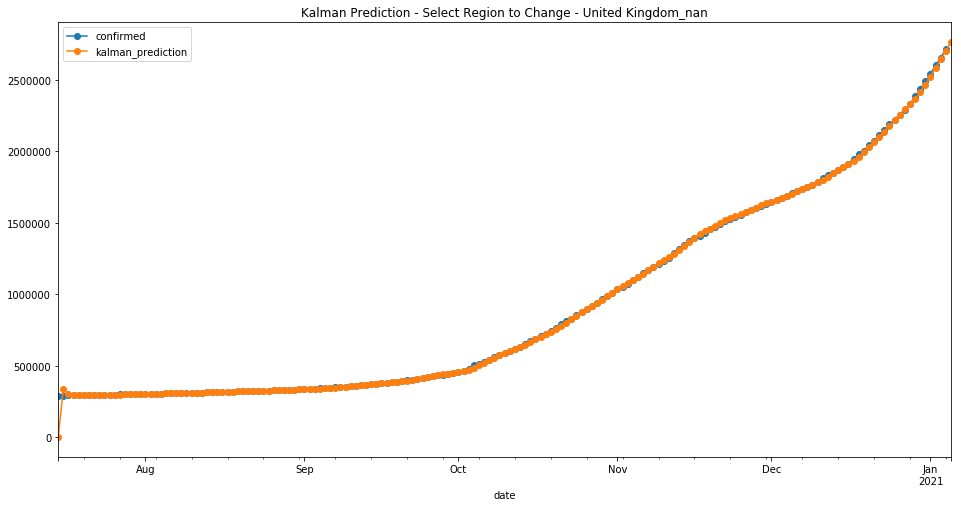

In [44]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [45]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp7kdxueh3
  JVM stdout: /tmp/tmp7kdxueh3/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp7kdxueh3/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Etc/GMT
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.1.3
H2O_cluster_version_age:    3 months and 7 days
H2O_cluster_name:           H2O_from_python_unknownUser_xrhxjh
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.049 Gb
H2O_cluster_total_cores:    10
H2O_cluster_allowed_cores:  10
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.7 final
--------------------------  ------------------------------------------------------------------

In [46]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2020-12-09
last_train_date= 2021-01-04
first_bootstrap_date= 2020-12-27
boost_bootstrap_date= 2021-01-01
first_test_date= 2020-12-26
last_test_date= 2021-01-05
first_valid_date= 2021-01-03


In [47]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [48]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [49]:
pred2.iloc[:25]

0  confirmed       date           region
0   51146.0      51039 2020-12-27  Afghanistan_nan
1   51285.0      51280 2020-12-28  Afghanistan_nan
2   51502.0      51350 2020-12-29  Afghanistan_nan
3   51582.0      51405 2020-12-30  Afghanistan_nan
4   51649.0      51526 2020-12-31  Afghanistan_nan
5   51745.0      51526 2021-01-01  Afghanistan_nan
6   51737.0      51526 2021-01-02  Afghanistan_nan
7   51720.0      51526 2021-01-03  Afghanistan_nan
8   51690.0      53011 2021-01-04  Afghanistan_nan
9   53048.0          0 2021-01-05  Afghanistan_nan
10  56169.0      56254 2020-12-27      Albania_nan
11  56662.0      56572 2020-12-28      Albania_nan
12  56968.0      57146 2020-12-29      Albania_nan
13  57525.0      57727 2020-12-30      Albania_nan
14  58082.0      58316 2020-12-31      Albania_nan
15  58699.0      58316 2021-01-01      Albania_nan
16  58760.0      58991 2021-01-02      Albania_nan
17  59406.0      59438 2021-01-03      Albania_nan
18  59791.0      59623 2021-01-04      Albania_nan
19  60025.0          0 2021-01-05      Albania_nan
20  98363.0      98249 2020-12-27      Algeria_nan
21  98755.0      98631 2020-12-28      Algeria_nan
22  99136.0      98988 2020-12-29      Algeria_nan
23  99482.0      99311 2020-12-30      Algeria_nan
24  99797.0      99610 2020-12-31      Algeria_nan

In [50]:
pred2.iloc[175:195]

0  confirmed       date          region
175  219957.0     219041 2021-01-01  Azerbaijan_nan
176  220146.0     219462 2021-01-02  Azerbaijan_nan
177  220490.0     220265 2021-01-03  Azerbaijan_nan
178  221153.0     220599 2021-01-04  Azerbaijan_nan
179  221311.0          0 2021-01-05  Azerbaijan_nan
180    7868.0       7834 2020-12-27     Bahamas_nan
181    7867.0       7834 2020-12-28     Bahamas_nan
182    7915.0       7846 2020-12-29     Bahamas_nan
183    7921.0       7857 2020-12-30     Bahamas_nan
184    7929.0       7871 2020-12-31     Bahamas_nan
185    7943.0       7887 2021-01-01     Bahamas_nan
186    7958.0       7887 2021-01-02     Bahamas_nan
187    7973.0       7914 2021-01-03     Bahamas_nan
188    7975.0       7924 2021-01-04     Bahamas_nan
189    8000.0          0 2021-01-05     Bahamas_nan
190   91448.0      91733 2020-12-27     Bahrain_nan
191   91676.0      91935 2020-12-28     Bahrain_nan
192   91882.0      92169 2020-12-29     Bahrain_nan
193   92118.0      92425 2020-12-30     Bahrain_nan
194   92371.0      92675 2020-12-31     Bahrain_nan

In [51]:
pred2.iloc[220:240]

0  confirmed       date       region
220  186789.0     186747 2020-12-27  Belarus_nan
221  188612.0     188588 2020-12-28  Belarus_nan
222  190456.0     190404 2020-12-29  Belarus_nan
223  192252.0     192361 2020-12-30  Belarus_nan
224  194206.0     194284 2020-12-31  Belarus_nan
225  196114.0     196223 2021-01-01  Belarus_nan
226  198066.0     198125 2021-01-02  Belarus_nan
227  199976.0     199962 2021-01-03  Belarus_nan
228  201820.0     201831 2021-01-04  Belarus_nan
229  203693.0          0 2021-01-05  Belarus_nan
230  639959.0     638877 2020-12-27  Belgium_nan
231  640802.0     639734 2020-12-28  Belgium_nan
232  641284.0     641411 2020-12-29  Belgium_nan
233  642750.0     644242 2020-12-30  Belgium_nan
234  645469.0     646496 2020-12-31  Belgium_nan
235  647644.0     648289 2021-01-01  Belgium_nan
236  649616.0     649169 2021-01-02  Belgium_nan
237  650488.0     650011 2021-01-03  Belgium_nan
238  651346.0     650887 2021-01-04  Belgium_nan
239  652053.0          0 2021-01-05  Belgium_nan

In [52]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [53]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  1971502742.213606
# MSE on the validation data =  5673642098257.99
# R^2 on the training data =  0.9996325657772088
# R^2 on the validation data =  0.4463969443558252


In [54]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1609829750745_1


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              500.0                     500.0           22745533.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       23.0       23.0        23.0      3338.0      3693.0     3559.448



ModelMetricsRegression: drf
** Reported on train data. **

MSE: 1971502742.213606
RMSE: 44401.60742826329
MAE: 5006.299775618789
RMSLE: 0.18585457611196812
Mean Residual Deviance: 1971502742.213606

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 5673642098257.99
RMSE: 2381940.825935437
MAE: 601584.4128804978
RMSLE: 7.347328845326599
Mean Residual Deviance: 5673642098257.99

Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2021-01-05 06:56:01   0.117 sec              0.0            NaN   
1     2021-01-05 06:56:01   0.775 sec              1.0   71426.193288   
2     2021-01-05 06:56:01   0.978 sec              2.0   60644.498716   
3     2021-01-05 06:56:02   1.178 sec              3.0   64316.825364   
4     2021-01-05 06:56:02   1.426 sec              4.0   70466.241371   
5     2021-01-05 06:56:02   1.529 sec              5.0   64378.154670   
6     2021-01-05 06:56:02   1.639 sec              6.0   62166.680221   
7     2021-01-05 06:56:02   1.764 sec              7.0   56434.872660   
8     2021-01-05 06:56:02   1.873 sec              8.0   55795.076273   
9     2021-01-05 06:56:02   1.973 sec              9.0   53796.054280   
10    2021-01-05 06:56:03   2.075 sec             10.0   51362.706417   
11    2021-01-05 06:56:03   2.219 sec             11.0   51941.382794   
12    2021-01-05 06:56:03   2.355 sec             12.0   53117.565061   
13    2021-01-05 06:56:03   2.435 sec             13.0   51311.745173   
14    2021-01-05 06:56:03   2.508 sec             14.0   50696.530499   
15    2021-01-05 06:56:03   2.583 sec             15.0   46542.543488   
16    2021-01-05 06:56:03   2.658 sec             16.0   43666.963798   
17    2021-01-05 06:56:03   2.771 sec             17.0   43798.753410   
18    2021-01-05 06:56:03   2.871 sec             18.0   42054.127765   
19    2021-01-05 06:56:03   2.973 sec             19.0   43256.617453   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0            NaN                NaN              NaN             NaN   
1   14169.512737       5.101701e+09     2.393378e+06   600648.061937   
2   12885.738191       3.677755e+09     2.398562e+06   599541.994213   
3   13904.284198       4.136654e+09     2.401472e+06   599829.873520   
4   14019.776117       4.965491e+09     2.402839e+06   599228.711828   
5   12640.401633       4.144547e+09     2.402809e+06   598698.898756   
6   12071.516932       3.864696e+09     2.403698e+06   598894.412916   
7   11237.900871       3.184895e+09     2.400144e+06   598453.065047   
8   11105.595925       3.113091e+09     2.398114e+06   597483.467635   
9   10625.145868       2.894015e+09     2.404968e+06   600785.415183   
10  10453.299375       2.638128e+09     2.405003e+06   600360.855224   
11  10187.742308       2.697907e+09     2.403175e+06   600122.913060   
12  10143.049009       2.821476e+09     2.401550e+06   599838.526433   
13   9587.220845       2.632895e+09     2.401413e+06   599538.231531   
14   9783.862874       2.570138e+09     2.400618e+06   598602.178482   
15   9271.577714       2.166208e+09     2.399953e+06   598423.542667   
16   8940.534269       1.906804e+09     2.399051e+06   598328.462270   
17   8676.034831       1.918331e+09     2.398437e+06   598397.485791   
18   8537.679640       1.768550e+09     2.398414e+06   598261.954783   
19   8413.971000       1.871135e+09     2.387478e+06   598297.943595   

    validation_deviance  
0                   NaN  
1          5.728258e+12  
2          5.753098e+12  
3          5.767066e+12  
4          5.773635e+12  
5          5.773493e+12  
6          5.777763e+12  
7          5.760689e+12  
8          5.750951e+12  
9          5.783869e+12  
10         5.784038e+12  
11         5.775252e+12  
12         5.767442e+12  
13         5.766786e+12  
14         5.762967e+12  
15         5.759773e+12  
16         5.755447e+12  
17         5.752501e+12  
18         5.752390e+12  
19         5.700050e+12


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         5.500578e+18           1.000000    0.337815
1            last_day         4.578888e+18           0.832438    0.281210
2              region         2.396838e+18           0.435743    0.147200
3        7_day_change         1.623061e+18           0.295071    0.099679
4        3_day_change         8.784965e+17           0.159710    0.053952
5        1_day_change         5.636948e+17           0.102479    0.034619
6       infected_rate         5.019303e+17           0.091250    0.030826
7   7_day_change_rate         6.613338e+16           0.012023    0.004062
8                 min         5.836537e+16           0.010611    0.003584
9                 max         5.793694e+16           0.010533    0.003558
10  3_day_change_rate         3.421114e+16           0.006220    0.002101
11  1_day_change_rate         2.267815e+16           0.004123    0.001393

In [55]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         5.500578e+18           1.000000    0.337815
1            last_day         4.578888e+18           0.832438    0.281210
2              region         2.396838e+18           0.435743    0.147200
3        7_day_change         1.623061e+18           0.295071    0.099679
4        3_day_change         8.784965e+17           0.159710    0.053952
5        1_day_change         5.636948e+17           0.102479    0.034619
6       infected_rate         5.019303e+17           0.091250    0.030826
7   7_day_change_rate         6.613338e+16           0.012023    0.004062
8                 min         5.836537e+16           0.010611    0.003584
9                 max         5.793694e+16           0.010533    0.003558
10  3_day_change_rate         3.421114e+16           0.006220    0.002101
11  1_day_change_rate         2.267815e+16           0.004123    0.001393

In [56]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


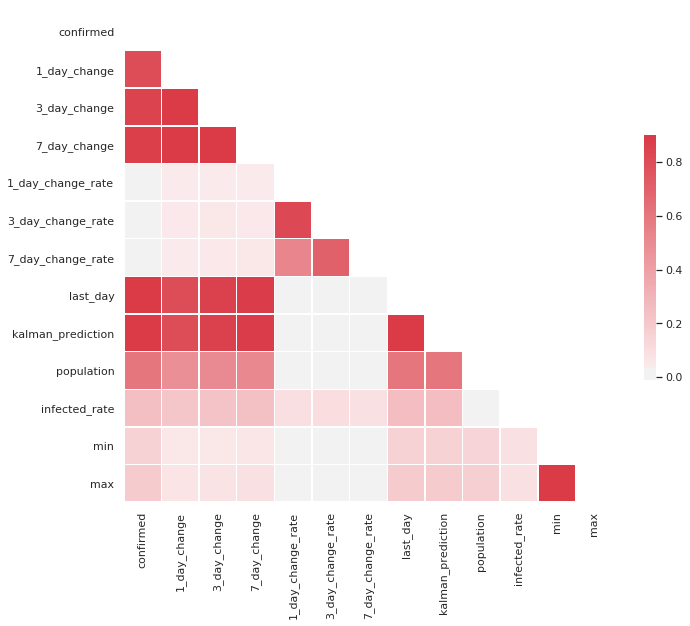

In [57]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [58]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.803727
3_day_change         0.854481
7_day_change         0.875481
1_day_change_rate    0.029061
3_day_change_rate    0.029771
7_day_change_rate    0.024371
last_day             0.989685
kalman_prediction    0.989980
population           0.610626
infected_rate        0.250666
min                  0.161596
max                  0.183697
Name: confirmed, dtype: float64


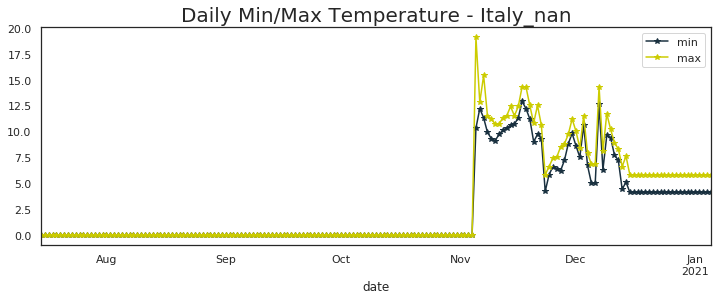

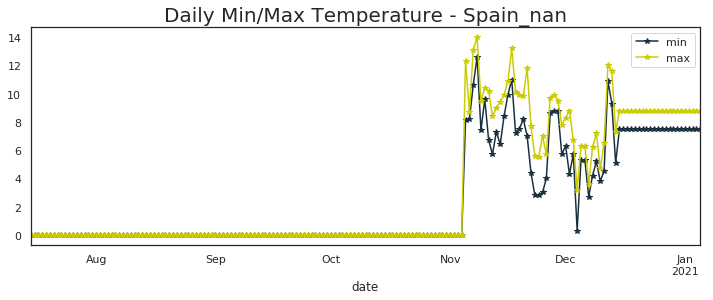

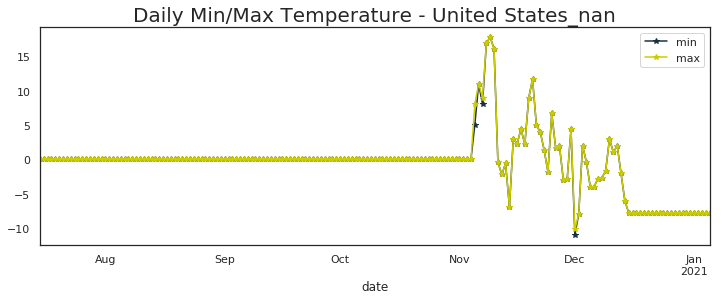

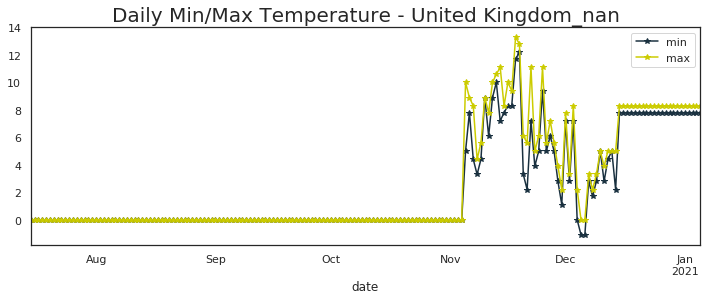

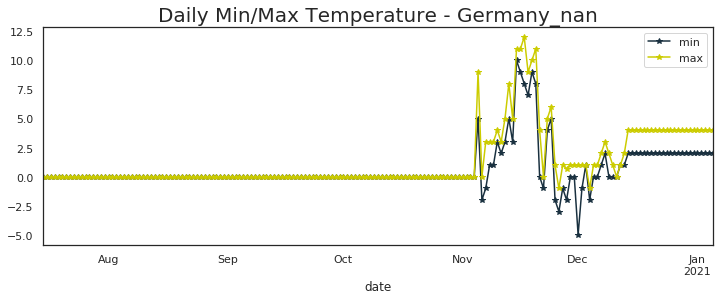

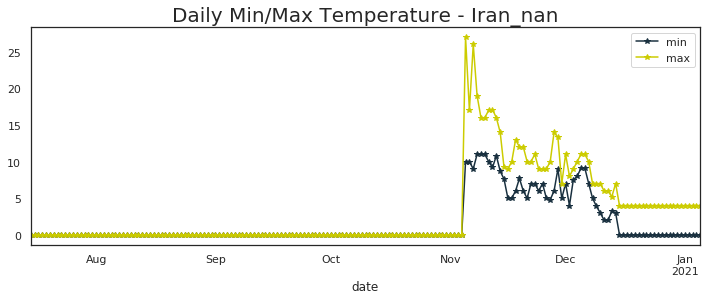

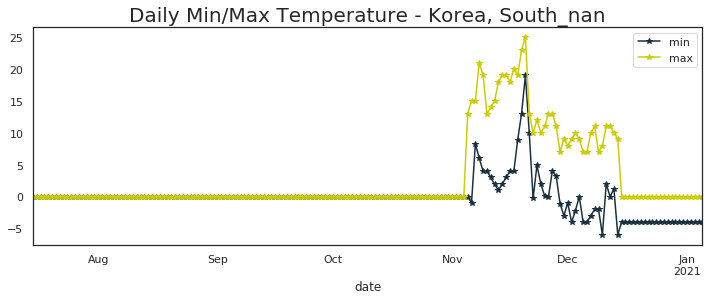

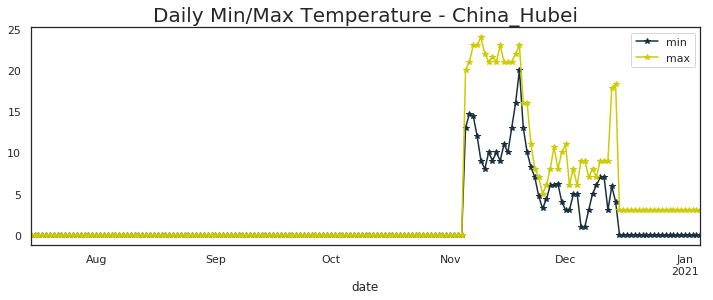

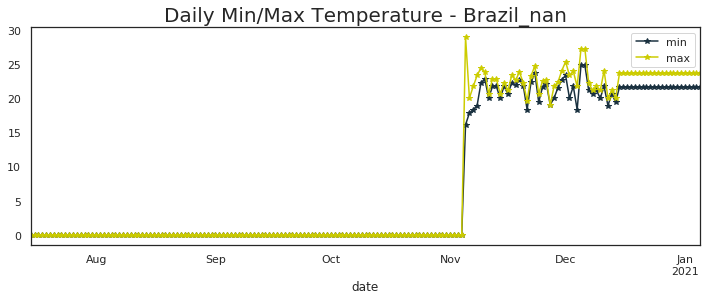

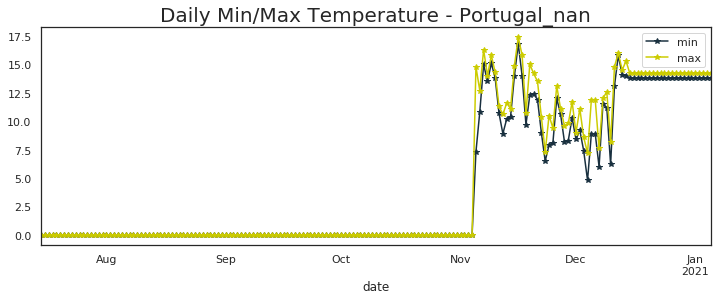

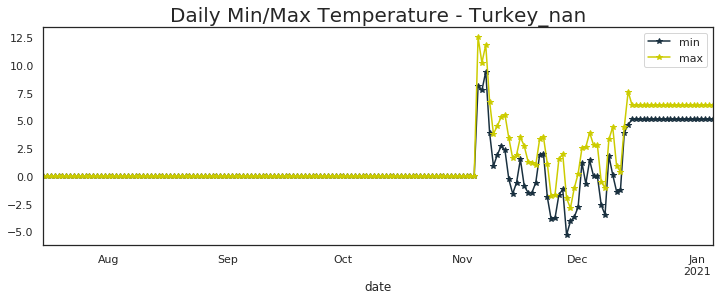

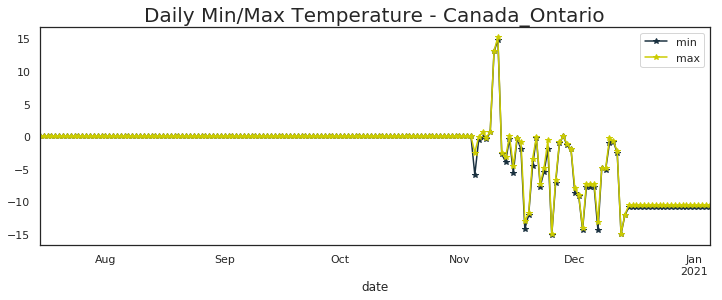

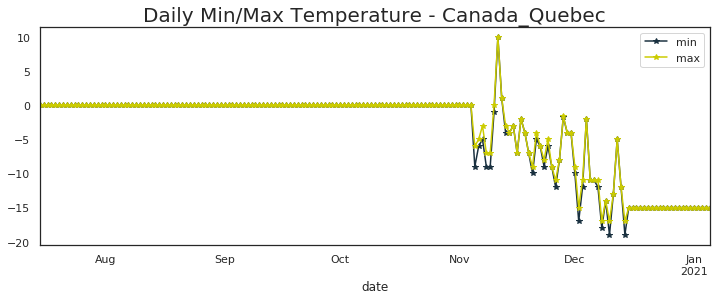

In [59]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [60]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                             min   max
region                                
United States_nan           17.8  17.8
India_nan                   22.0  31.0
Brazil_nan                  24.8  28.9
Russia_nan                   0.0   4.0
United Kingdom_nan          12.2  13.3
France_nan                  12.1  13.3
Turkey_nan                   9.4  12.5
Italy_nan                   12.9  19.1
Spain_nan                   12.6  14.0
Germany_nan                 10.0  12.0
Colombia_nan                 0.0   0.0
Argentina_nan                0.0   0.0
Mexico_nan                  15.1  15.1
Poland_nan                   8.9  10.6
Iran_nan                    11.0  27.0
South Africa_nan             0.0   0.0
Ukraine_nan                  0.0   0.0
Peru_nan                    24.6  29.9
Netherlands_nan             14.4  16.1
Indonesia_nan                0.0   0.0
Czechia_nan                  0.0   0.0
Belgium_nan                 13.7  14.5
Romania_nan                 

### Kalman X Days Ahead Prediction

In [61]:
%%R

#install.packages('reshape')

NULL


In [62]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [63]:
all_new=%R all_new

In [64]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

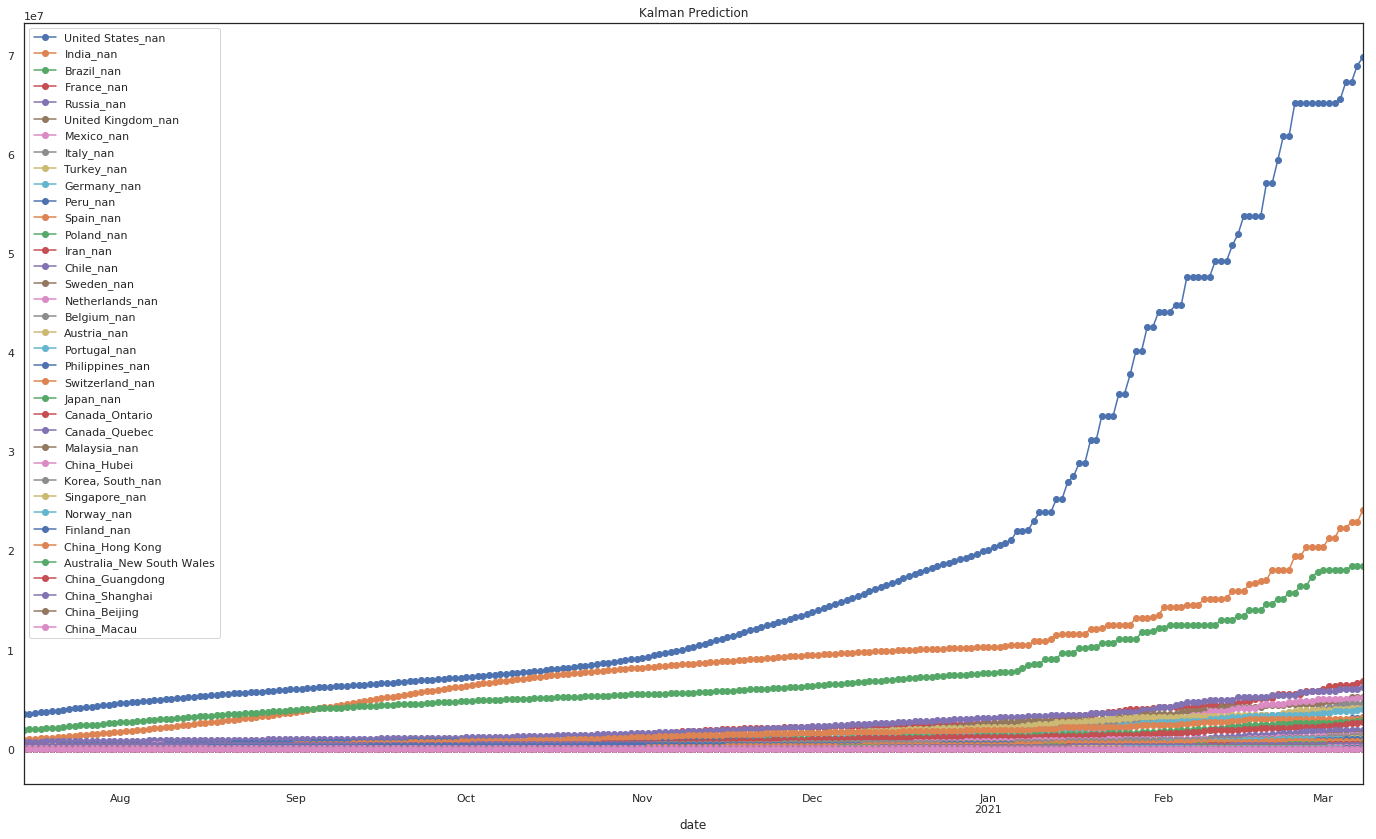

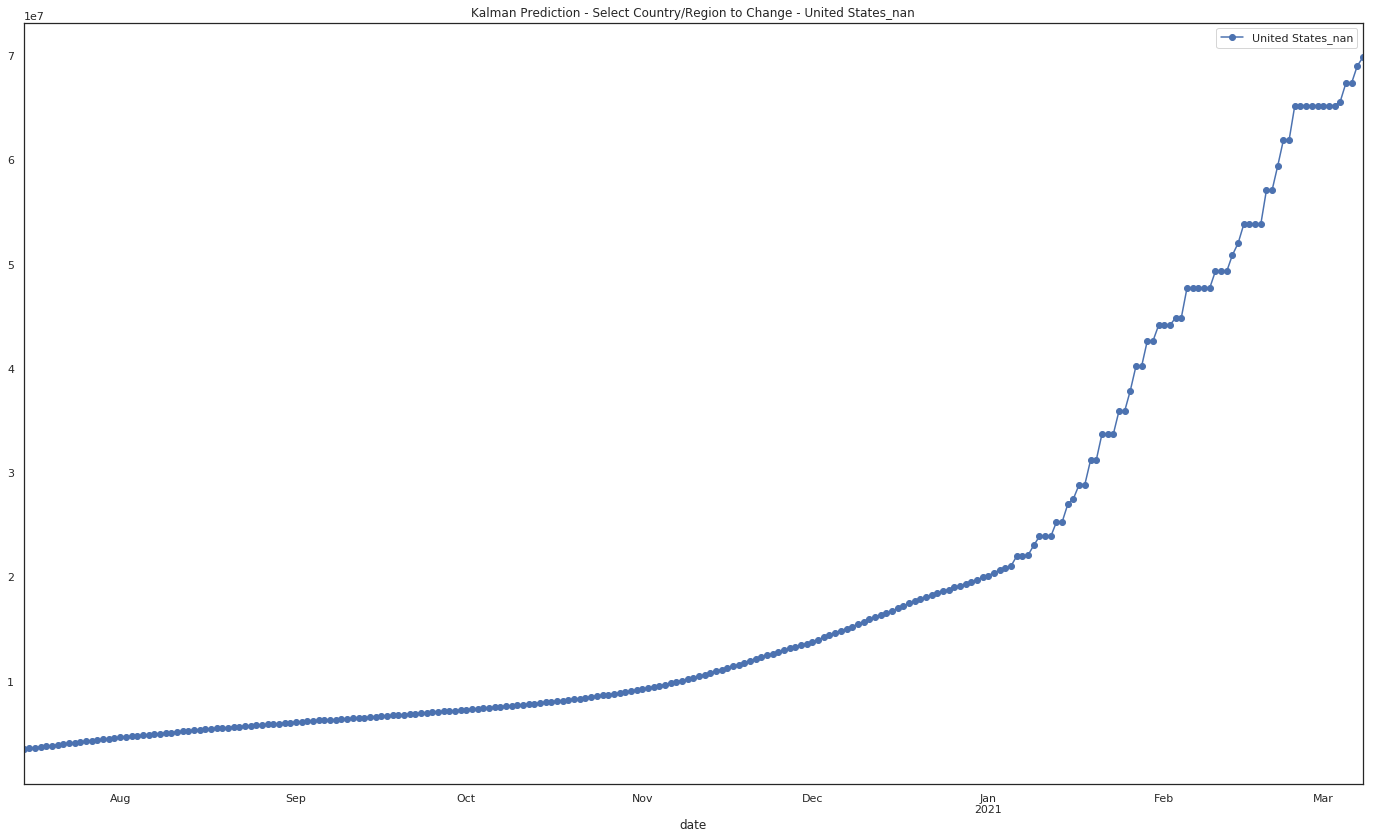

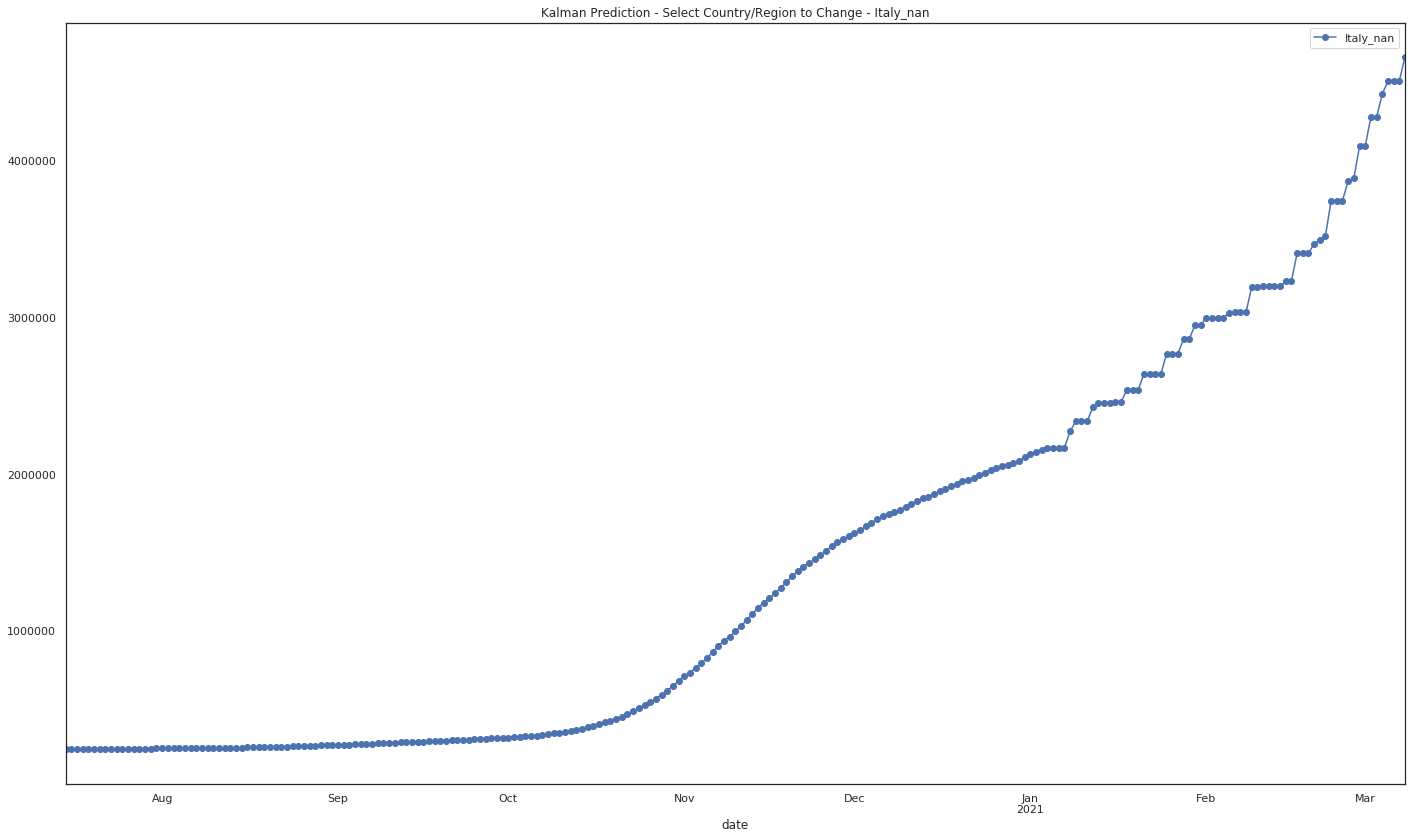

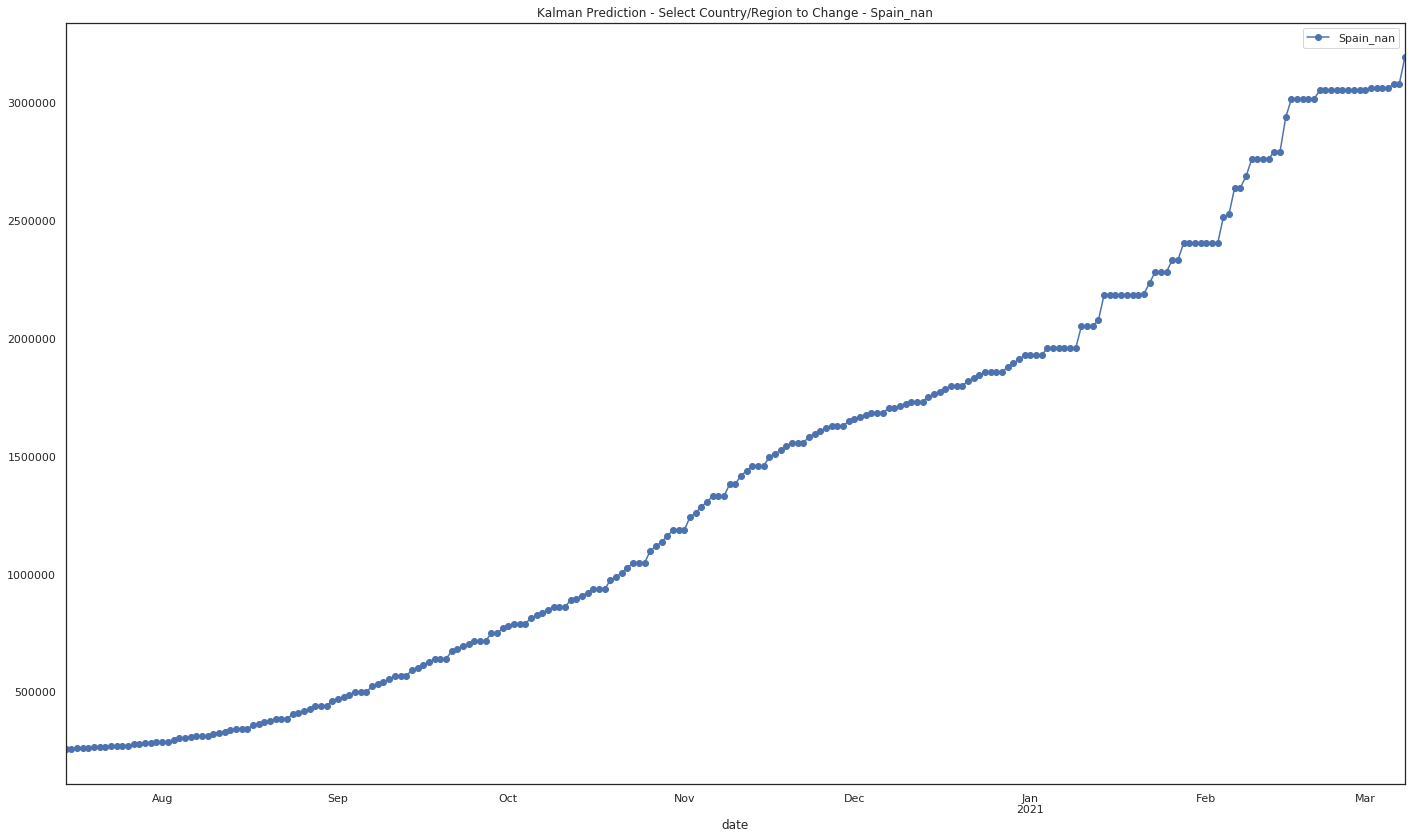

In [65]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


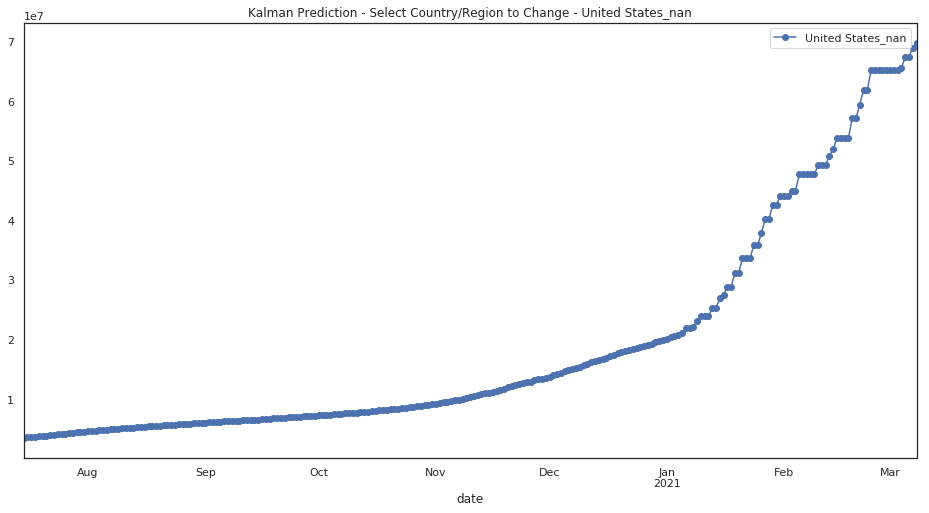

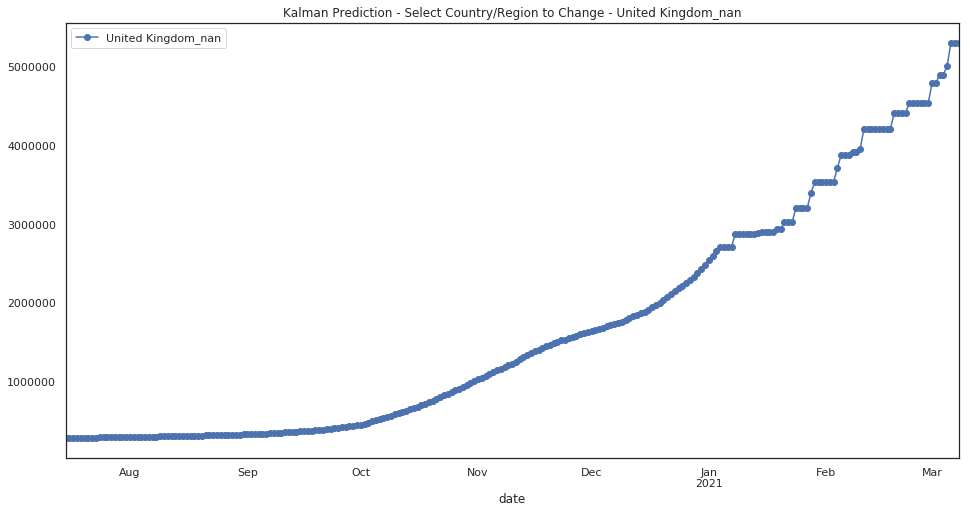

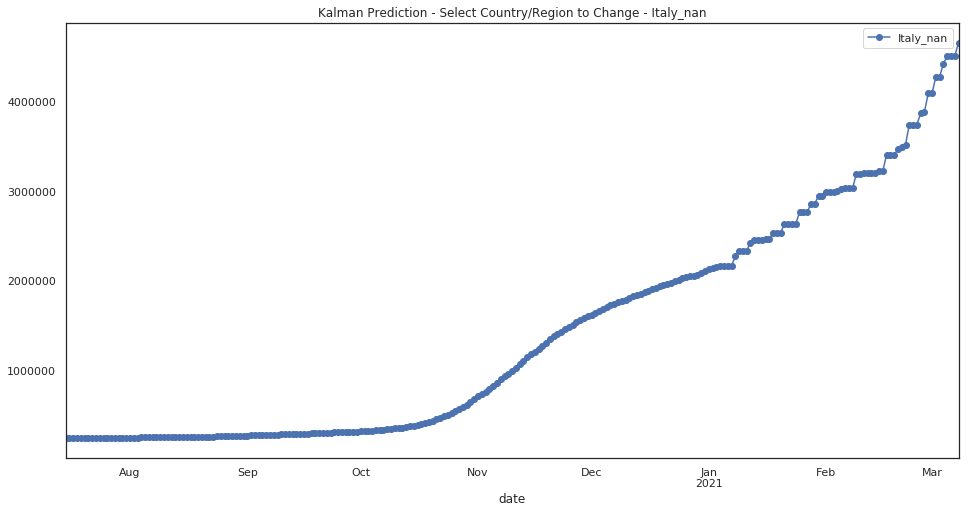

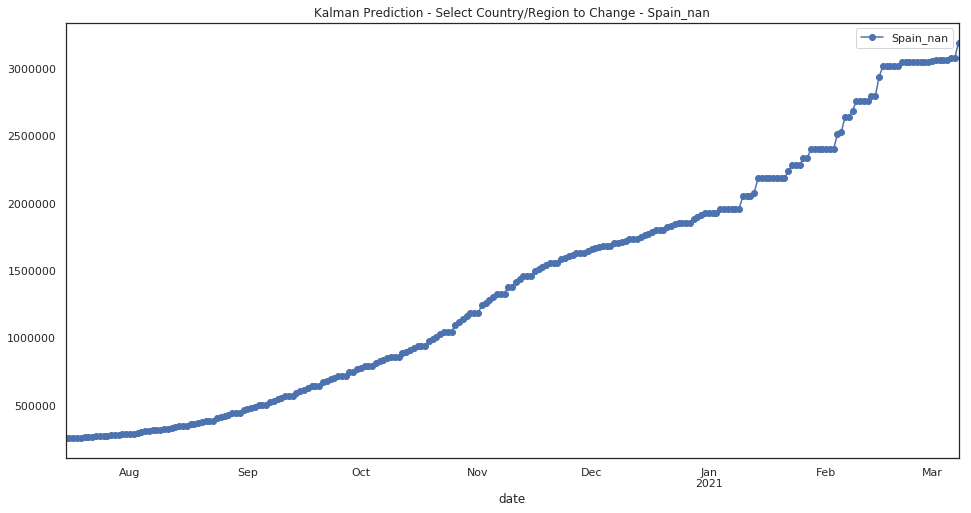

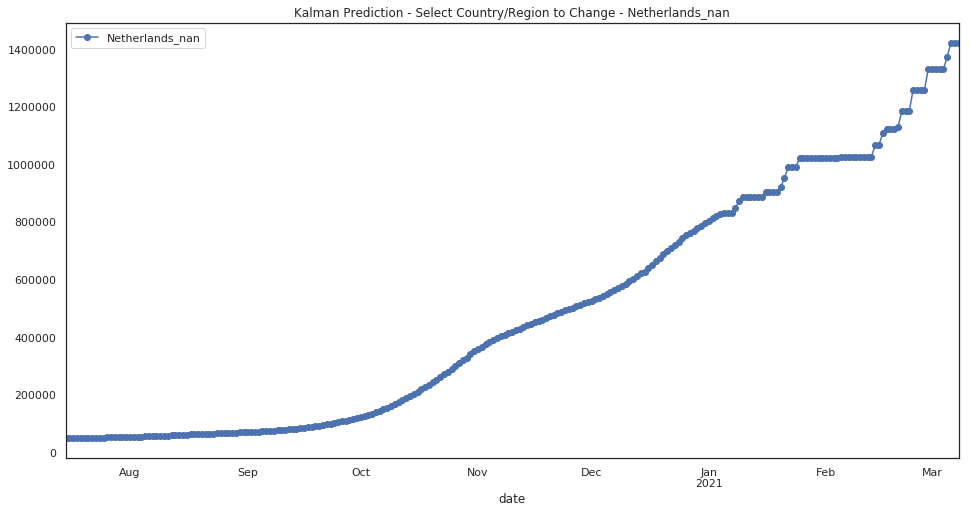

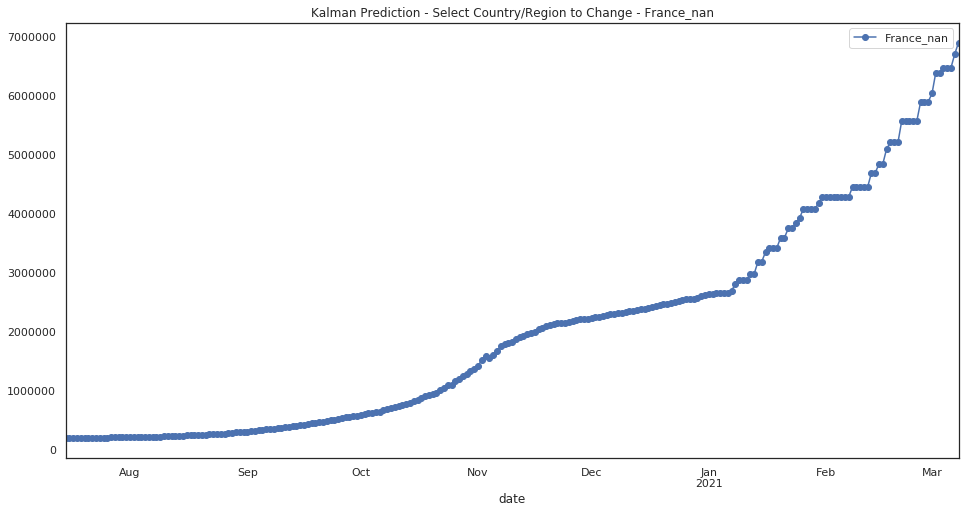

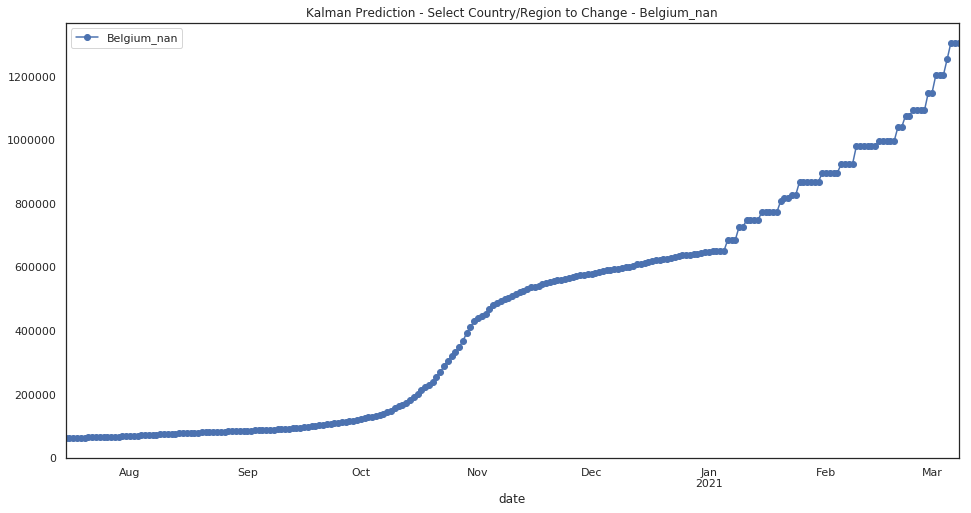

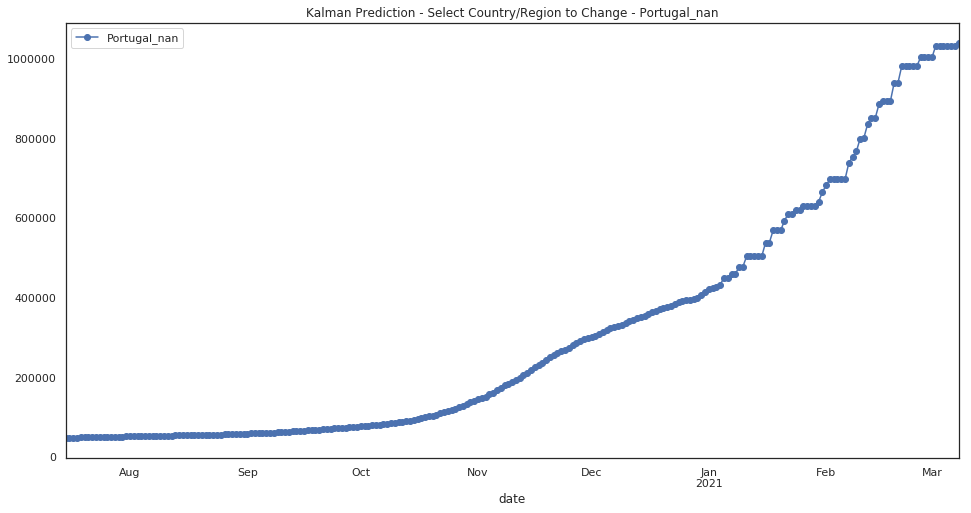

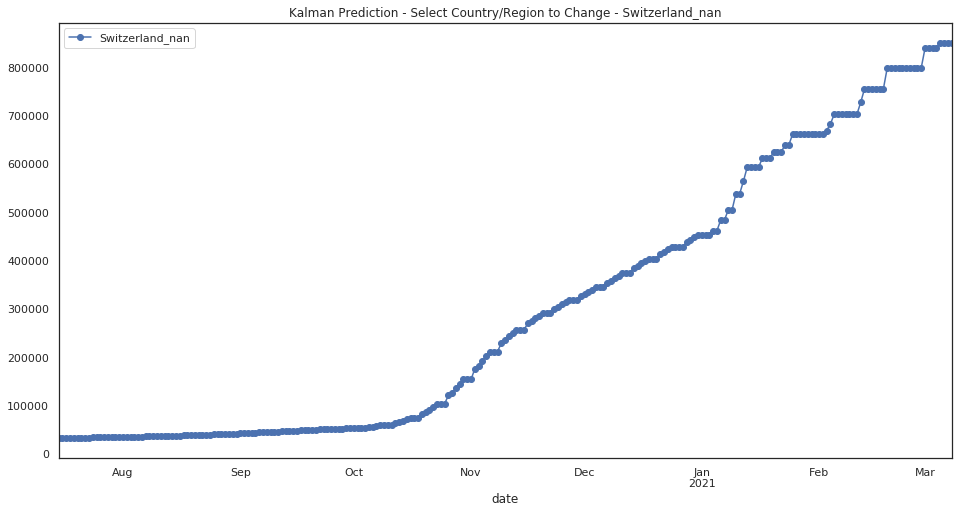

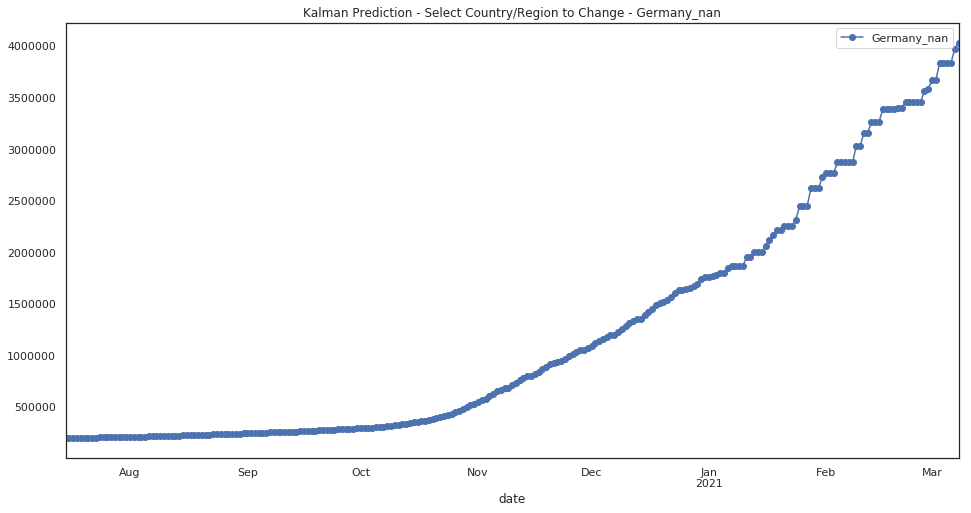

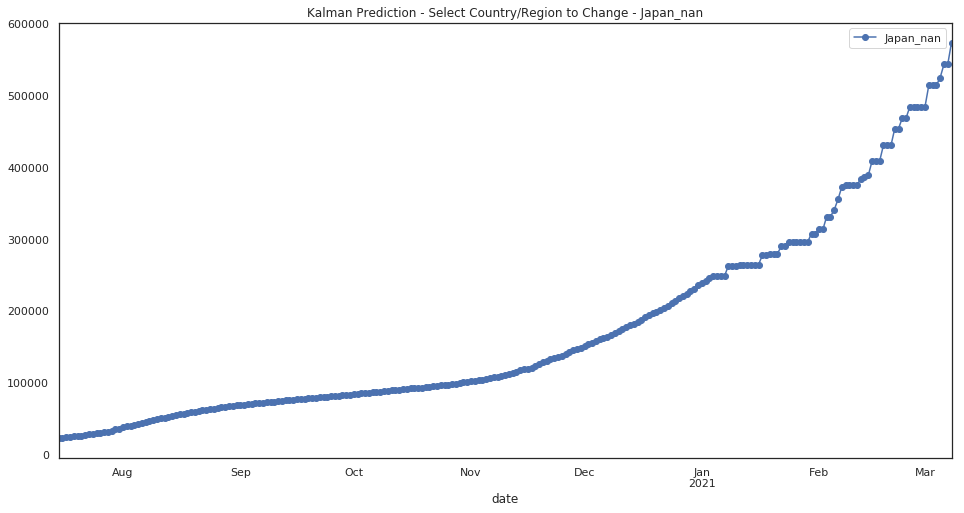

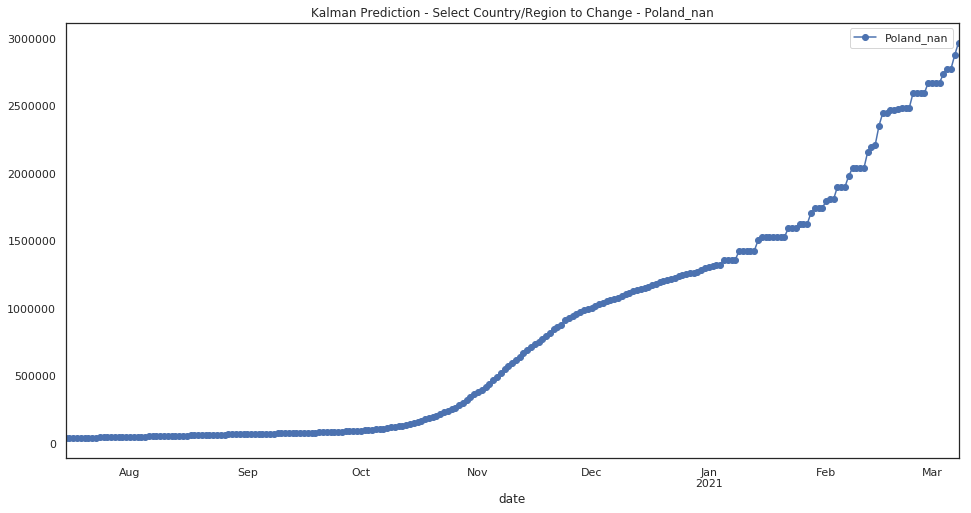

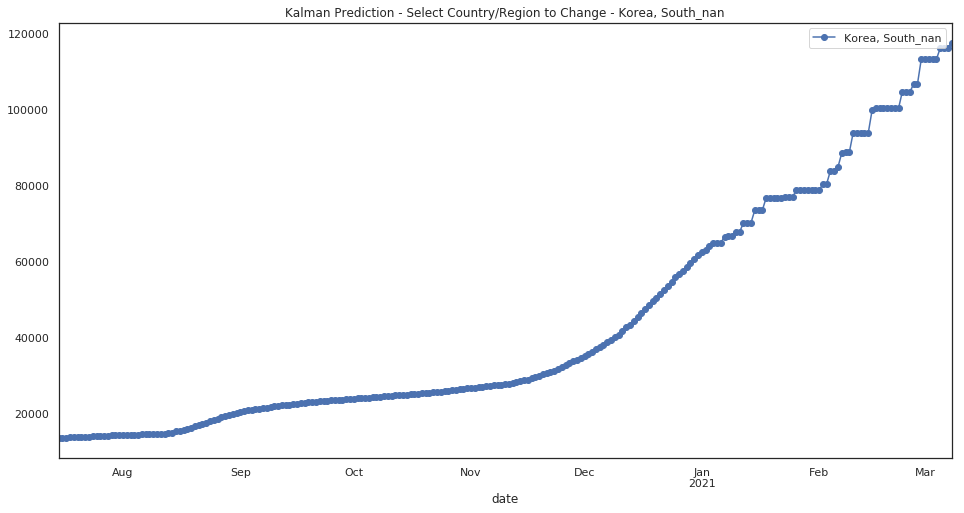

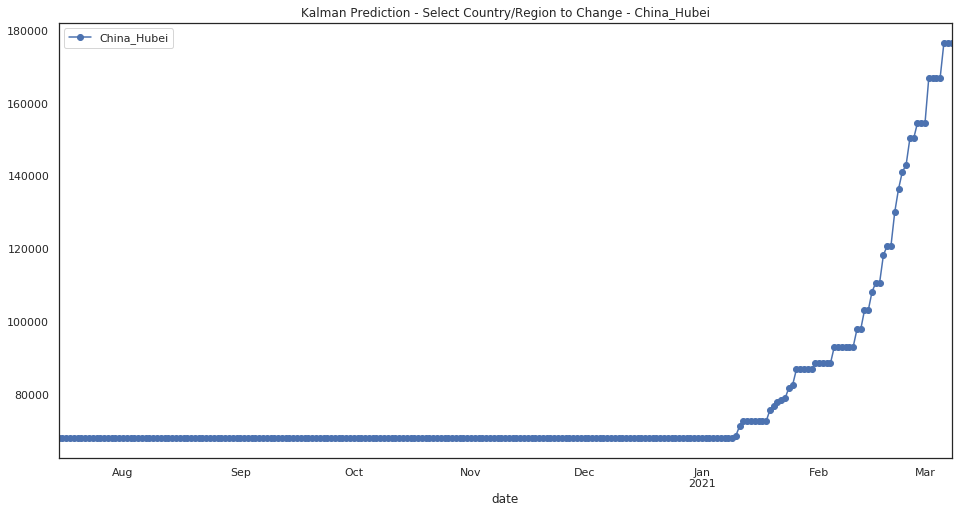

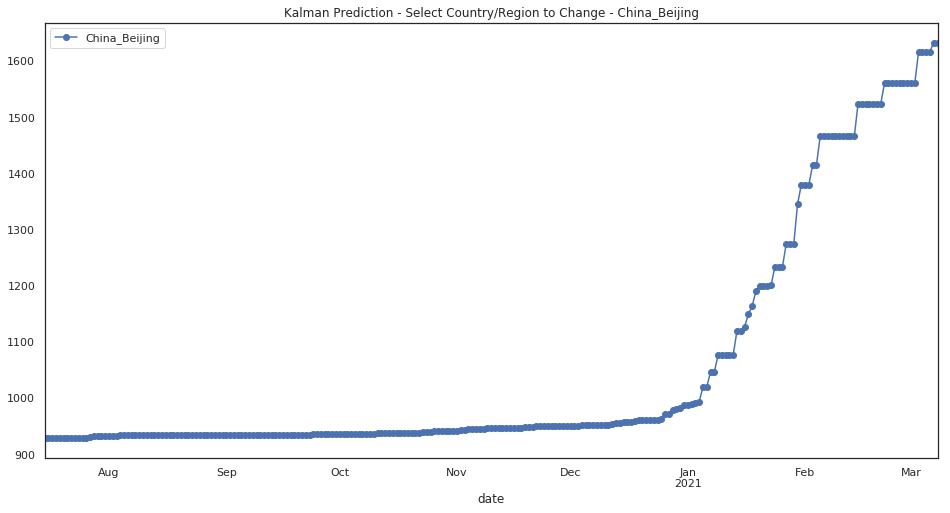

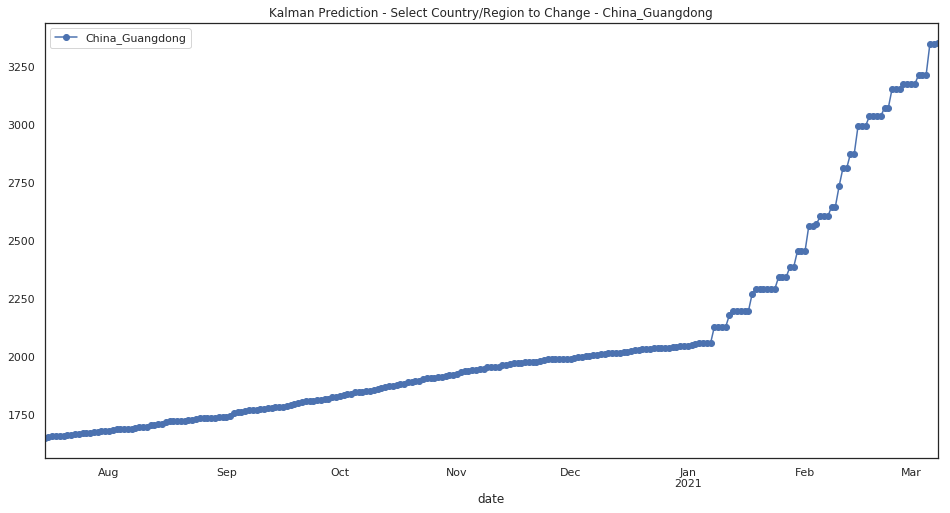

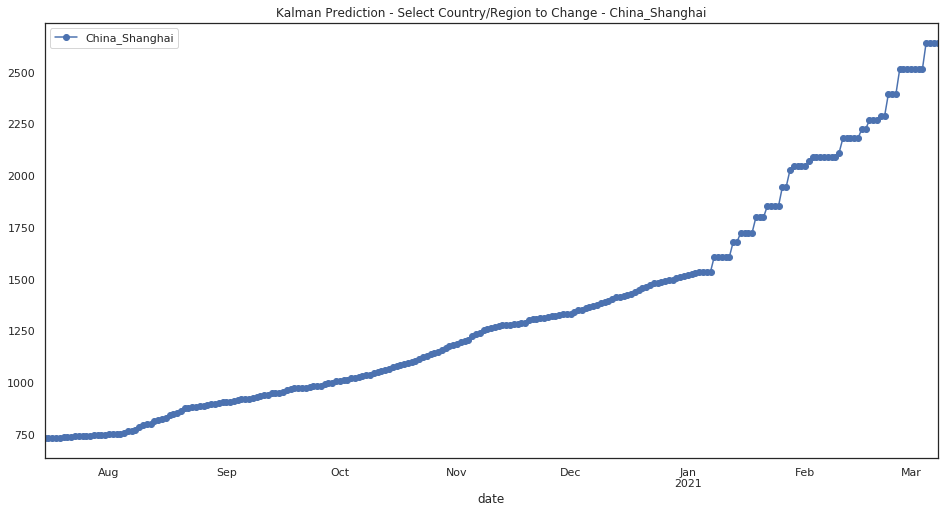

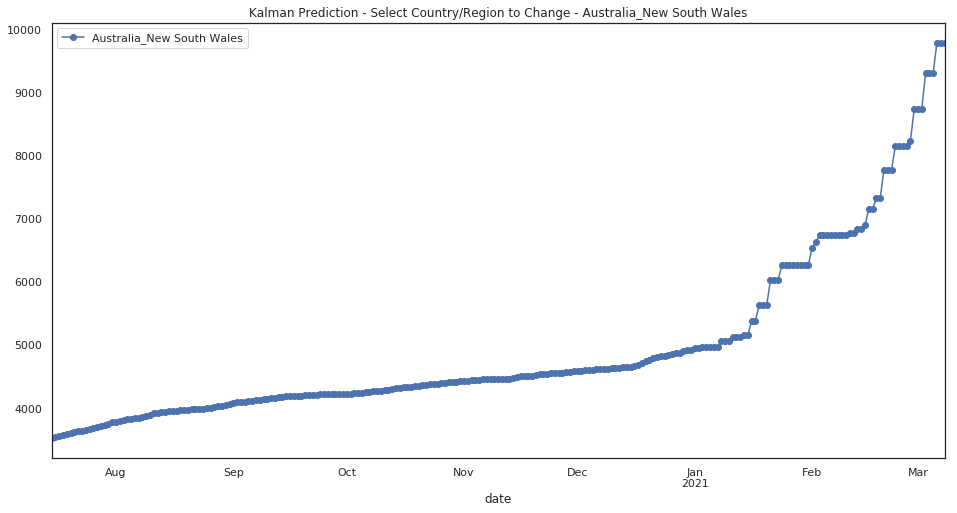

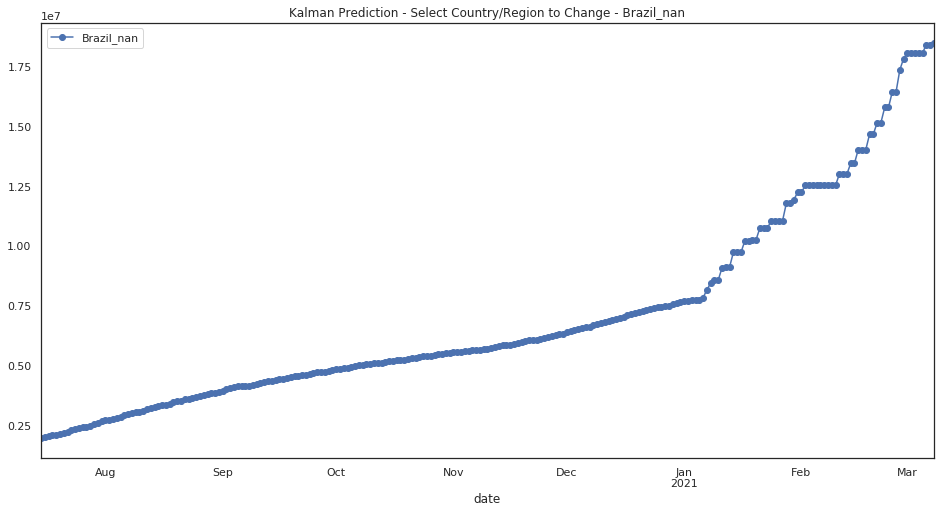

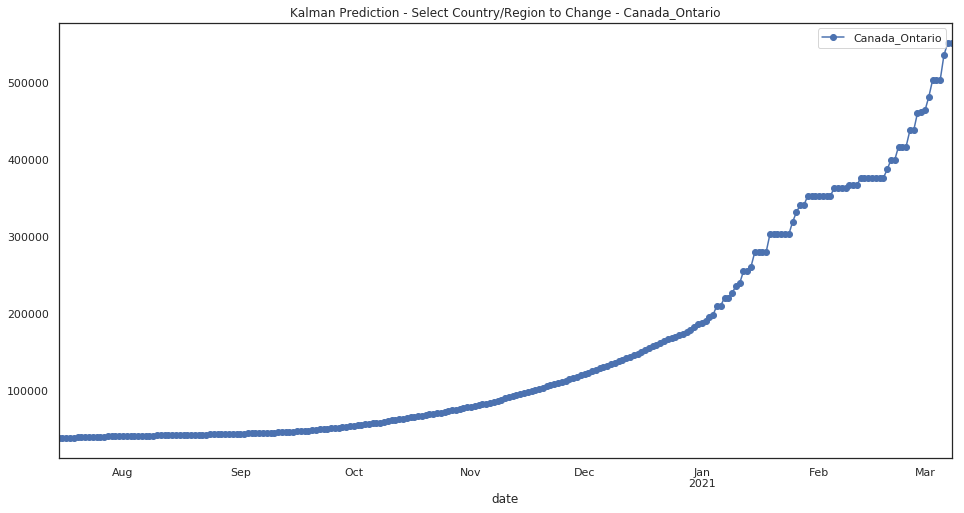

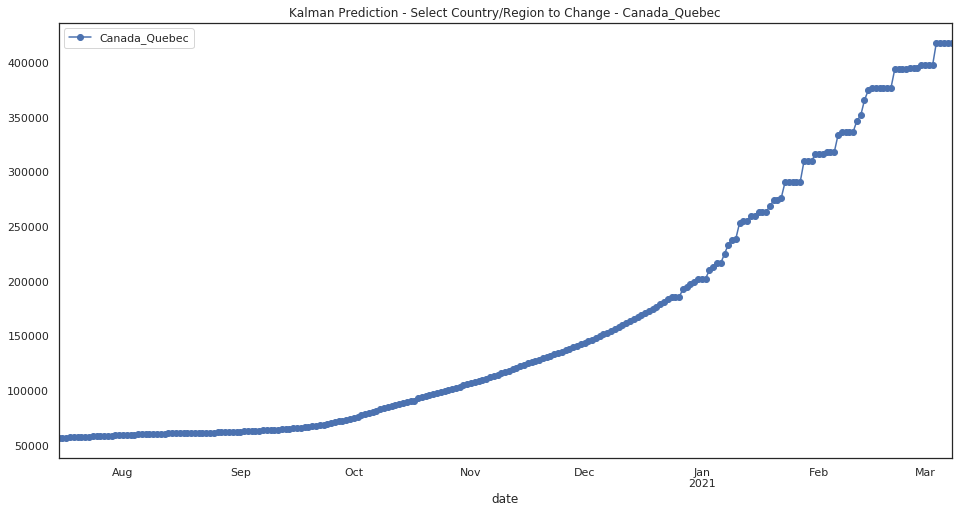

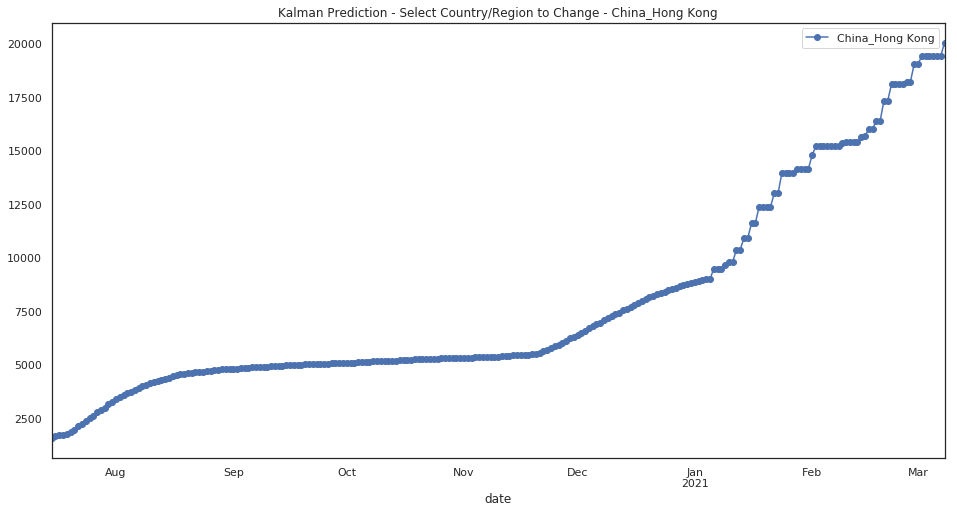

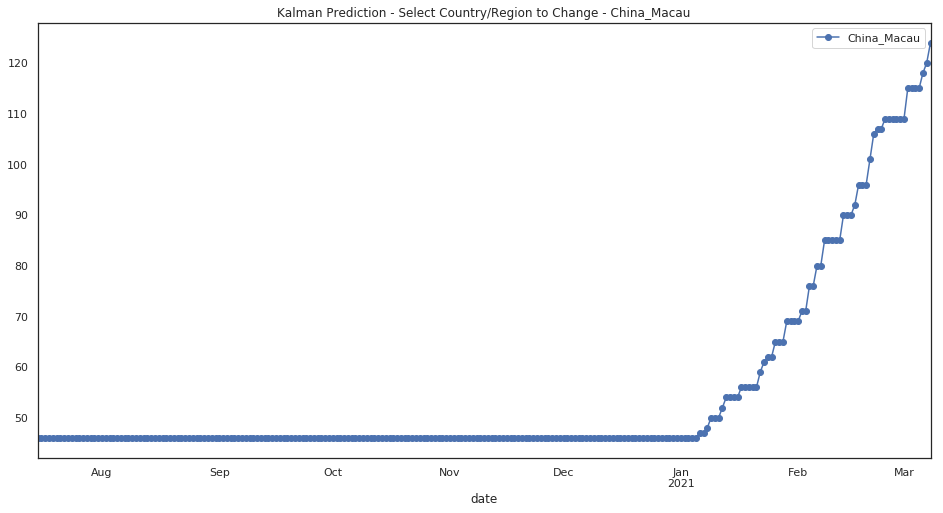

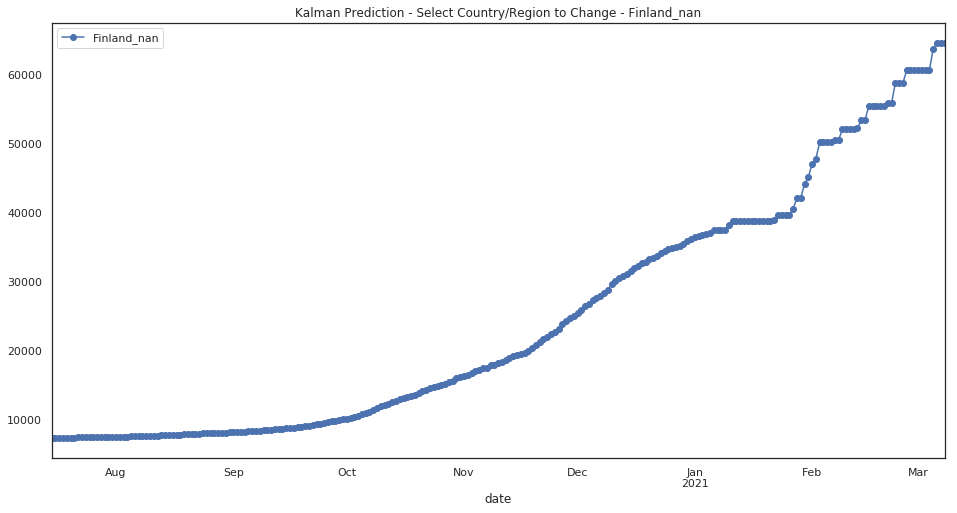

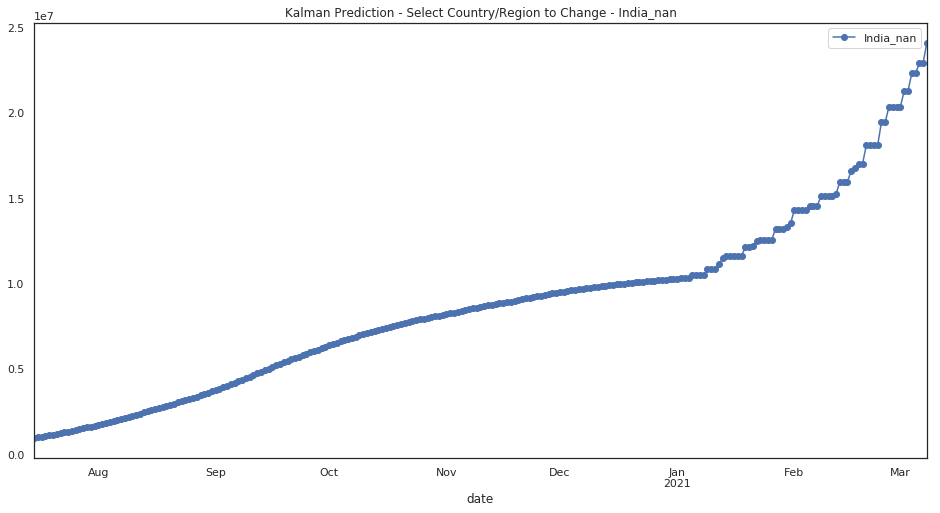

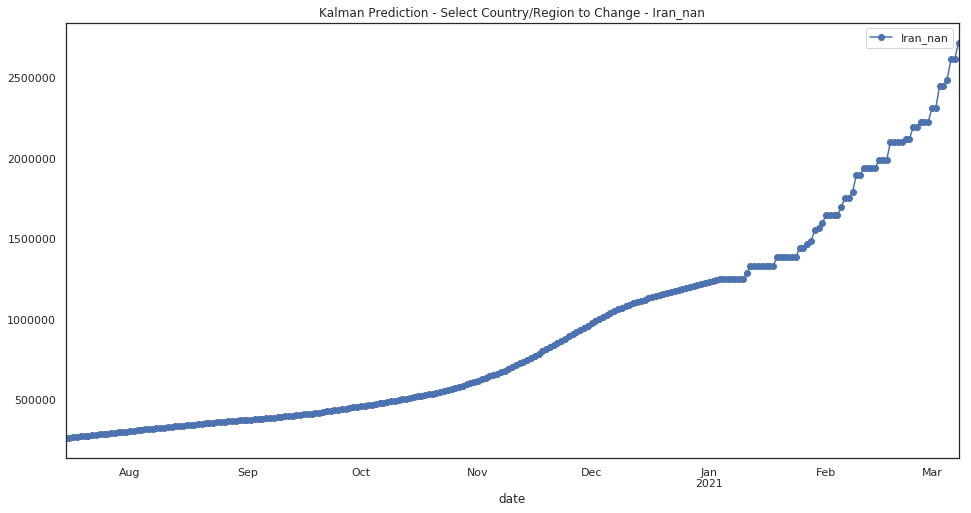

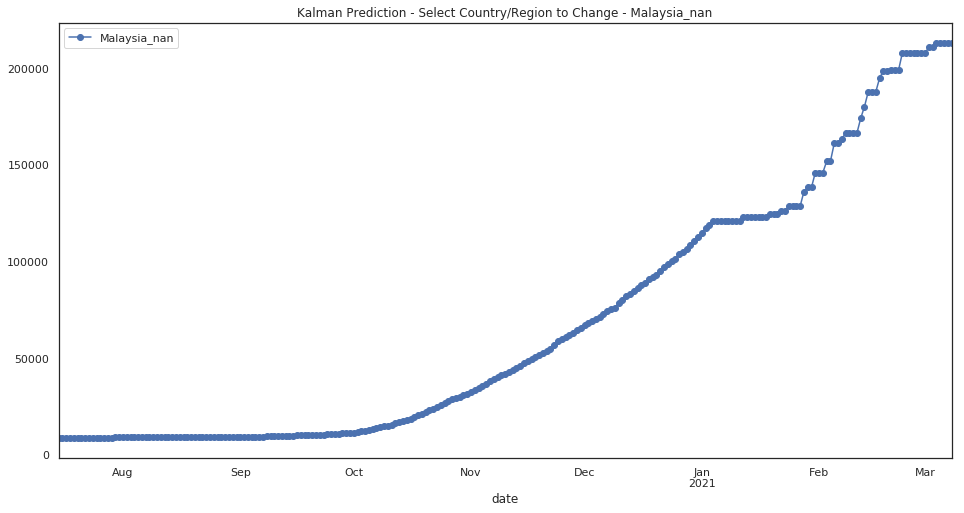

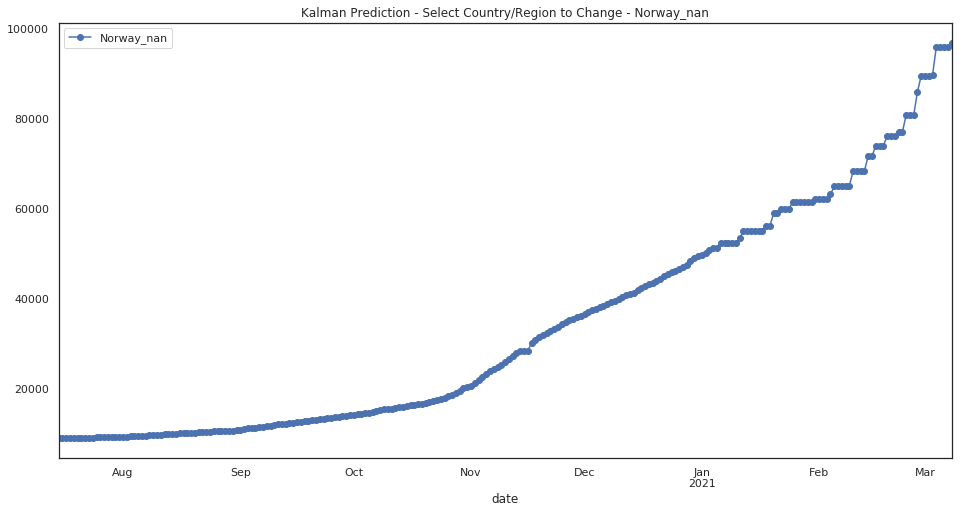

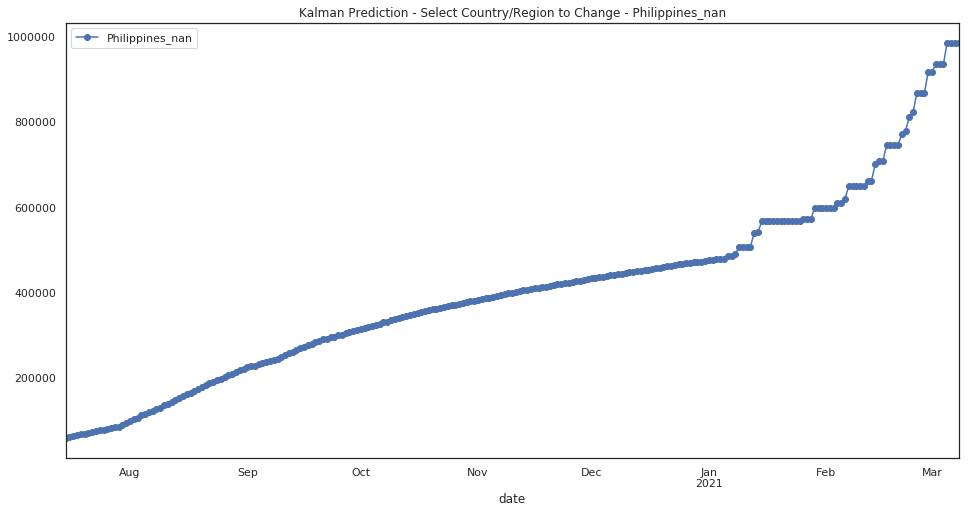

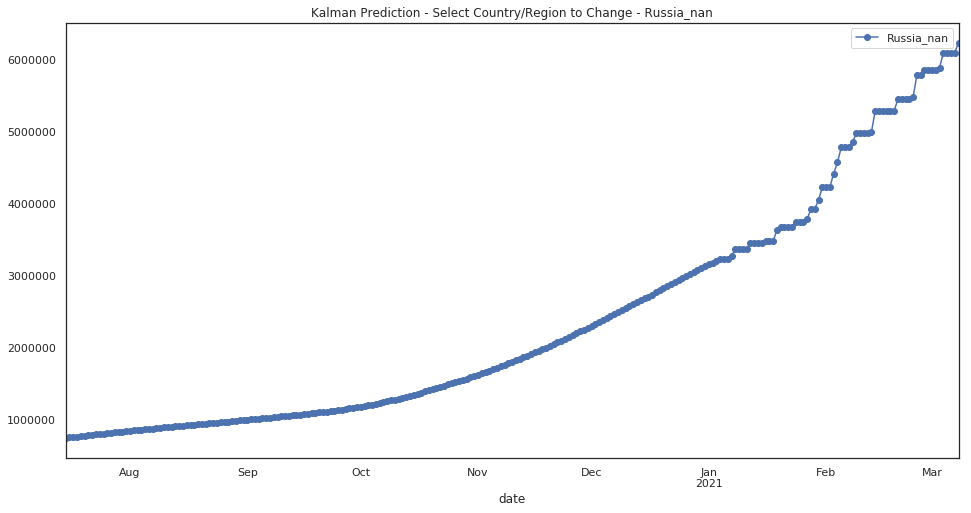

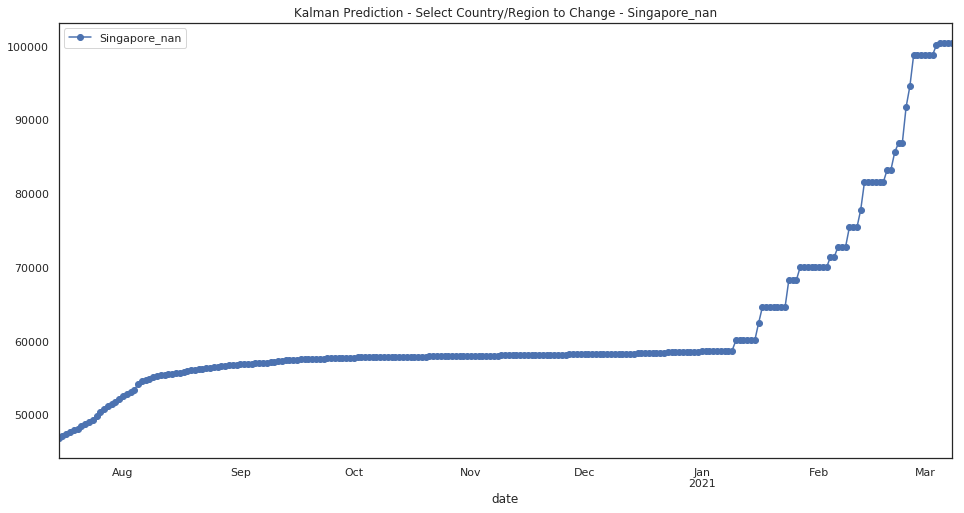

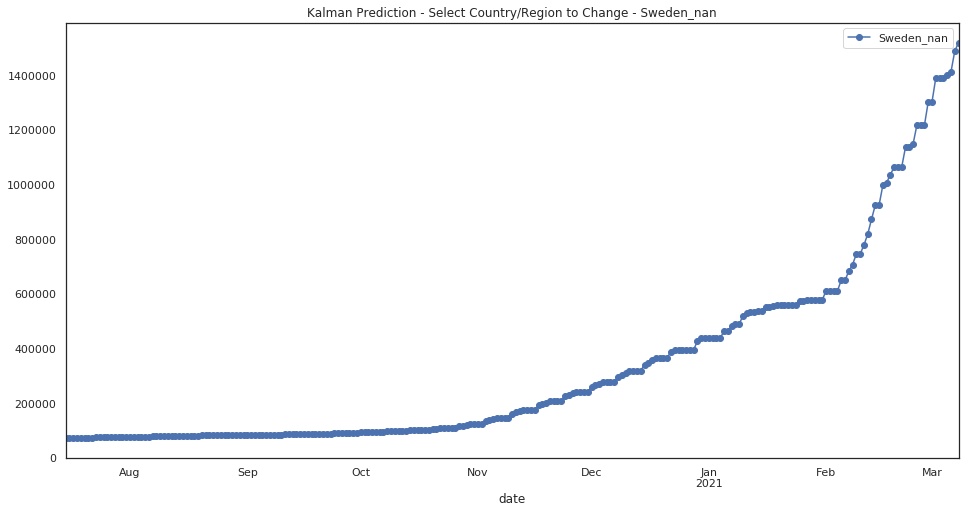

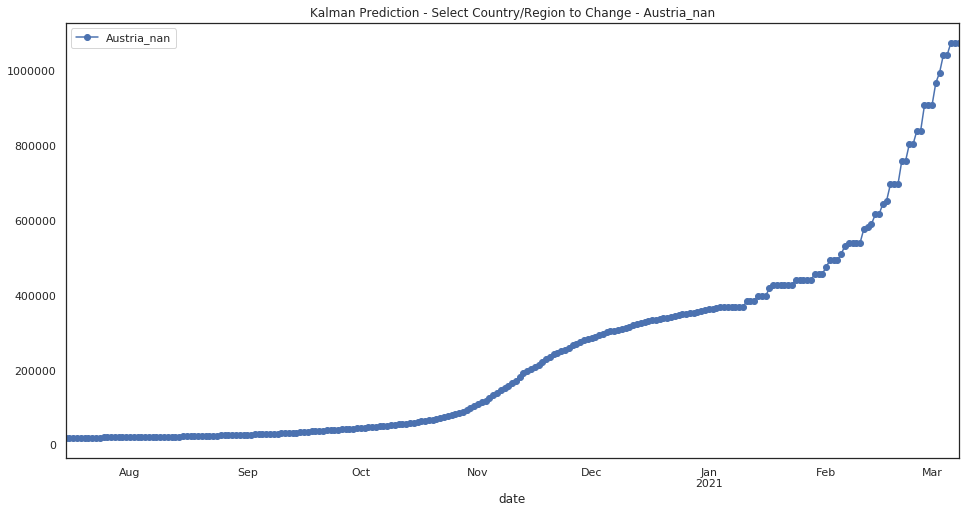

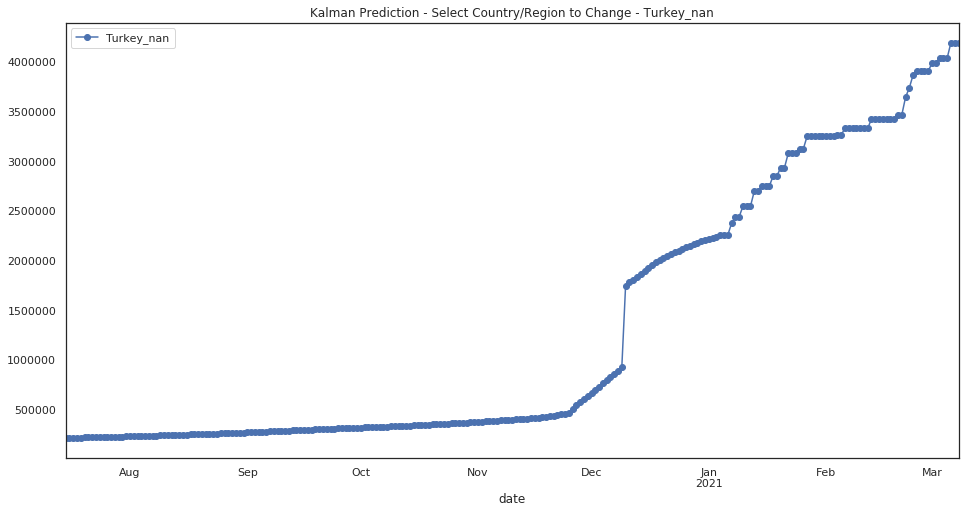

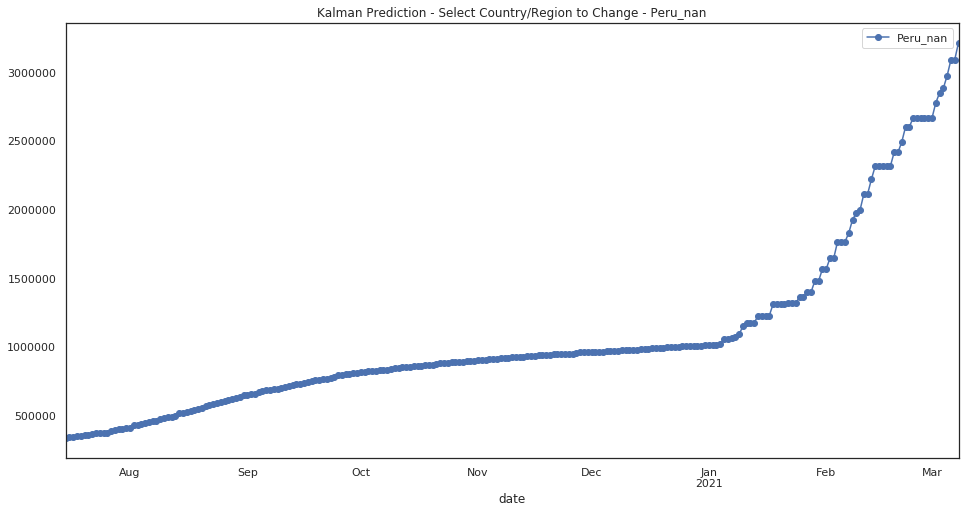

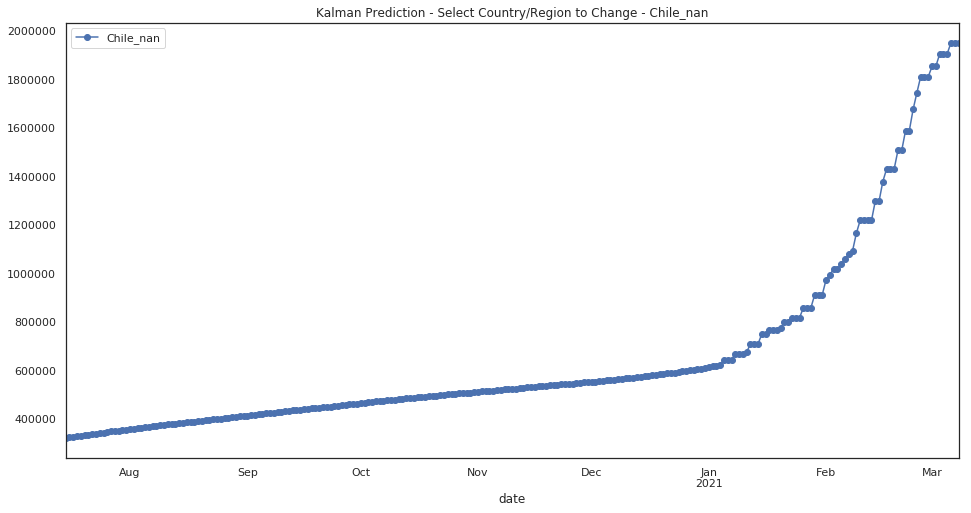

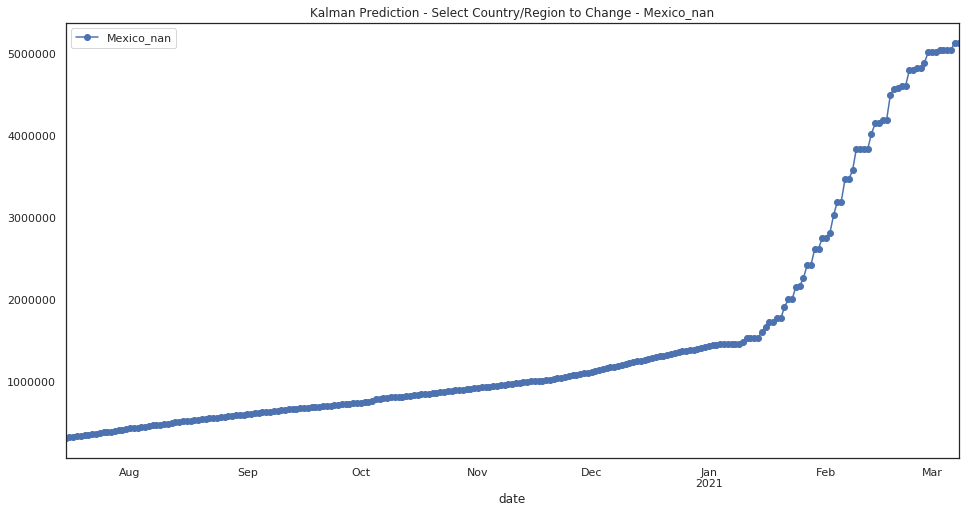

In [66]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [67]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2021-03-08 00:00:00
dtype: object


0  pred_confirmed
United States_nan                           NaN      69826867.0
India_nan                                   NaN      24121864.0
Brazil_nan                                  NaN      18522133.0
France_nan                                  NaN       6894652.0
Russia_nan                                  NaN       6235389.0
United Kingdom_nan                          NaN       5300064.0
Mexico_nan                                  NaN       5130101.0
Italy_nan                                   NaN       4660267.0
Turkey_nan                                  NaN       4194136.0
Colombia_nan                                NaN       4129414.0
Germany_nan                                 NaN       4032844.0
Argentina_nan                               NaN       3522578.0
Peru_nan                                    NaN       3216827.0
Spain_nan                                   NaN       3191374.0
Poland_nan                                  NaN       2968653.0
Iran_nan                                    NaN       2718273.0
Ukraine_nan                                 NaN       2561745.0
South Africa_nan                            NaN       2213750.0
Chile_nan                                   NaN       1951712.0
Czechia_nan                                 NaN       1685221.0
Romania_nan                                 NaN       1623490.0
Indonesia_nan                               NaN       1604061.0
Sweden_nan                                  NaN       1519676.0
Netherlands_nan                             NaN       1422737.0
Iraq_nan                                    NaN       1391571.0
Belgium_nan                                 NaN       1305655.0
Israel_nan                                  NaN       1153626.0
Morocco_nan                                 NaN       1109566.0
Austria_nan                                 NaN       1074518.0
Portugal_nan                                NaN       1040319.0
...                                         ...             ...
Canada_Prince Edward Island                 NaN           256.0
Dominica_nan                                NaN           252.0
United Kingdom_British Virgin Islands       NaN           157.0
China_Ningxia                               NaN           139.0
Australia_Northern Territory                NaN           137.0
China_Macau                                 NaN           124.0
Timor-Leste_nan                             NaN           117.0
Fiji_nan                                    NaN           103.0
Canada_Yukon                                NaN           101.0
United Kingdom_Falkland Islands (Malvinas)  NaN            96.0
Denmark_Greenland                           NaN            93.0
United Kingdom_Anguilla                     NaN            87.0
Saint Kitts and Nevis_nan                   NaN            80.0
Canada_Northwest Territories                NaN            63.0
Laos_nan                                    NaN            60.0
France_New Caledonia                        NaN            59.0
Holy See_nan                                NaN            53.0
China_Qinghai                               NaN            49.0
France_Saint Pierre and Miquelon            NaN            35.0
Solomon Islands_nan                         NaN            35.0
Canada_Repatriated Travellers               NaN            28.0
United Kingdom_Montserrat                   NaN            25.0
France_Wallis and Futuna                    NaN            20.0
Canada_Grand Princess                       NaN            17.0
MS Zaandam_nan                              NaN             9.0
Marshall Islands_nan                        NaN             4.0
Samoa_nan                                   NaN             2.0
China_Tibet                                 NaN             1.0
Vanuatu_nan                                 NaN             1.0
Canada_Diamond Princess                     NaN             0.0

[272 rows x 2 columns]

In [68]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [69]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [70]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [71]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [72]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [73]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-07-15          38806.0      11614.0      26431.0       9098.0   
2020-07-16          38873.0      11700.0      26940.0       9111.0   
2020-07-17          35060.0       3851.0      21355.0        877.0   
2020-07-18          35219.0       3906.0      21948.0        880.0   
2020-07-19          35279.0       4008.0      22985.0        880.0   
2020-07-20          35453.0       4090.0      23582.0        880.0   
2020-07-21          35493.0       4171.0      24178.0        884.0   
2020-07-22          35605.0       4290.0      24774.0        884.0   
2020-07-23          35965.0       4466.0      25446.0        889.0   
2020-07-24          36064.0       4509.0      26115.0        908.0   
2020-07-25          36093.0       4587.0      26739.0        897.0   
2020-07-26          36198.0       4767.0      27334.0        913.0   
2020-07-27          36313.0       4796.0      27943.0        921.0   
2020-07-28          36416.0       4934.0      28579.0        907.0   
2020-07-29          36527.0       5058.0      29201.0        935.0   
2020-07-30          36599.0       5163.0      29806.0        918.0   
2020-07-31          36724.0       5263.0      30374.0        922.0   
2020-08-01          36780.0       5388.0      30927.0        925.0   
2020-08-02          36763.0       5458.0      31446.0        940.0   
2020-08-03          36790.0       5567.0      31946.0        948.0   
2020-08-04          36828.0       5729.0      32477.0        937.0   
2020-08-05          36878.0       5834.0      33034.0        941.0   
2020-08-06          36988.0       5957.0      33614.0        961.0   
2020-08-07          37084.0       6112.0      34161.0        944.0   
2020-08-08          37132.0       6231.0      34695.0        955.0   
2020-08-09          37162.0       6377.0      35173.0        975.0   
2020-08-10          37218.0       6493.0      35698.0        978.0   
2020-08-11          37323.0       6642.0      36211.0        963.0   
2020-08-12          37411.0       6772.0      36695.0        987.0   
2020-08-13          37492.0       6926.0      37192.0        977.0   
...                     ...          ...          ...          ...   
2021-02-08          73861.0      83032.0     167816.0      11281.0   
2021-02-09          75158.0      84216.0     167816.0      11281.0   
2021-02-10          74940.0      85987.0     167816.0      11975.0   
2021-02-11          74940.0      89931.0     169513.0      11975.0   
2021-02-12          74940.0      92566.0     170986.0      12689.0   
2021-02-13          78460.0      94914.0     170350.0      12689.0   
2021-02-14          80400.0      97776.0     170440.0      12689.0   
2021-02-15          79185.0      99199.0     174916.0      12698.0   
2021-02-16          79862.0     100380.0     180114.0      13566.0   
2021-02-17          82810.0     104899.0     185554.0      13942.0   
2021-02-18          85828.0     106367.0     187916.0      13942.0   
2021-02-19          85685.0     106245.0     185384.0      13942.0   
2021-02-20          87297.0     107127.0     193029.0      14532.0   
2021-02-21          90940.0     107127.0     197163.0      15153.0   
2021-02-22          91254.0     107652.0     194666.0      15153.0   
2021-02-23          94839.0     108481.0     198184.0      15153.0   
2021-02-24          98091.0     108965.0     199999.0      15153.0   
2021-02-25          97046.0     115001.0     209658.0      15153.0   
2021-02-26          97000.0     117286.0     216004.0      15153.0   
2021-02-27          99974.0     115564.0     211805.0      15153.0   
2021-02-28         101985.0     118337.0     220979.0      15153.0   
2021-03-01         101700.0     119490.0     232672.0      15315.0   
2021-03-02         102158.0     123430.0     234631.0      16060.0   
2021-03-03         104015.0     130208.0     233576.0      16060.0   
2021-03-04

In [74]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [75]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'France_nan',
 'Russia_nan',
 'United Kingdom_nan',
 'Mexico_nan',
 'Italy_nan',
 'Turkey_nan',
 'Colombia_nan',
 'Germany_nan',
 'Argentina_nan',
 'Peru_nan',
 'Spain_nan',
 'Poland_nan',
 'Iran_nan',
 'Ukraine_nan',
 'South Africa_nan',
 'Chile_nan',
 'Czechia_nan',
 'Romania_nan',
 'Indonesia_nan',
 'Sweden_nan',
 'Netherlands_nan',
 'Iraq_nan',
 'Belgium_nan',
 'Israel_nan',
 'Morocco_nan',
 'Austria_nan',
 'Portugal_nan',
 'Philippines_nan',
 'Bangladesh_nan',
 'Saudi Arabia_nan',
 'Serbia_nan',
 'Switzerland_nan',
 'Pakistan_nan',
 'Hungary_nan',
 'United Arab Emirates_nan',
 'Ecuador_nan',
 'Japan_nan',
 'Jordan_nan',
 'Armenia_nan',
 'Canada_Ontario',
 'Bulgaria_nan',
 'Azerbaijan_nan',
 'Nepal_nan',
 'Egypt_nan',
 'Costa Rica_nan',
 'Panama_nan',
 'Ireland_nan',
 'Dominican Republic_nan',
 'Canada_Quebec',
 'Honduras_nan',
 'Georgia_nan',
 'Lithuania_nan',
 'Kazakhstan_nan',
 'Bolivia_nan',
 'Croatia_nan',
 'Greece_nan',
 'Be

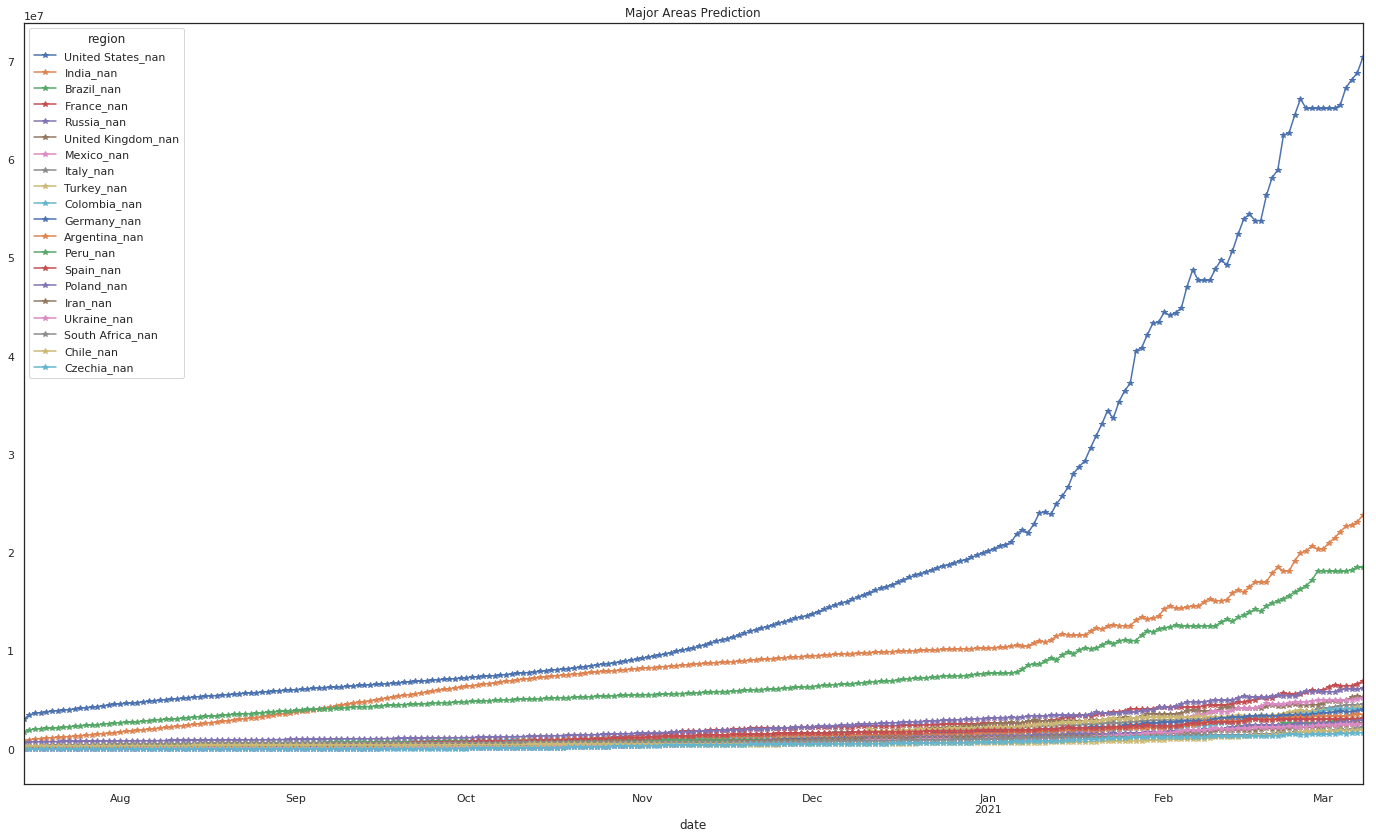

In [76]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

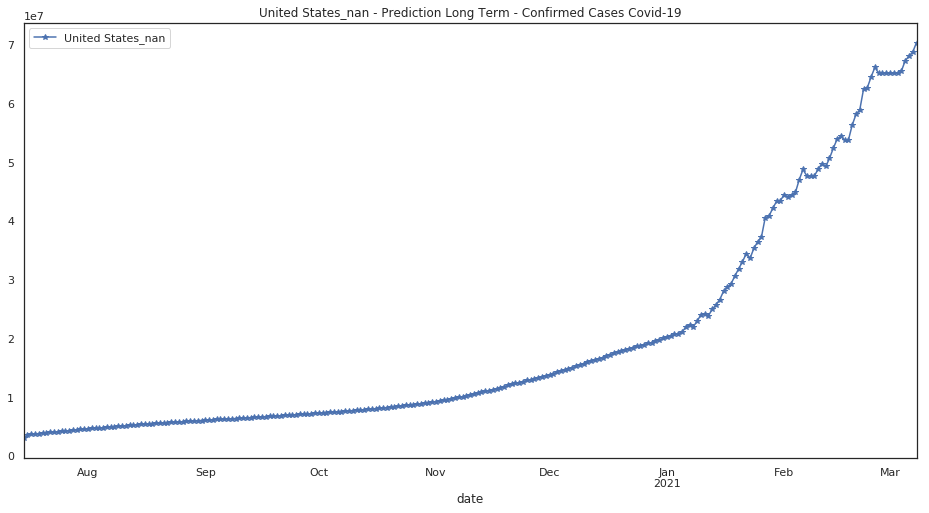

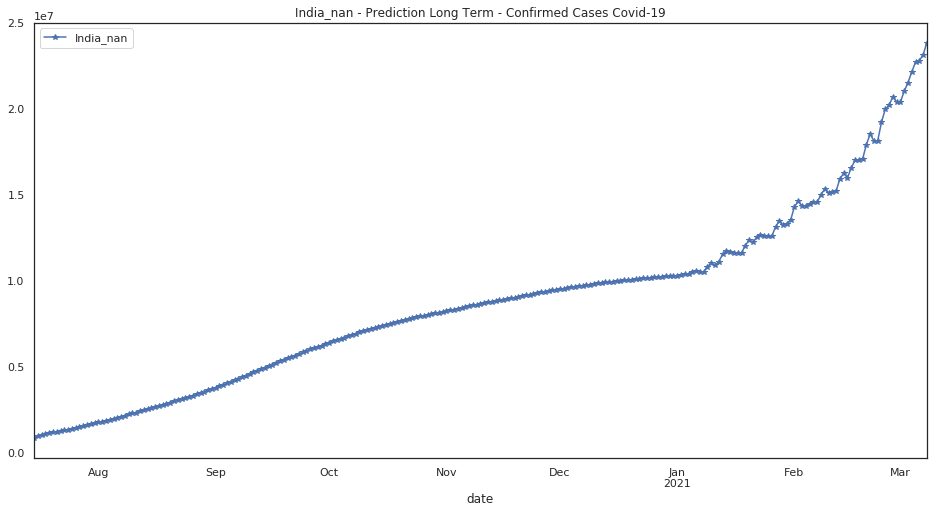

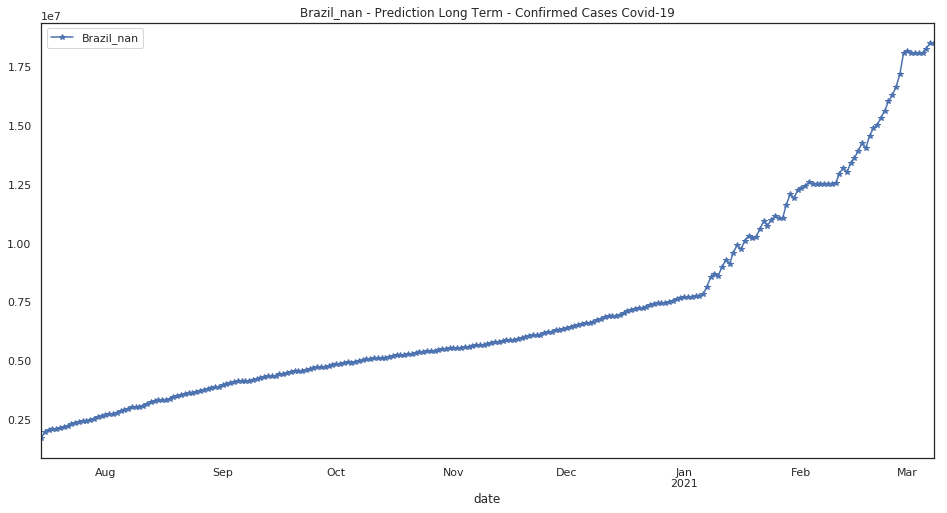

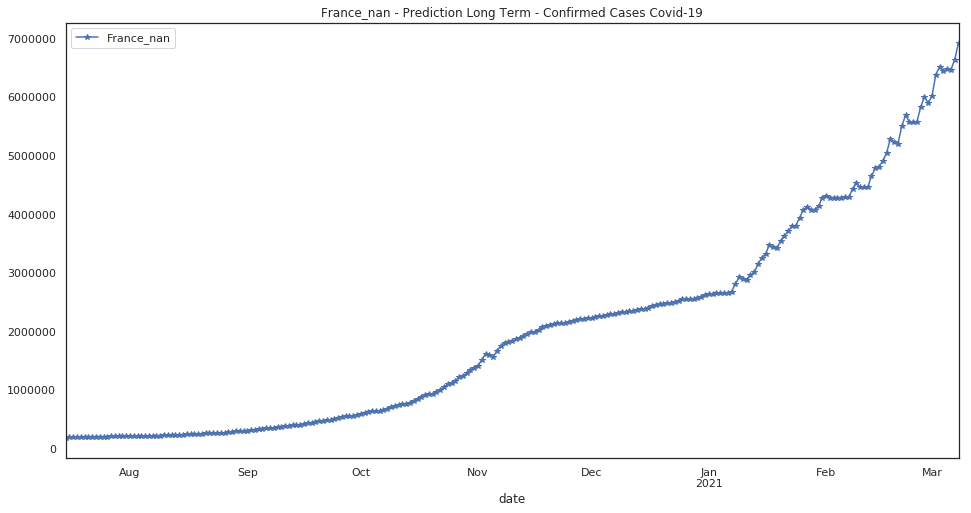

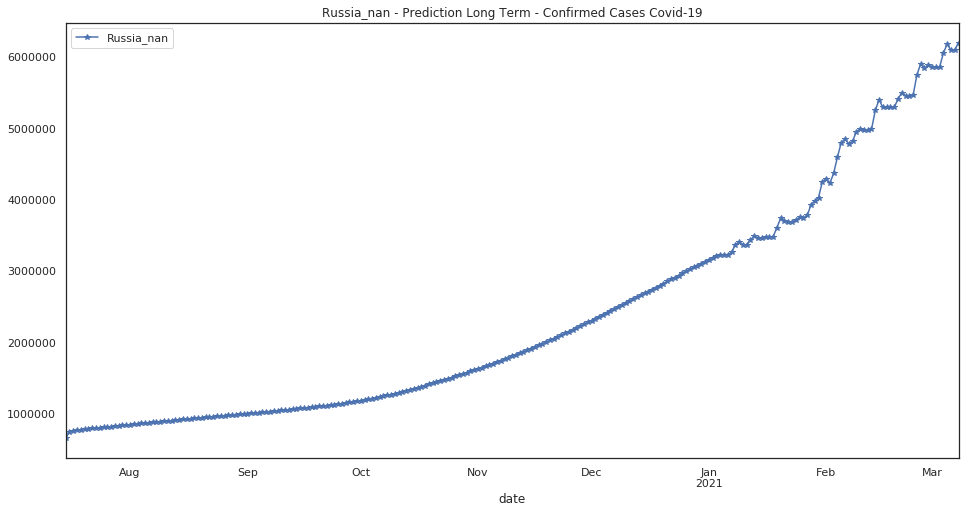

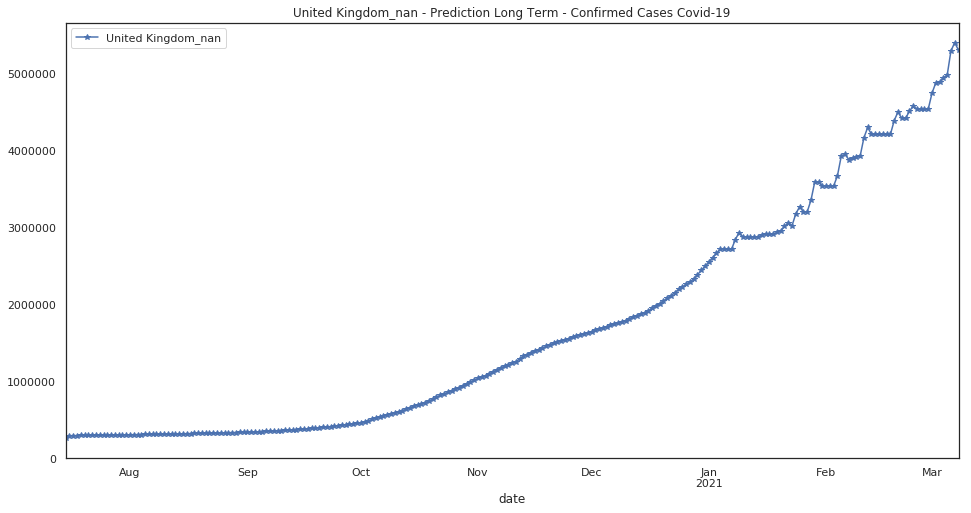

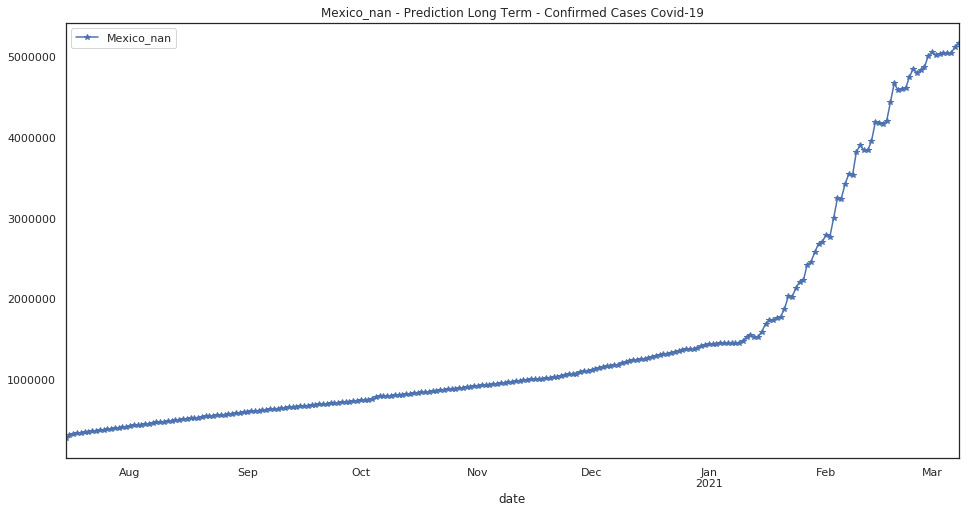

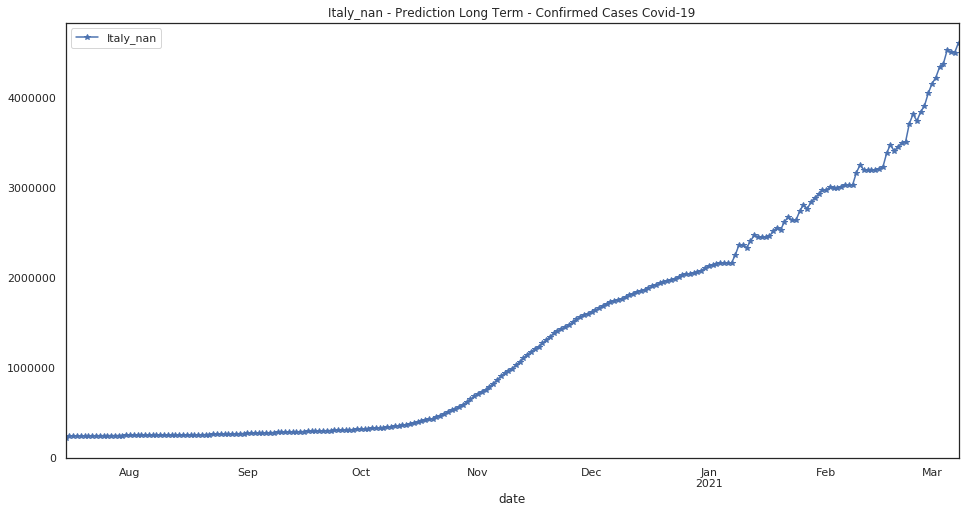

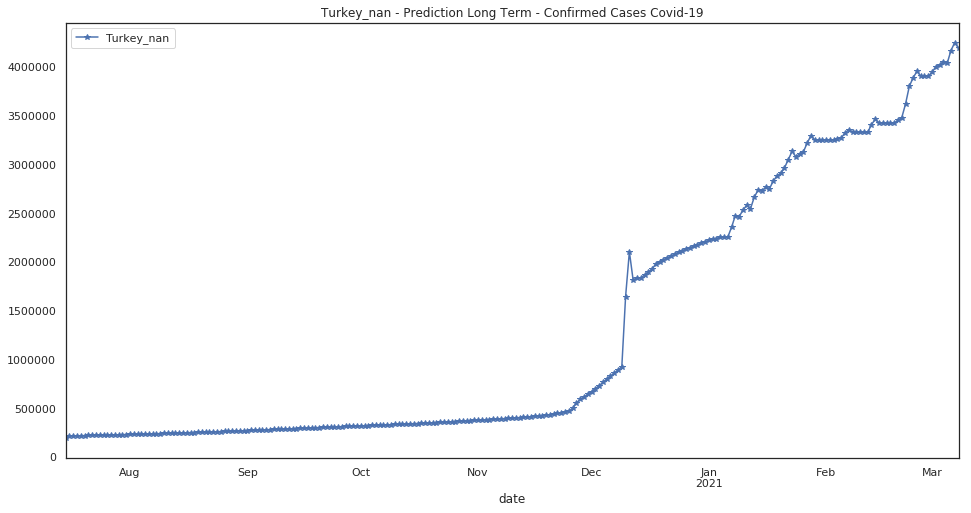

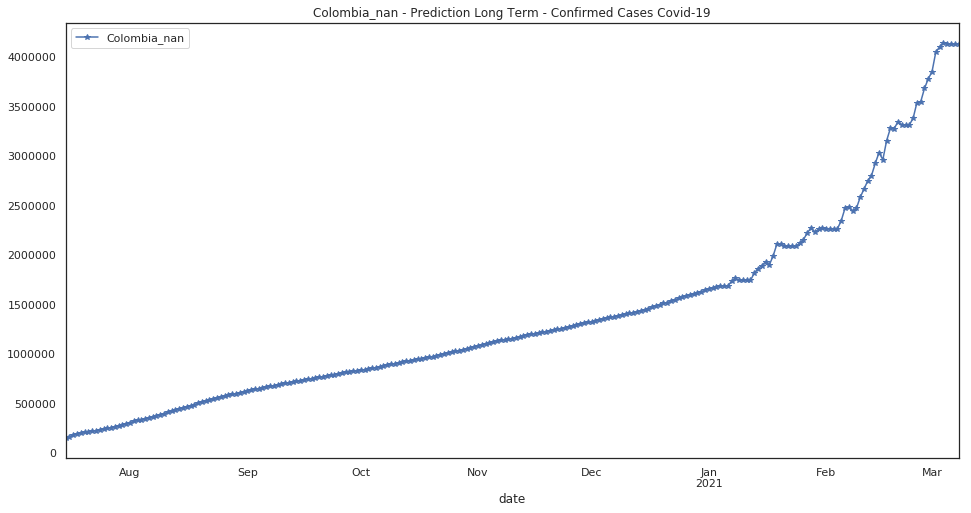

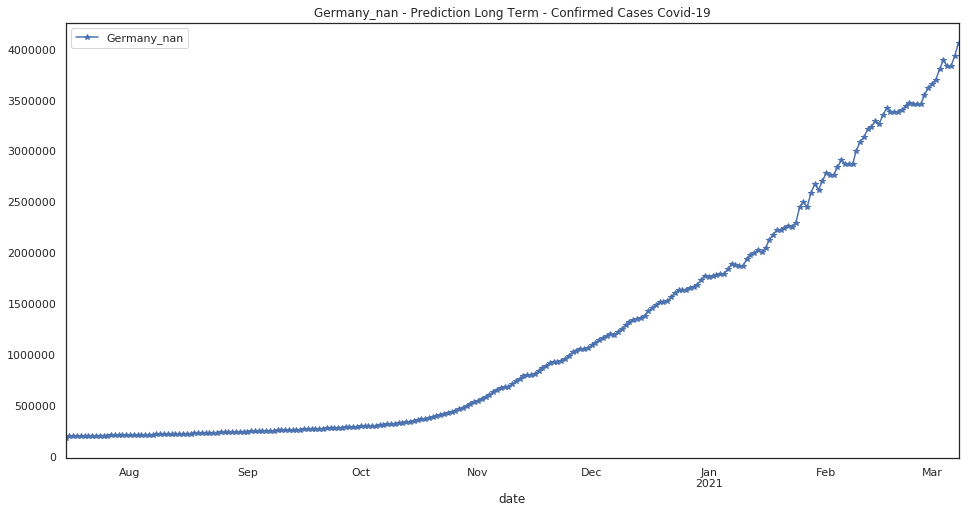

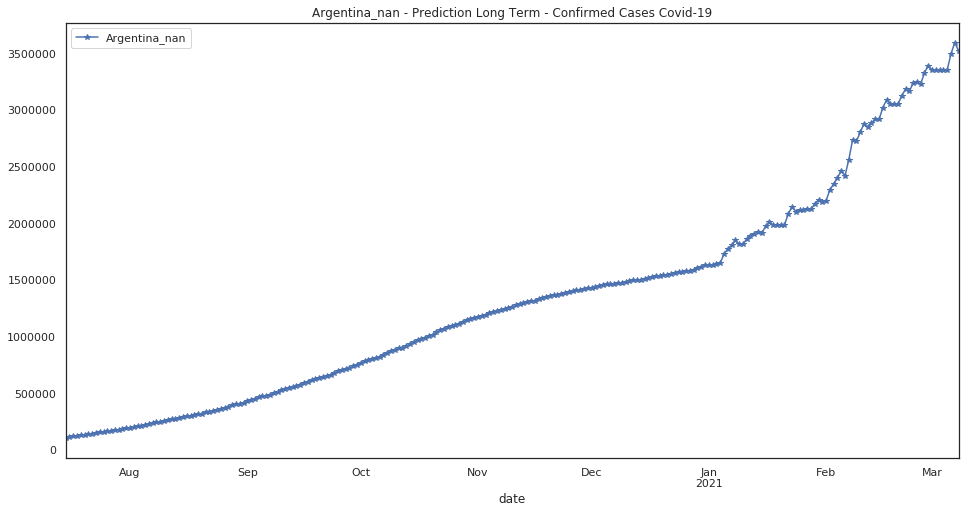

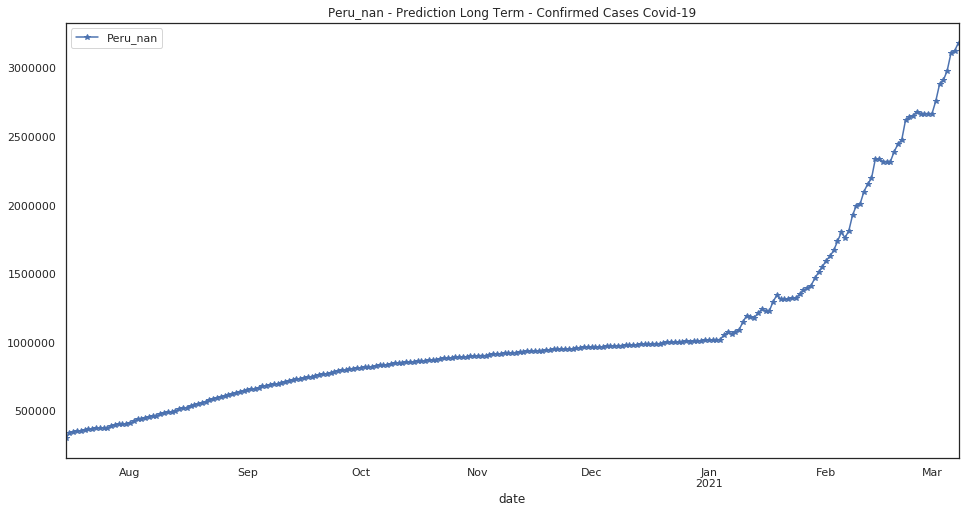

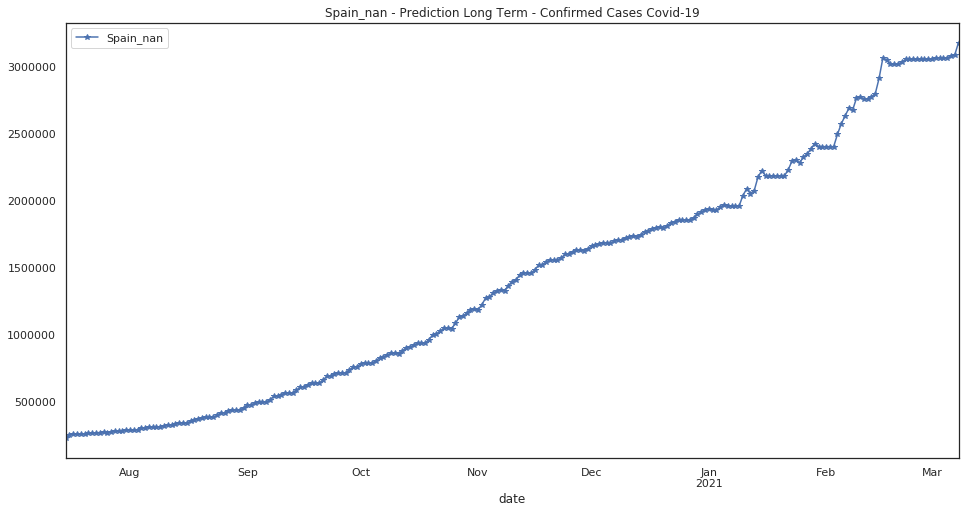

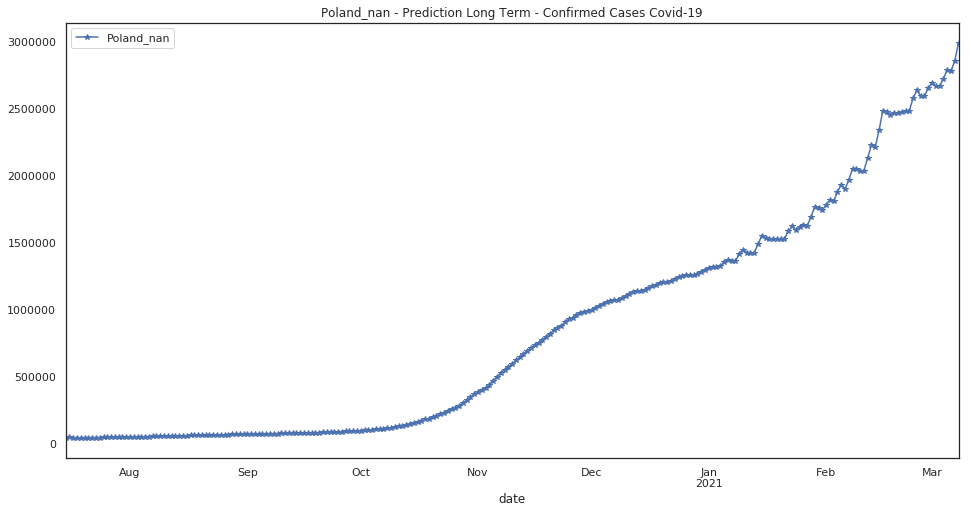

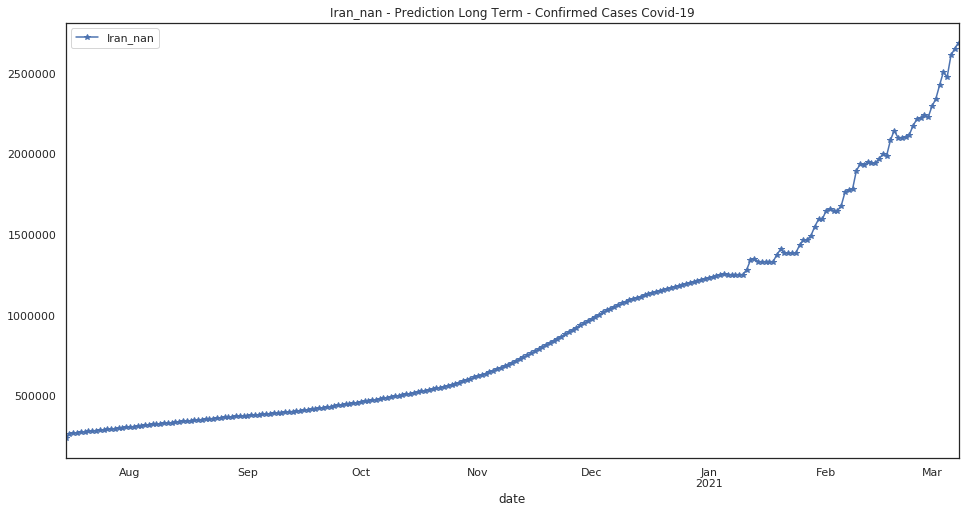

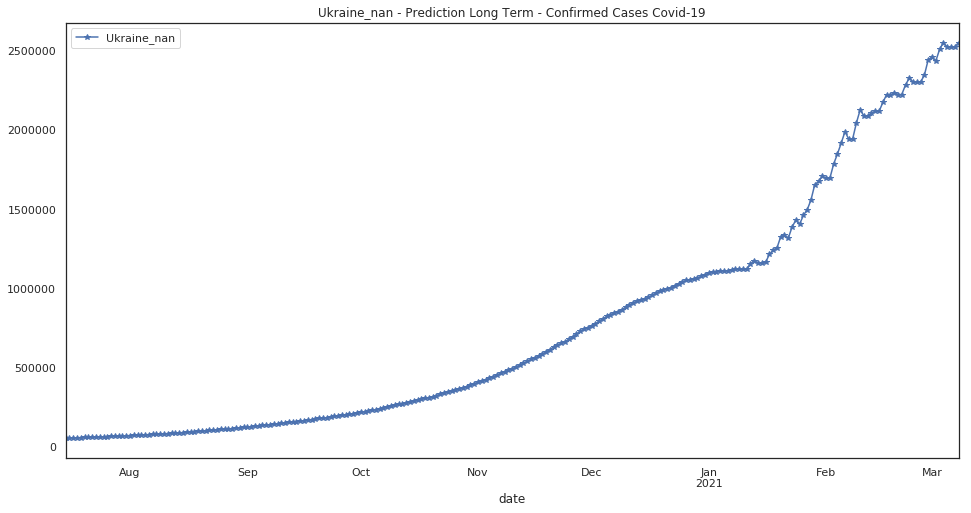

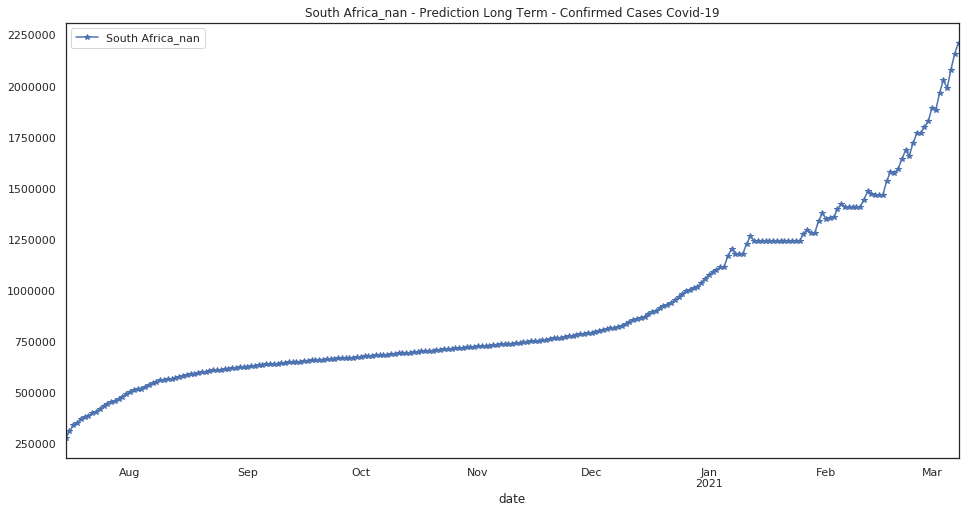

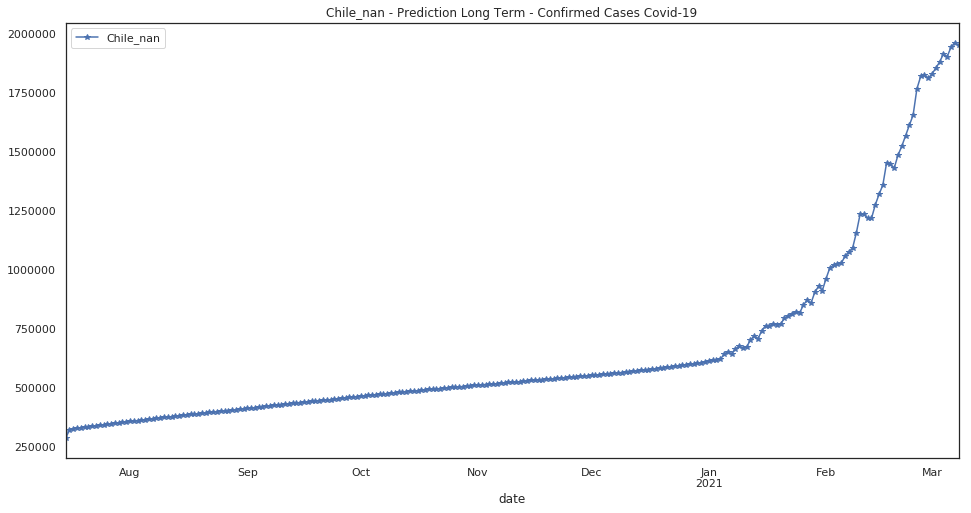

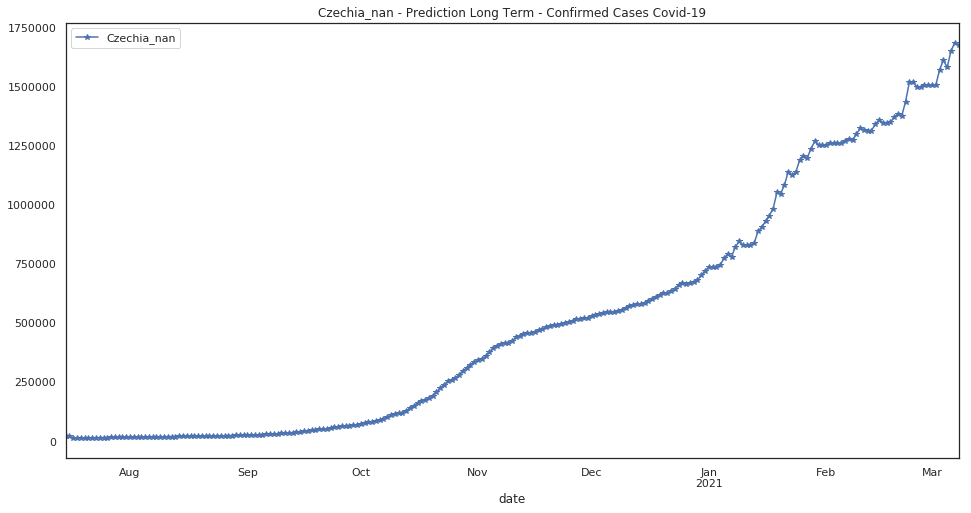

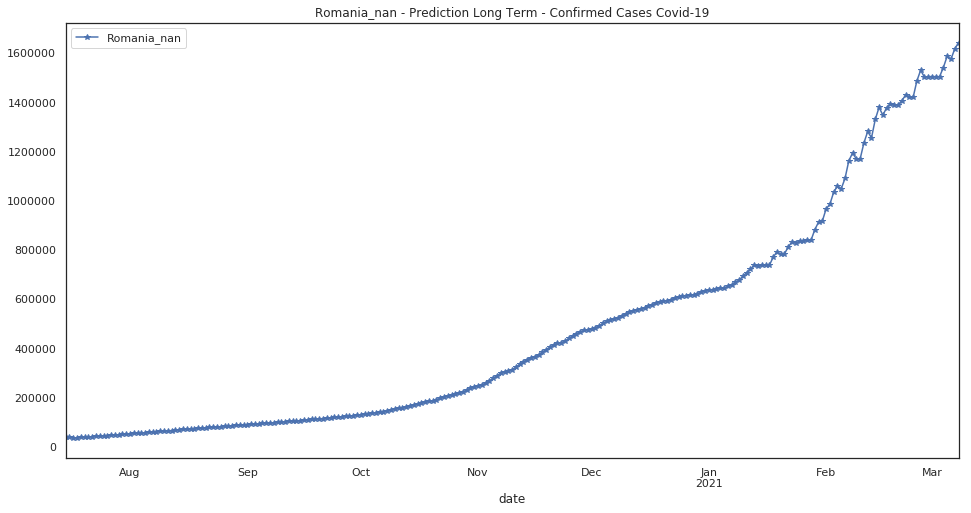

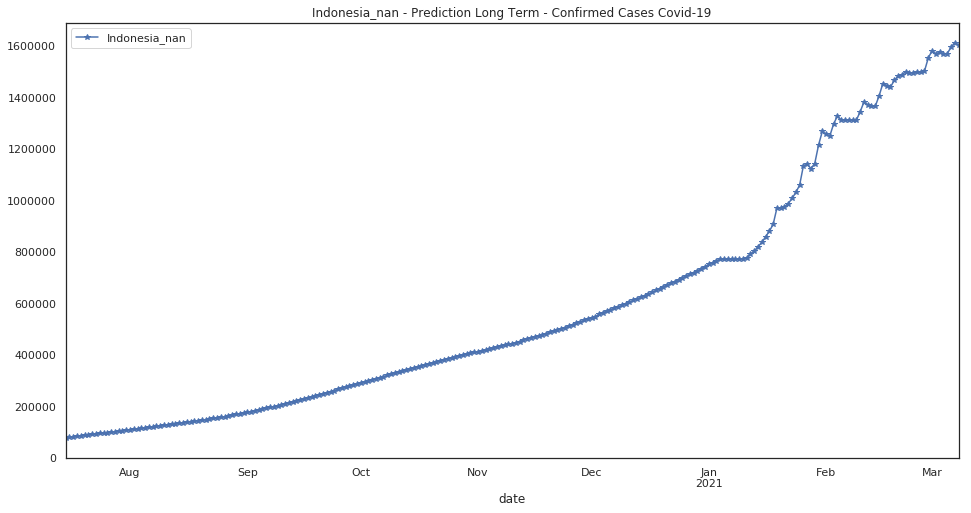

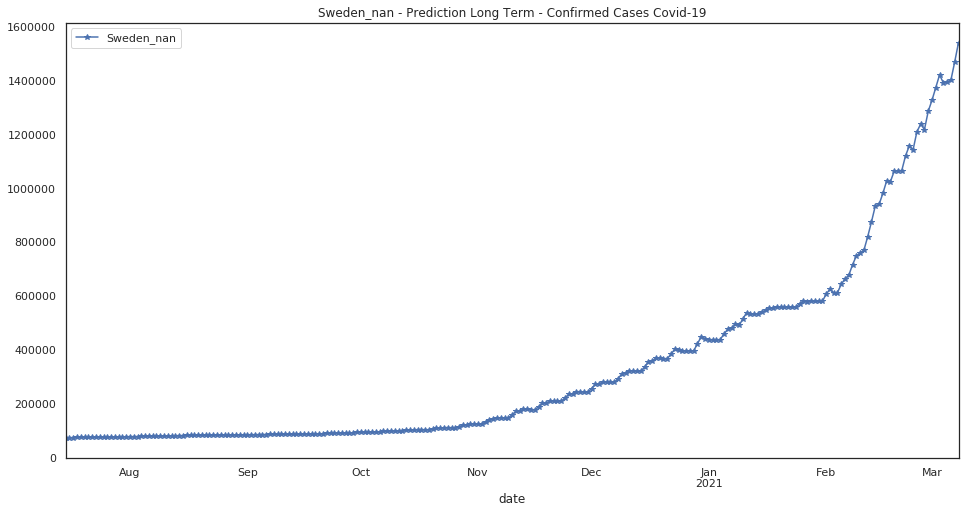

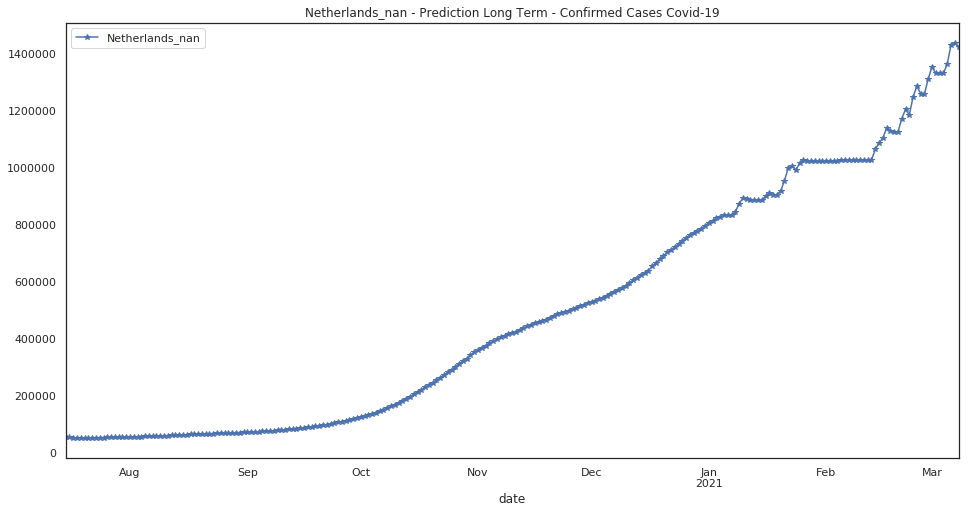

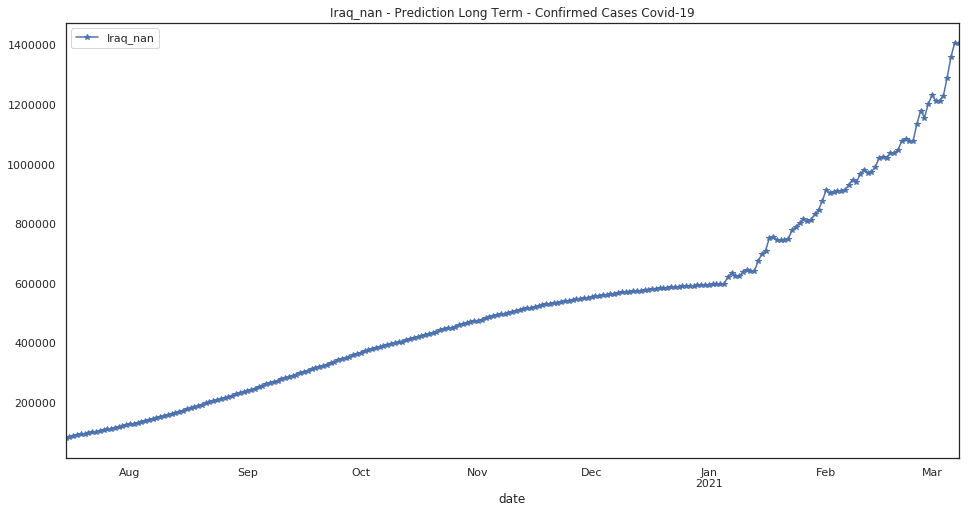

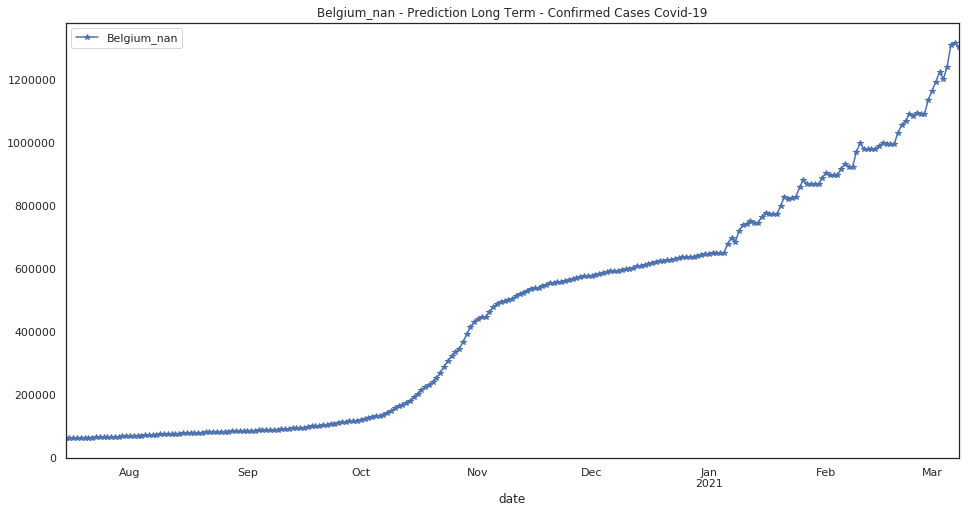

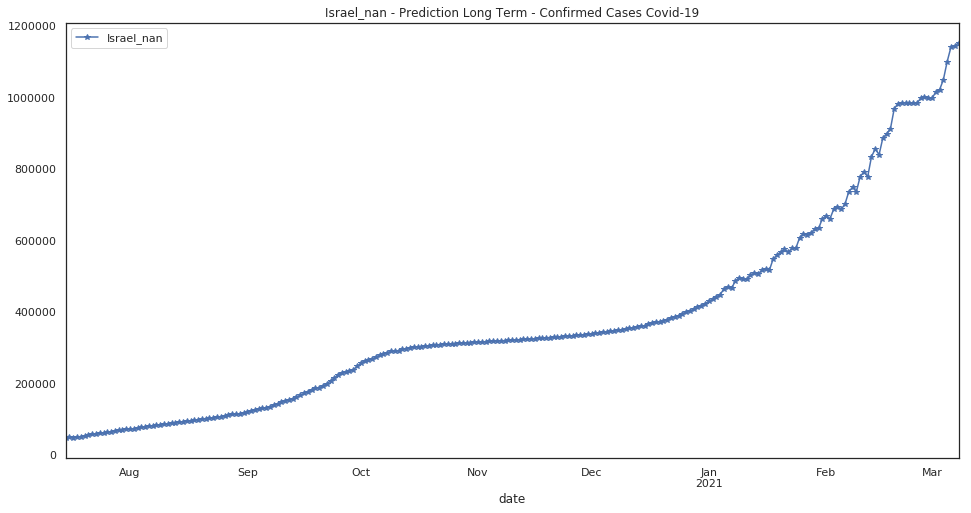

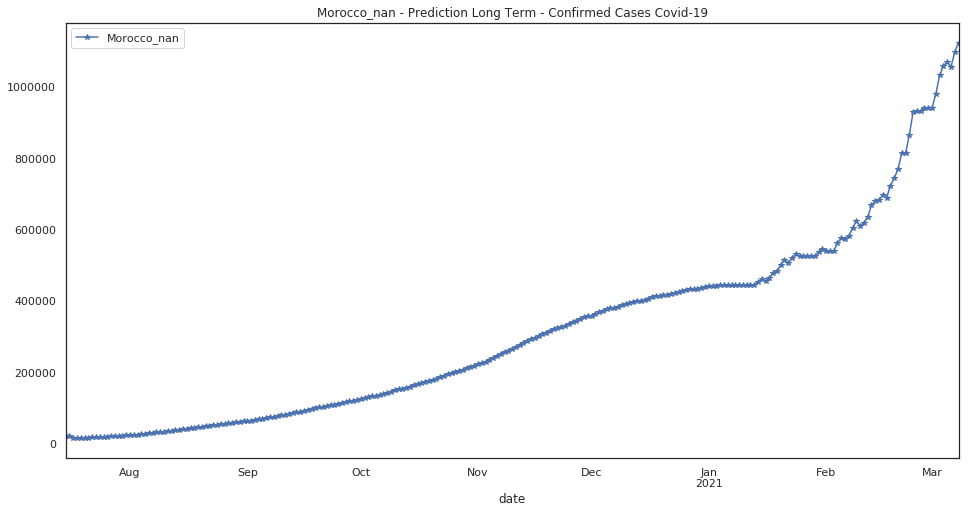

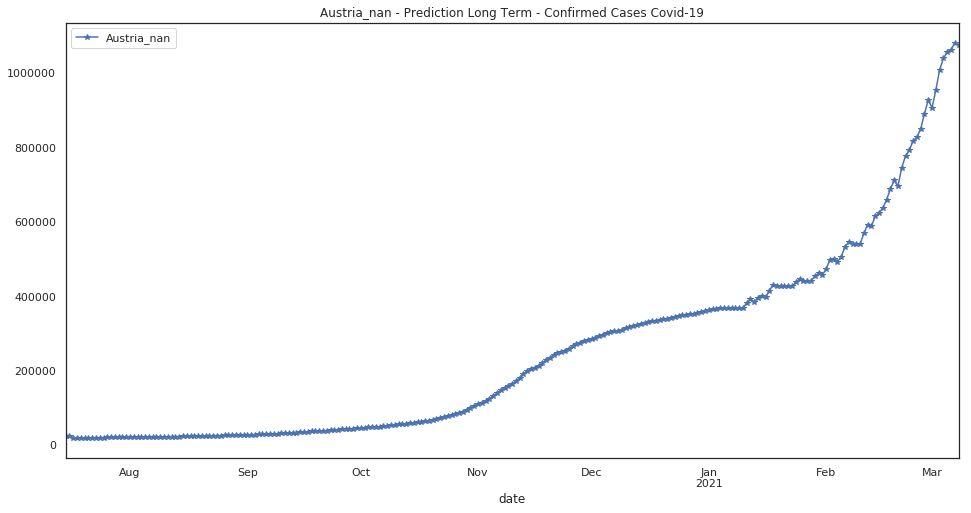

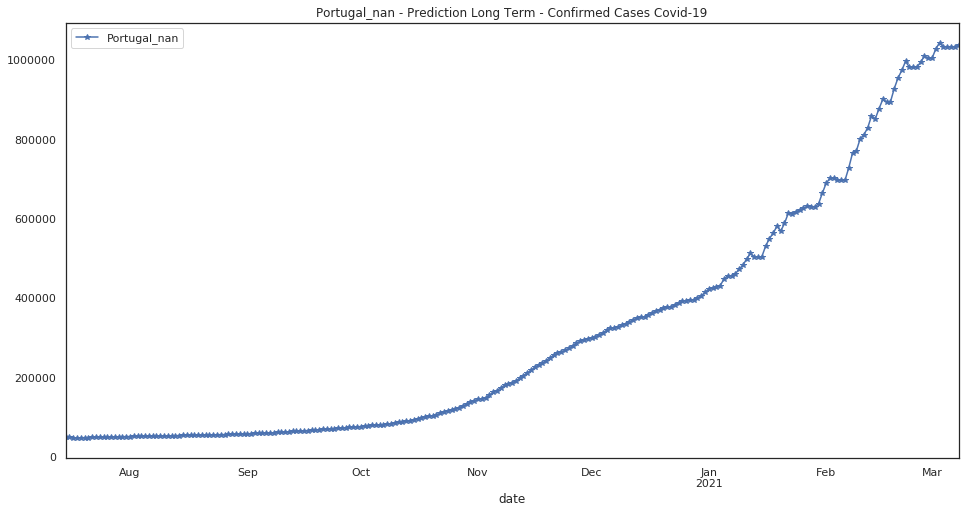

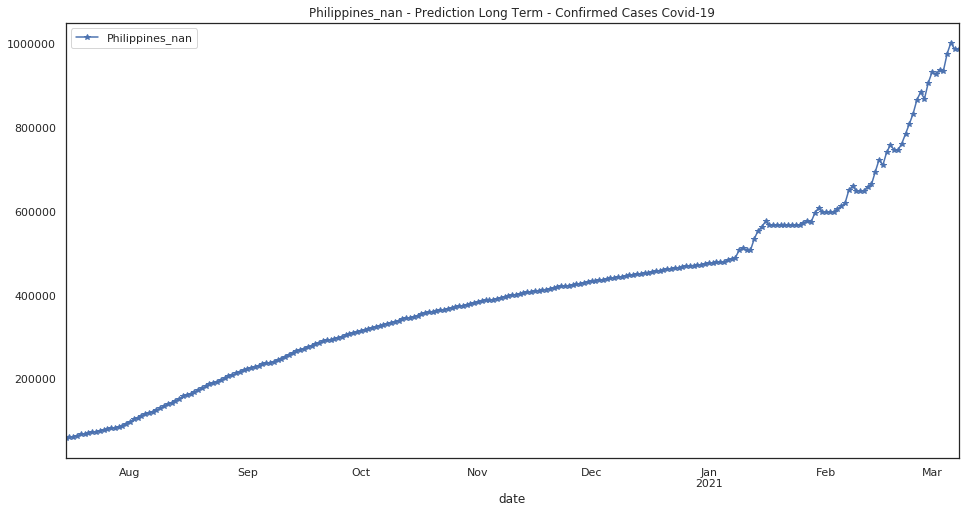

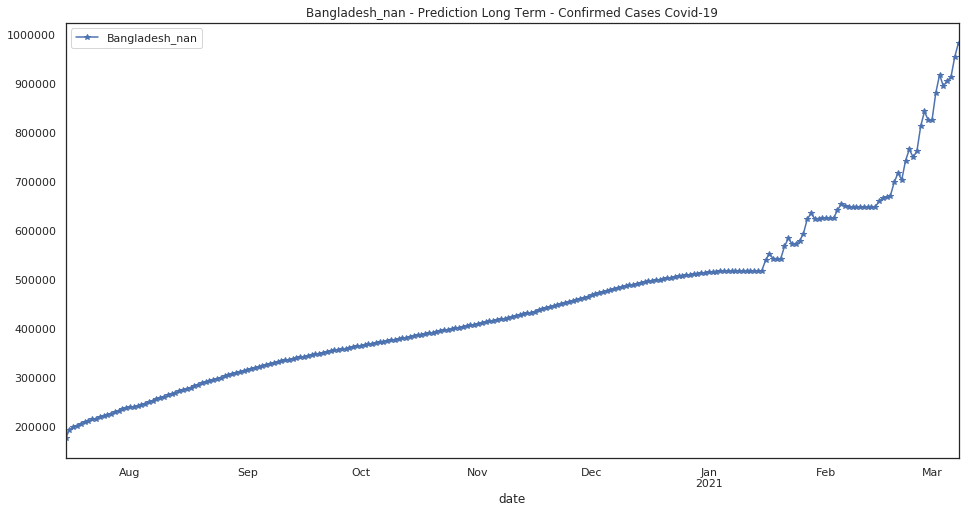

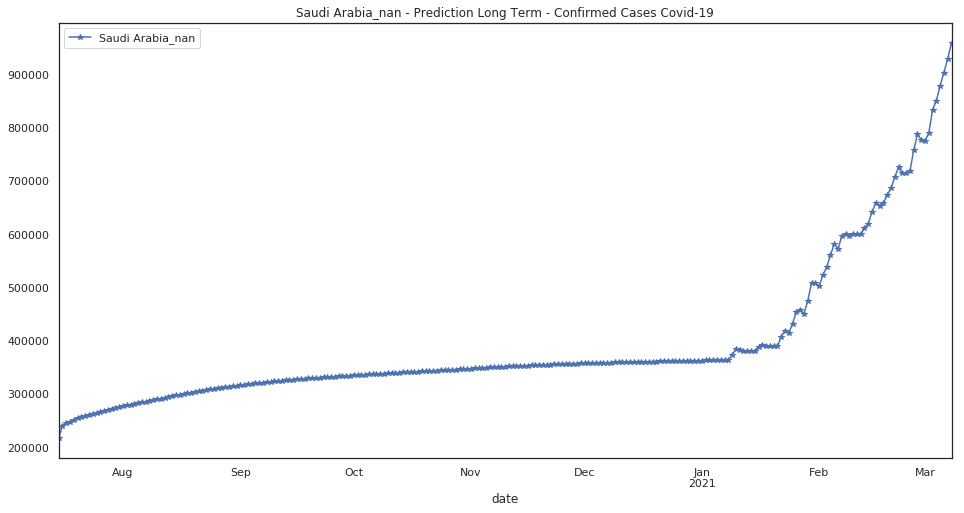

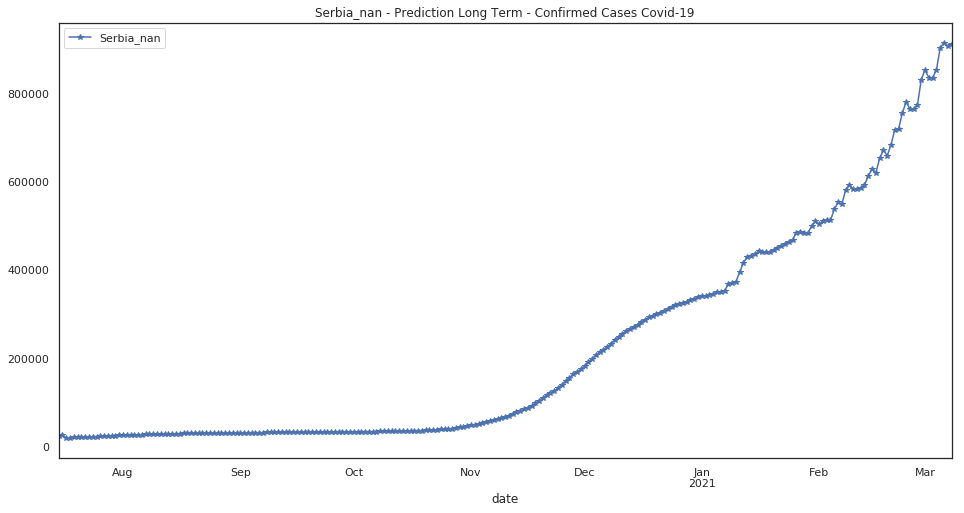

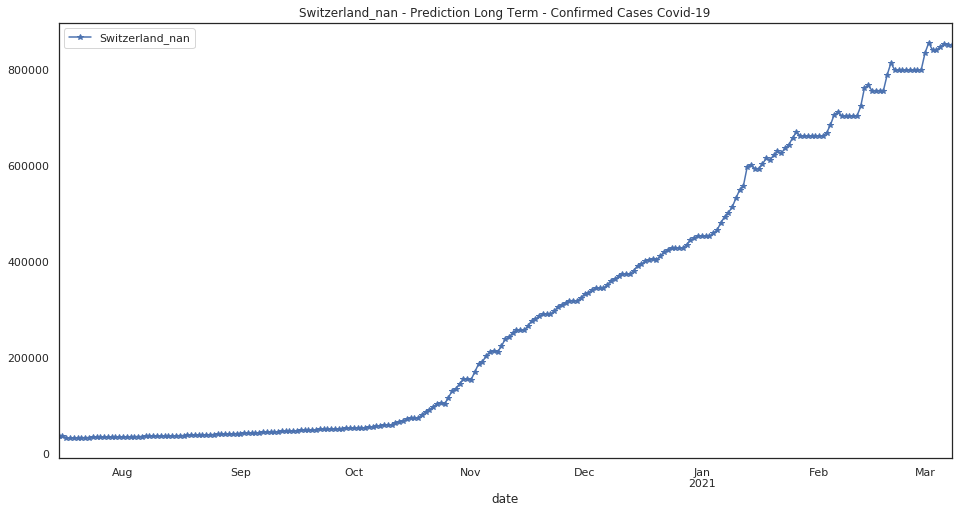

In [77]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

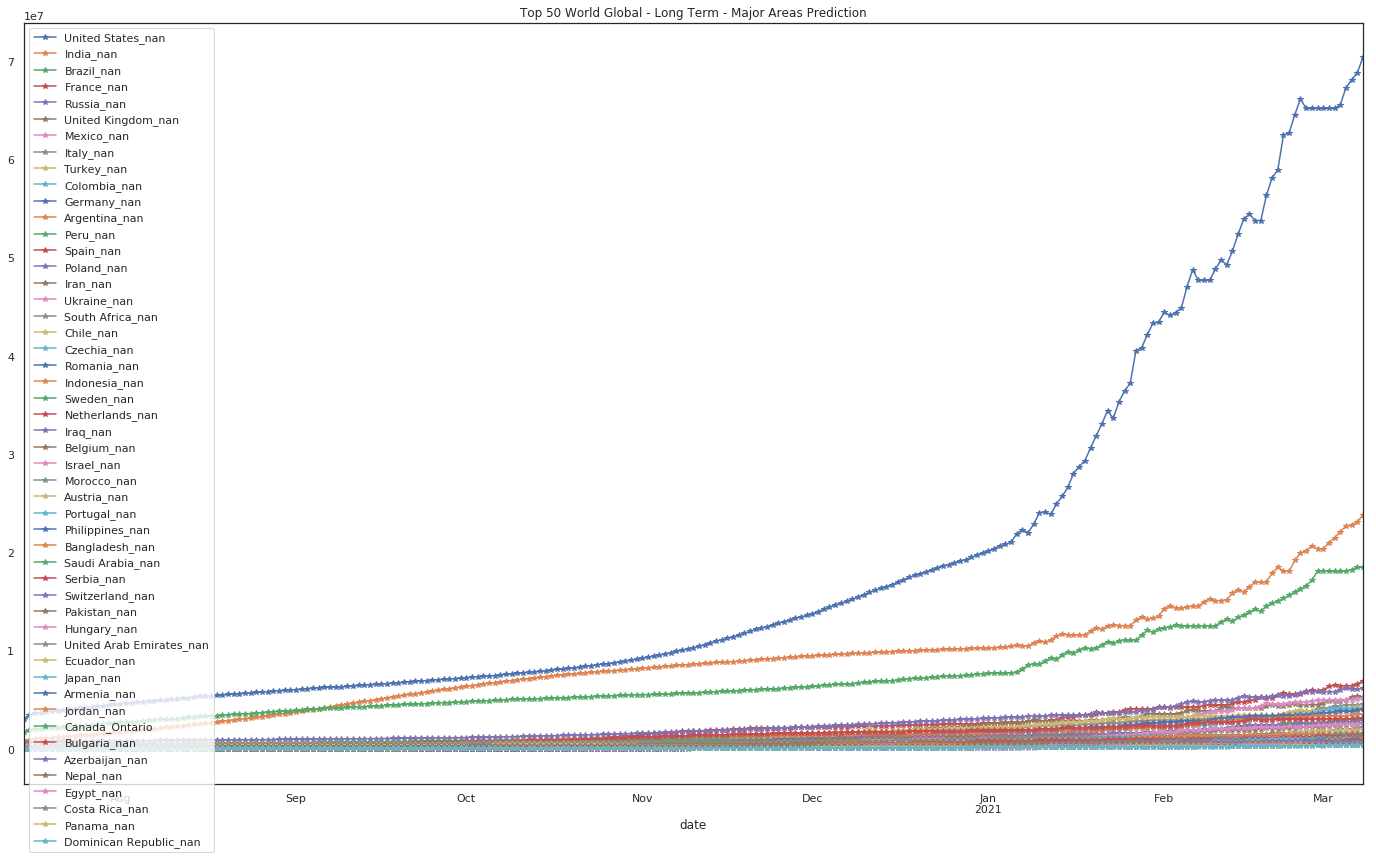

In [78]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

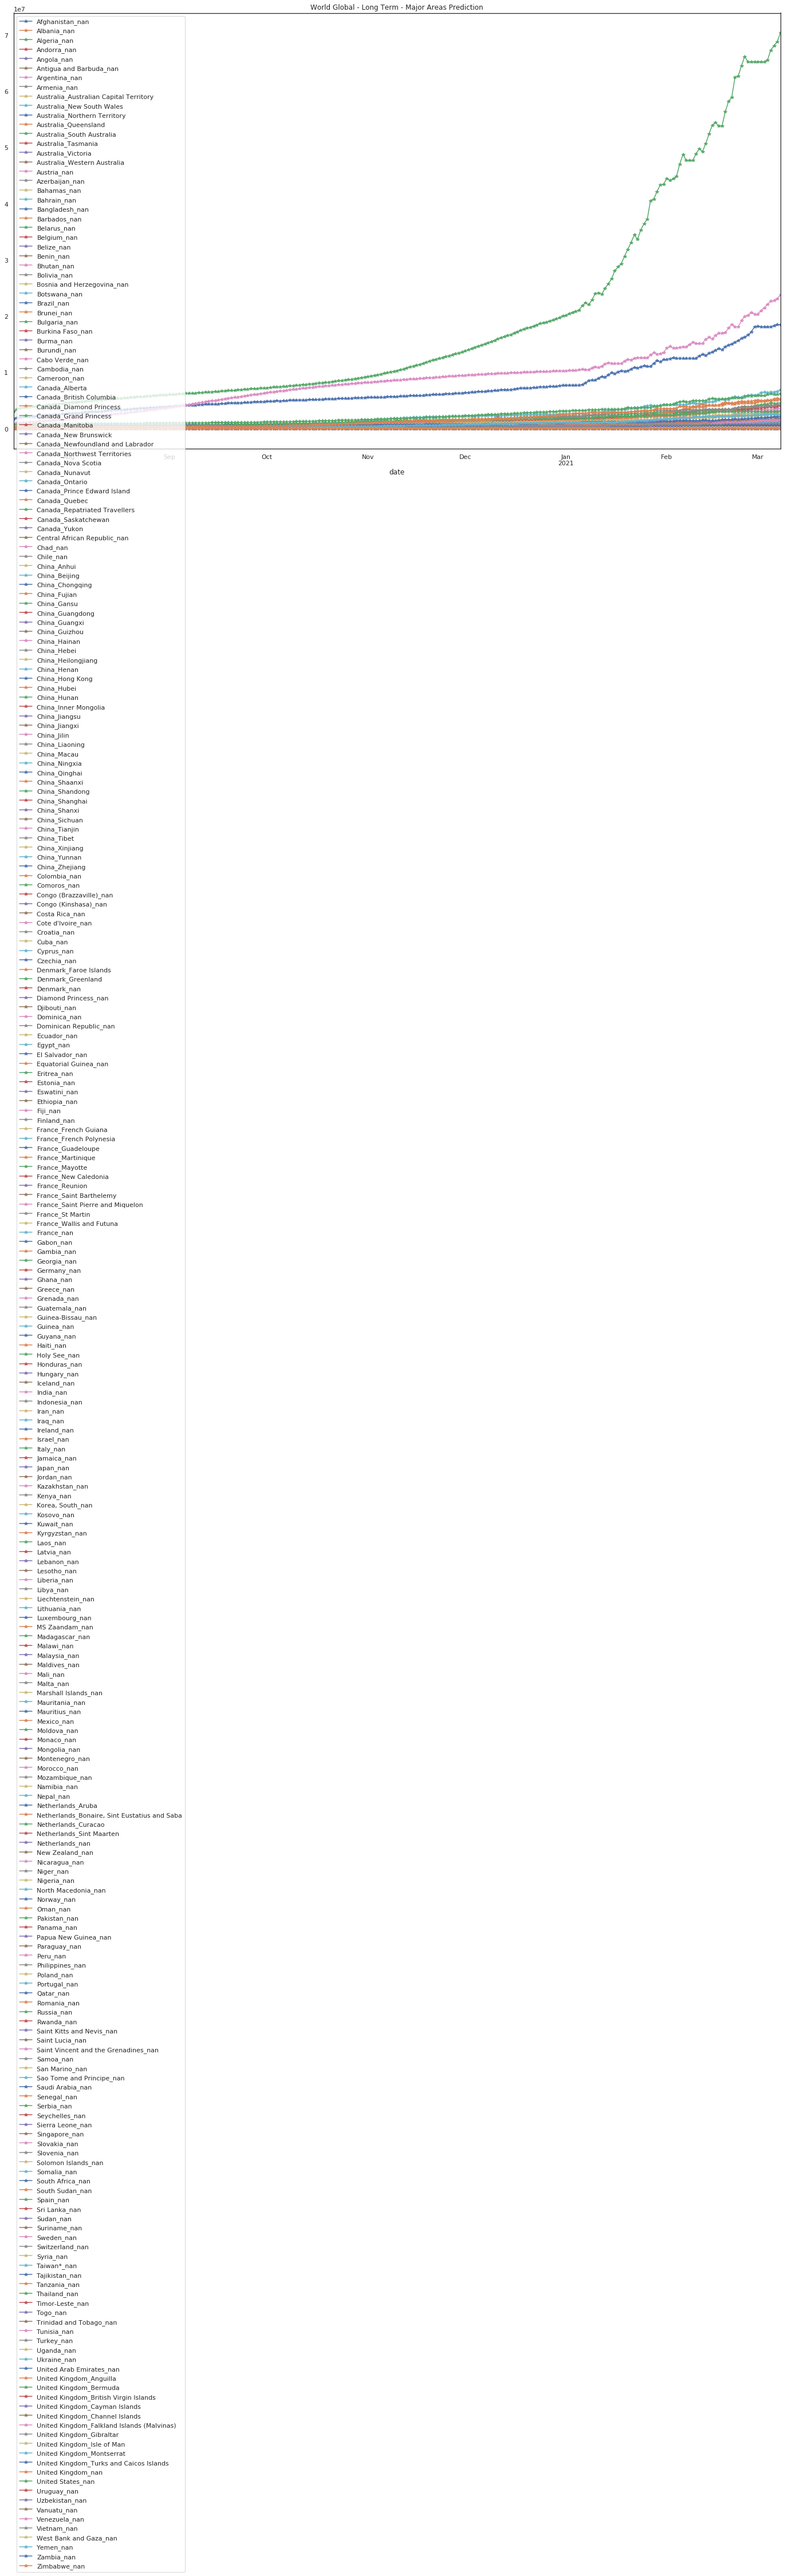

In [79]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [80]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [81]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-08-29          38203.0       9283.0      43816.0       1124.0   
2020-08-30          38222.0       9389.0      44182.0       1146.0   
2020-08-31          38234.0       9501.0      44529.0       1191.0   
2020-09-01          38263.0       9586.0      44865.0       1176.0   
2020-09-02          38318.0       9731.0      45189.0       1186.0   
2020-09-03          38369.0       9837.0      45500.0       1199.0   
2020-09-04          38390.0       9962.0      45805.0       1230.0   
2020-09-05          38402.0      10096.0      46105.0       1215.0   
2020-09-06          38466.0      10241.0      46400.0       1223.0   
2020-09-07          38568.0      10387.0      46692.0       1263.0   
2020-09-08          38608.0      10540.0      46979.0       1261.0   
2020-09-09          38621.0      10693.0      47260.0       1316.0   
2020-09-10          38645.0      10845.0      47533.0       1301.0   
2020-09-11          38674.0      11003.0      47798.0       1355.0   
2020-09-12          38709.0      11166.0      48054.0       1344.0   
2020-09-13          38779.0      11334.0      48301.0       1363.0   
2020-09-14          38849.0      11501.0      48543.0       1444.0   
2020-09-15          38895.0      11656.0      48782.0       1438.0   
2020-09-16          38933.0      11806.0      49015.0       1524.0   
2020-09-17          38948.0      11940.0      49244.0       1483.0   
2020-09-18          38965.0      12067.0      49465.0       1567.0   
2020-09-19          38988.0      12217.0      49676.0       1564.0   
2020-09-20          39098.0      12367.0      49879.0       1594.0   
2020-09-21          39166.0      12521.0      50076.0       1696.0   
2020-09-22          39174.0      12662.0      50268.0       1681.0   
2020-09-23          39219.0      12789.0      50455.0       1781.0   
2020-09-24          39245.0      12921.0      50635.0       1753.0   
2020-09-25          39257.0      13040.0      50811.0       1834.0   
2020-09-26          39262.0      13153.0      50973.0       1836.0   
2020-09-27          39289.0      13264.0      51125.0       1840.0   
...                     ...          ...          ...          ...   
2021-02-07          72618.0      81306.0     169242.0      10900.0   
2021-02-08          73861.0      83032.0     167816.0      11281.0   
2021-02-09          75158.0      84216.0     167816.0      11281.0   
2021-02-10          74940.0      85987.0     167816.0      11975.0   
2021-02-11          74940.0      89931.0     169513.0      11975.0   
2021-02-12          74940.0      92566.0     170986.0      12689.0   
2021-02-13          78460.0      94914.0     170350.0      12689.0   
2021-02-14          80400.0      97776.0     170440.0      12689.0   
2021-02-15          79185.0      99199.0     174916.0      12698.0   
2021-02-16          79862.0     100380.0     180114.0      13566.0   
2021-02-17          82810.0     104899.0     185554.0      13942.0   
2021-02-18          85828.0     106367.0     187916.0      13942.0   
2021-02-19          85685.0     106245.0     185384.0      13942.0   
2021-02-20          87297.0     107127.0     193029.0      14532.0   
2021-02-21          90940.0     107127.0     197163.0      15153.0   
2021-02-22          91254.0     107652.0     194666.0      15153.0   
2021-02-23          94839.0     108481.0     198184.0      15153.0   
2021-02-24          98091.0     108965.0     199999.0      15153.0   
2021-02-25          97046.0     115001.0     209658.0      15153.0   
2021-02-26          97000.0     117286.0     216004.0      15153.0   
2021-02-27          99974.0     115564.0     211805.0      15153.0   
2021-02-28         101985.0     118337.0     220979.0      15153.0   
2021-03-01         101700.0     119490.0     232672.0      15315.0   
2021-03-02         102158.0     123430.0     234631.0      16060.0   
2021-03-03

In [82]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [83]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [84]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [85]:
heatmap_m[:]

region        Lat        Long  \
0                               Afghanistan_nan  33.939110   67.709953   
1                                   Albania_nan  41.153300   20.168300   
2                                   Algeria_nan  28.033900    1.659600   
3                                   Andorra_nan  42.506300    1.521800   
4                                    Angola_nan -11.202700   17.873900   
5                       Antigua and Barbuda_nan  17.060800  -61.796400   
6                                 Argentina_nan -38.416100  -63.616700   
7                                   Armenia_nan  40.069100   45.038200   
8        Australia_Australian Capital Territory -35.473500  149.012400   
9                     Australia_New South Wales -33.868800  151.209300   
10                 Australia_Northern Territory -12.463400  130.845600   
11                         Australia_Queensland -27.469800  153.025100   
12                    Australia_South Australia -34.928500  138.600700   
13                           Australia_Tasmania -42.882100  147.327200   
14                           Australia_Victoria -37.813600  144.963100   
15                  Australia_Western Australia -31.950500  115.860500   
16                                  Austria_nan  47.516200   14.550100   
17                               Azerbaijan_nan  40.143100   47.576900   
18                                  Bahamas_nan  25.025885  -78.035889   
19                                  Bahrain_nan  26.027500   50.550000   
20                               Bangladesh_nan  23.685000   90.356300   
21                                 Barbados_nan  13.193900  -59.543200   
22                                  Belarus_nan  53.709800   27.953400   
23                                  Belgium_nan  50.833300    4.469936   
24                                   Belize_nan  17.189900  -88.497600   
25                                    Benin_nan   9.307700    2.315800   
26                                   Bhutan_nan  27.514200   90.433600   
27                                  Bolivia_nan -16.290200  -63.588700   
28                   Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                 Botswana_nan -22.328500   24.684900   
..                                          ...        ...         ...   
248                                Thailand_nan  15.870032  100.992541   
249                             Timor-Leste_nan  -8.874217  125.727539   
250                                    Togo_nan   8.619500    0.824800   
251                     Trinidad and Tobago_nan  10.691800  -61.222500   
252                                 Tunisia_nan  33.886917    9.537499   
253                                  Turkey_nan  38.963700   35.243300   
254                           United States_nan  40.000000 -100.000000   
255                                  Uganda_nan   1.373333   32.290275   
256                                 Ukraine_nan  48.379400   31.165600   
257                    United Arab Emirates_nan  23.424076   53.847818   
258                     United Kingdom_Anguilla  18.220600  -63.068600   
259                      United Kingdom_Bermuda  32.307800  -64.750500   
260       United Kingdom_British Virgin Islands  18.420700  -64.640000   
261               United Kingdom_Cayman Islands  19.313300  -81.254600   
262              United Kingdom_Channel Islands  49.372300   -2.364400   
263  United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
264                    United Kingdom_Gibraltar  36.140800   -5.353600   
265                  United Kingdom_Isle of Man  54.236100   -4.548100   
266                   United Kingdom_Montserrat  16.742498  -62.187366   
267     United Kingdom_Turks and Caicos Islands  21.694000  -71.797900   
268                          United Kingdom_nan  55.378100   -3.436000   
269                                 Uruguay_nan -32.522800  -55.765800   
270                              Uzbekistan_n

In [86]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat,lng,num,totpred,ldaygrowth in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]],  (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg ):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred))+' 1DayChangePred='+str(round(ldaygrowth))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

ValueError: Location values cannot contain NaNs.

In [87]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       6             Argentina_nan -38.416100  -63.616700   
1       7               Armenia_nan  40.069100   45.038200   
2      16               Austria_nan  47.516200   14.550100   
3      17            Azerbaijan_nan  40.143100   47.576900   
4      20            Bangladesh_nan  23.685000   90.356300   
5      23               Belgium_nan  50.833300    4.469936   
6      30                Brazil_nan -14.235000  -51.925300   
7      32              Bulgaria_nan  42.733900   25.485800   
8      51            Canada_Ontario  51.253800  -85.323200   
9      59                 Chile_nan -35.675100  -71.543000   
10     93              Colombia_nan   4.570900  -74.297300   
11     97            Costa Rica_nan   9.748900  -83.753400   
12    102               Czechia_nan  49.817500   15.473000   
13    110               Ecuador_nan  -1.831200  -78.183400   
14    111                 Egypt_nan  26.820553   30.802498   
15    131                France_nan  46.227600    2.213700   
16    136               Germany_nan  51.165691   10.451526   
17    148               Hungary_nan  47.162500   19.503300   
18    150                 India_nan  20.593684   78.962880   
19    151             Indonesia_nan  -0.789300  113.921300   
20    152                  Iran_nan  32.427908   53.688046   
21    153                  Iraq_nan  33.223191   43.679291   
22    154               Ireland_nan  53.142400   -7.692100   
23    155                Israel_nan  31.046051   34.851612   
24    156                Israel_nan  31.046051   34.851612   
25    157                 Italy_nan  41.871940   12.567380   
26    159                 Japan_nan  36.204824  138.252924   
27    160                Jordan_nan  31.240000   36.510000   
28    187                Mexico_nan  23.634500 -102.552800   
29    192               Morocco_nan  31.791700   -7.092600   
30    195                 Nepal_nan  28.166700   84.250000   
31    200           Netherlands_nan  52.132600    5.291300   
32    208              Pakistan_nan  30.375300   69.345100   
33    209                Panama_nan   8.538000  -80.782100   
34    212                  Peru_nan  -9.190000  -75.015200   
35    213           Philippines_nan  12.879721  121.774017   
36    214                Poland_nan  51.919400   19.145100   
37    215              Portugal_nan  39.399900   -8.224500   
38    217               Romania_nan  45.943200   24.966800   
39    218                Russia_nan  61.524010  105.318756   
40    226          Saudi Arabia_nan  23.885942   45.079162   
41    228                Serbia_nan  44.016500   21.005900   
42    236          South Africa_nan -30.559500   22.937500   
43    238                 Spain_nan  40.463667   -3.749220   
44    242                Sweden_nan  60.128161   18.643501   
45    243           Switzerland_nan  46.818200    8.227500   
46    253                Turkey_nan  38.963700   35.243300   
47    254         United States_nan  40.000000 -100.000000   
48    256               Ukraine_nan  48.379400   31.165600   
49    257  United Arab Emirates_nan  23.424076   53.847818   
50    268        United Kingdom_nan  55.378100   -3.436000   

    2020-07-15 00:00:00  2020-07-16 00:00:00  2020-07-17 00:00:00  \
0              105117.0             111146.0             119065.0   
1               37083.0              37566.0              33559.0   
2               25024.0              25125.0              19270.0   
3               30699.0              31128.0              26165.0   
4              176897.0             193590.0             199143.0   
5               63087.0              63406.0              63238.0   
6             1720697.0            1966748.0            2060378.0   
7               15206.0              15438.0               8144.0   
8               42232.0              42340.0              39043.0   
9              288005.0             321205.0             326174.0   
10             15215

In [88]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat2,lng2,num2,totpred2,ldaygrowth2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg ):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred2))+' 1DayChangePred='+str(round(ldaygrowth2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [89]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [90]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [91]:
exit()